In [1]:
!python --version
import os
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()

client

Python 3.10.16


<Client: 'tcp://127.0.0.1:36205' processes=7 threads=28, memory=62.58 GiB>

In [2]:
### use numba to speed up the code
from numba import jit

@jit(nopython=True)
def fast_function():
    pass


### Use Memory-Efficient Pandas Operations
import pandas as pd
pd.options.mode.chained_assignment = None  # Disable warnings
pd.set_option("display.float_format", "{:.4f}".format)  # Reduce memory usage



# 1. Workbook setups

## 1.1 Import packages

In [3]:
import pandas as pd
import numpy as np
import xarray as xr
xr.set_options(file_cache_maxsize=10)

import scipy as scipy
from scipy import stats
import math
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import proplot as plot
import cartopy.crs as ccrs
import seaborn as sns

import shapefile as shp
from shapely.geometry import Point, Polygon
import shapely
from geopy.distance import distance, Distance, lonlat

from matplotlib import font_manager
font_manager.findfont("TeX Gyre Heros")
mpl.rcParams.update({'font.sans-serif':'TeX Gyre Heros',
                    'font.weight': 'normal',
                    'axes.labelweight': 'normal',
                    'axes.titleweight': 'normal',
                    'pdf.fonttype':42,
                    'ps.fonttype':42
                     })

import string
import os
import requests
import io
from tqdm import tqdm
import time
import h5py
import scipy.io

## 1.2 Miscellaneous codes

In [4]:
def round_to_nearest_half_int(num):
    return round(num * 2) / 2

def getClosestPoint_fromLineString(LineString_input,point1):
    if "MultiLineString" in str(type(LineString_input)):
        multiLineString = LineString_input
        len_multiLineString = len(multiLineString.geoms)
        idxMin = np.array([multiLineString.geoms[i].distance(point1) for i in range(len_multiLineString)]).argmin()
        
        LineString = multiLineString.geoms[idxMin]
    elif "Polygon" in str(type(LineString_input)):
        
        polygon_input = LineString_input
        LineString = polygon_input.exterior
        
    else:
        LineString = LineString_input
        
    Coords = LineString.coords
    x, y = Coords.xy

    coords_df = pd.DataFrame({'LON':x,'LAT':y})
    coords_df['LAT_diff'] = abs(point1.y-coords_df.LAT)
    coords_df['LON_diff'] = abs(point1.x-coords_df.LON)
    coords_df['LONLAT_diff_sum'] = coords_df['LAT_diff']+coords_df['LON_diff']
    lat2,lon2 = coords_df.LAT.iloc[coords_df.LONLAT_diff_sum.idxmin()],coords_df.LON.iloc[coords_df.LONLAT_diff_sum.idxmin()]
    point2 = Point(lon2,lat2)
    return point2

def distance_haversine(origin, destination, output_unit='km'):
    import math
    lon1, lat1 = origin
    lon2, lat2 = destination
    
    if output_unit=='km':
        radius = 6371
    elif output_unit=='mi':
        radius = 3956
    elif output_unit=='m':
        radius = 6371000
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

# Define usefull functions:
def vrange(V): # Return the array value range
    return [np.min(V),np.max(V)]
def vrangec(V): # Return the array value centered range 
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])

def nonnan_gradient(array, axis=None, edge_order=1):
  """Computes the gradient of an array, ignoring NaN values.

  Args:
    array: An N-dimensional array containing samples of a scalar function.
    axis: The axis along which to compute the gradient. If None, the gradient
      is computed for all axes.
    edge_order: The order of the accuracy of the approximation at the edges of
      the array.

  Returns:
    An N-dimensional array or a list of N-dimensional arrays representing the
    gradient.
  """

  # Create a mask of non-NaN values.
  mask = np.isfinite(array)

  # Compute the gradient of the masked array.
  gradient = np.gradient(array, axis=axis, edge_order=edge_order)

  # Set the gradient to zero wherever the mask is False.
  for i in range(len(gradient)):
    gradient[i][~mask] = 0

  return gradient

## 1.3 Dictionaries

In [5]:
ringNumbers_dict_zhang16 = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':4, 
    'fGDGT_cren':4,
    'reported_1292_iso':4,
    'fGDGT_cren_prime':4,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

ringNumbers_dict_revised = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':5, 
    'fGDGT_cren':5,
    'reported_1292_iso':5,
    'fGDGT_cren_prime':5,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

def label_pvalues(x):
    if x<0.001:
        return r'$\it{P}$<.001'
    elif x<0.01:
        return r'$\it{P}$<.01'
    elif x<0.05:
        return r'$\it{P}$<.05'
    elif x<0.1:
        return r'$\it{P}$<.1'
    elif x>=0.1:
        return r'$\it{P}$>.1'


## 1.4 Set local paths

In [6]:
# set the path to local folder other than github
login_name = os.getlogin()
### 1.4.1 Local path on PC
local_documents_path = f'/home/{login_name}/Documents' ### this is the path when code is run on Linux

### 1.4.2 Path to github folder
gitpath_idx = os.getcwd().find('nutrient-effect-on-TEX')+len('nutrient-effect-on-TEX')
local_github_path = os.getcwd()[:gitpath_idx]

### 1.4.3 Path to OneDrive folder
local_onedrive_path = f'/home/{login_name}/OneDrive'

# 2. Import data

## 2.1 Processed coretop_df_full


In [7]:
local_github_path

'/home/ronnie-rattan/Documents/GitHub/nutrient-effect-on-TEX'

In [8]:
fpath = fr'{local_github_path}/spreadsheets'
fname = 'ds03_processed_coretop_tex.csv'

coretop_df = pd.read_csv(f'{fpath}/{fname}')
coretop_df

sampleID  index_column           core_name core_type  sample_depth_start  \
0     RR00001  JET_RR_00001          GeoB7702-3        GC              5.0000   
1     RR00002  JET_RR_00002     KNR195-5-5 MC11        MC              6.0000   
2     RR00003  JET_RR_00003     KNR195-5-6 MC12        MC              0.0000   
3     RR00004  JET_RR_00004     KNR195-5-7 MC16        MC              0.0000   
4     RR00005  JET_RR_00005     KNR195-5-8 MC18        MC              4.0000   
...       ...           ...                 ...       ...                 ...   
2077  RR02080  JET_RR_02080        AMD17_176_BC       NaN                 NaN   
2078  RR02081  JET_RR_02081        AMD17_8.1_BC       NaN                 NaN   
2079  RR02082  JET_RR_02082  AMD17_Disko_Fan_BC       NaN                 NaN   
2080  RR02083  JET_RR_02083    DSDP591_0-3cm_PC        PC              0.0000   
2081  RR02084  JET_RR_02084  IODPU1510_6-8cm_PC        PC              6.0000   

      sample_depth_end  Latitude  Longitude  modernWaterDepth  TEX86  ...  \
0               6.0000   31.6517    34.0733          562.0000 0.6620  ...   
1               8.0000   -1.5327   -86.7852         2288.0000 0.6029  ...   
2               1.0000   -3.7105   -81.1153          378.0000 0.5700  ...   
3               1.0000   -3.7502   -81.1358          379.0000 0.5720  ...   
4               6.0000   -3.9690   -81.3100         1024.0000 0.5994  ...   
...                ...       ...        ...               ...    ...  ...   
2077               NaN   69.6000   -65.4000          267.0000 0.4000  ...   
2078               NaN   69.4100   -64.4000         1054.0000 0.3226  ...   
2079               NaN   67.9700   -59.4900         1012.0000 0.3750  ...   
2080            3.0000  -31.5843    64.4487         2131.0000 0.6712  ...   
2081            8.0000  -36.3290   164.5587         1238.0000 0.5573  ...   

      thermocline_depth  thermocline_T  thermocline_T_depthIntegral    SSN  \
0               55.0000        19.0069                      21.5897 0.0882   
1               25.0000        20.8615                      22.5202 4.0946   
2               15.0000        20.7300                      22.0932 3.5177   
3               15.0000        20.5830                      22.0416 4.4152   
4               15.0000        20.1193                      21.3194 4.3262   
...                 ...            ...                          ...    ...   
2077            10.0000        -0.8792                      -0.6309 3.0862   
2078            10.0000        -0.8413                      -0.5349 2.9766   
2079            10.0000         0.0889                       0.3247 2.7838   
2080            50.0000        18.6676                      19.7570 0.9526   
2081            55.0000        16.8306                      17.5747 0.9892   

      thermocline_nitrate  thermocline_nitrate_depthIntegral  region_ID  \
0                  0.0039                             0.0257        NaN   
1                  8.3004                             5.3182    10.0000   
2                  5.8044                             4.2084        NaN   
3                  7.1120                             5.3783        NaN   
4                  6.4625                             4.9695    10.0000   
...                   ...                                ...        ...   
2077               3.1556                             3.1075    60.0000   
2078               3.0433                             2.9951    60.0000   
2079               2.8294                             2.7958    60.0000   
2080               1.5119                             1.0900    61.0000   
2081               1.5430                             1.1053    61.0000   

                   regionName pred_tex tex_residuals  
0                         NaN   0.5933        0.0687  
1     East Equatorial Pacific   0.6032       -0.0003  
2                         NaN   0.5986       -0.0286  
3                         NaN   0.5981       -0.0

In [9]:
import matplotlib.colors as mcolors
##### concatenate three colormaps

colors1 = plot.get_colors('tab10')
colors2 = plot.get_colors('tab20b')
colors3 = plot.get_colors('538')
colors4 = plot.get_colors('tab20c')
colors5 = plot.get_colors('bmh')

combined_cmap = np.concatenate((colors1,colors2,colors3,colors4,colors5))
extended_cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap',combined_cmap)
#########
region_list_full = coretop_df['regionName'].unique()
color_list_full = plot.get_colors(extended_cmap,len(region_list_full))

region_color_dict_full = dict(zip(region_list_full,color_list_full))
region_color_dict_full

region_color_dict_full_rgb = {k:mpl.colors.to_rgba(v) for k,v in region_color_dict_full.items()}
region_color_dict_full_rgb

{nan: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 'East Equatorial Pacific': (0.984313725490196,
  0.5019607843137255,
  0.058823529411764705,
  1.0),
 'Mozambique Channel': (0.2, 0.6078431372549019, 0.17254901960784313, 1.0),
 'Pacific-Southern Ocean': (0.8235294117647058,
  0.16862745098039217,
  0.19215686274509805,
  1.0),
 'Tasman-Antarctica 140E Transect': (0.5764705882352941,
  0.4,
  0.7058823529411765,
  1.0),
 'NZ-SW Pacific': (0.5843137254901961,
  0.34901960784313724,
  0.3411764705882353,
  1.0),
 'Equatorial Pacific': (0.7450980392156863,
  0.47843137254901963,
  0.6627450980392157,
  1.0),
 'West Equatorial Pacific': (0.592156862745098,
  0.592156862745098,
  0.3568627450980392,
  1.0),
 'Tonga-Tropical South Pacific': (0.47058823529411764,
  0.7411764705882353,
  0.4117647058823529,
  1.0),
 'South China Sea': (0.14901960784313725,
  0.5215686274509804,
  0.6666666666666666,
  1.0),
 'Chilean Offshore': (0.26666666666666666,
  0.2745098039215686

In [10]:
regionName_df = coretop_df.pivot_table(index=('region_ID','regionName'),values='TEX86',aggfunc='count').reset_index()[['region_ID','regionName']]
regionID_to_regionName_dict = dict(zip(regionName_df['region_ID'],regionName_df['regionName']))
regionID_to_regionName_dict


{1.0: 'Amundsen Sea',
 2.0: 'Arabian Sea',
 3.0: 'Arctic Ocean',
 4.0: 'Baltic Sea',
 5.0: 'Bering Sea',
 6.0: 'Black Sea',
 7.0: 'Chilean Offshore',
 8.0: 'Chukchi Sea',
 9.0: 'Drake Passage',
 10.0: 'East Equatorial Pacific',
 11.0: 'Eastern Indian Ocean (Offshore Indonesia)',
 12.0: 'Eastern North America Offshore',
 13.0: 'Eastern South America Offshore',
 14.0: 'Greenland Sea',
 15.0: 'Gulf of Aqaba',
 16.0: 'Gulf of California',
 17.0: 'Gulf of Mexico',
 18.0: 'Hudson Bay',
 19.0: 'Indian Ocean Gyre',
 20.0: 'Indonesian Throughflow',
 21.0: 'Japan Sea',
 22.0: 'Kara Sea',
 23.0: 'Laptev Sea',
 24.0: 'Mediterranean',
 25.0: 'Mozambique Channel',
 26.0: 'North Atlantic',
 27.0: 'North Sea',
 28.0: 'Northern Pacific',
 29.0: 'NZ-SW Pacific',
 30.0: 'Pacific-Southern Ocean',
 31.0: 'Red Sea',
 32.0: 'Ross Sea',
 33.0: 'Santa Barbara Bay',
 34.0: 'SE Pacific',
 35.0: 'Sea of Okhotsk',
 36.0: 'South Africa Offshore',
 37.0: 'South Atlantic Gyre',
 38.0: 'South China Sea',
 39.0: 'South

## 2.2 Calculated ocean products

### 2.2.1 WOA23 thermocline-integrated temperatures and thermocline depths

In [11]:
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
ts = xr.open_dataset(os.path.join(fpath2,'woa23_decav91C0_t00_04.nc'),decode_times=False).drop('time')

T_da = ts.isel(time=0).t_an.load()
T_da

<xarray.DataArray 't_an' (depth: 102, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.6605101, -1.66081  , -1.65491  , ..., -1.6598101,
         -1.66031  , -1.66041  ],
        [-1.66861  , -1.66521  , -1.66721  , ..., -1.66961  ,
         -1.6665   , -1.66871  ],
        [-1.44921  , -1.44921  , -1.44921  , ..., -1.44921  ,
         -1.44921  , -1.44921  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [12]:
### ocean properties dataset
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds06_calculated_ocean_properties.nc'
ocean_properties_ds = xr.open_dataset(os.path.join(fpath,fname),decode_times=False)
ocean_properties_ds

<xarray.Dataset>
Dimensions:        (lat: 720, lon: 1440)
Coordinates:
  * lat            (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    no3_sf         (lat, lon) float32 ...
    no3_sf2tc_avg  (lat, lon) float32 ...
    no3_tc         (lat, lon) float32 ...
    t_sf2tc_avg    (lat, lon) float32 ...
    t_tc           (lat, lon) float32 ...
    tc_depth       (lat, lon) float32 ...
Attributes:
    title:             Calculated Ocean Properties: Nitrite and Temperature f...
    summary:           This dataset contains climatological annual means (199...
    data_sources:      Global Ocean Biogeochemistry Hindcast (CMEMS); World O...
    Conventions:       CF-1.7
    processing_level:  Derived product
    history:           (a) Nitrate: Calculated climatological annual means (1...
    references:        CMEMS, WOA23

In [13]:
t_sf2tc_da = ocean_properties_ds.t_sf2tc_avg
t_sf2tc_da

<xarray.DataArray 't_sf2tc_avg' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

In [14]:
thermocline_depth_da = ocean_properties_ds.tc_depth
thermocline_depth_da

<xarray.DataArray 'tc_depth' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

### 2.2.2 CMEMS thermocline-integrated nitrate concentrations

In [15]:
thermocline_nitrate_da = ocean_properties_ds.no3_sf2tc_avg
thermocline_nitrate_da

<xarray.DataArray 'no3_sf2tc_avg' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

In [16]:
### CMEMS nitrate
fpath = fr'{local_onedrive_path}/Postdoc/Project/TEXAS/netcdf/Copernicus Marine Service/processed-files/Global-Biogeochemistry/climo-monthly/no3'
fname = 'mercatorfreebiorys2v4_global_mean_ANN_199301_202212_climo.nc'

cmems_nitrate_da = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).no3.drop('time')
cmems_nitrate_da

<xarray.DataArray 'no3' (time: 1, depth: 75, latitude: 681, longitude: 1440)>
[73548000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * depth      (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: time
Attributes:
    long_name:      Nitrate
    standard_name:  mole_concentration_of_nitrate_in_sea_water
    units:          mmol m-3
    unit_long:      millimoles of Nitrate per cubic meter
    valid_min:      0.0
    valid_max:      59.31268
    cell_methods:   time: mean

## 2.3 Gridded TEX

In [17]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds04_gridded_coretop_tex.nc'
gridded_coretop_ds = xr.open_dataset(os.path.join(fpath,fname))
gridded_coretop_ds

<xarray.Dataset>
Dimensions:        (lat: 720, lon: 1440)
Coordinates:
  * lat            (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    region_ID      (lon, lat) float64 ...
    tex_count      (lon, lat) float64 ...
    tex_median     (lon, lat) float64 ...
    tex_mean       (lon, lat) float64 ...
    tex_std        (lon, lat) float64 ...
    tex_residuals  (lon, lat) float64 ...
Attributes:
    title:             Gridded coretop TEX86 data
    long_name:         statistics of TEX86 for each grid cell with the same l...
    units:             TEX86 [unitless]
    summary:           This dataset contains statistics of gridded TEX86 data...
    data_sources:      Global Ocean Biogeochemistry Hindcast (CMEMS); World O...
    processing_level:  Derived product
    history:           Computed from the global compilation of core-top GDGT ...
    references:        This study

## 2.4 Gridded amOxRate data

In [18]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds05_gridded_AOM_ds.nc'
merged_ammOxR_gridded_ds = xr.open_dataset(os.path.join(fpath,fname))
merged_ammOxR_gridded_ds

<xarray.Dataset>
Dimensions:           (lat: 720, lon: 1440, depth: 55)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth             (depth) float32 0.0 5.0 10.0 ... 2.5e+03 3e+03 3.5e+03
Data variables: (12/16)
    ammOxRate_count   (lat, lon, depth) float64 ...
    ammOxRate_median  (lat, lon, depth) float64 ...
    ammOxRate_mean    (lat, lon, depth) float64 ...
    ammOxRate_std     (lat, lon, depth) float64 ...
    NH4_count         (lat, lon, depth) float64 ...
    NH4_median        (lat, lon, depth) float64 ...
    ...                ...
    NO2_mean          (lat, lon, depth) float64 ...
    NO2_std           (lat, lon, depth) float64 ...
    NO3_count         (lat, lon, depth) float64 ...
    NO3_median        (lat, lon, depth) float64 ...
    NO3_mean          (lat, lon, depth) float64 ...
    NO3_std           (lat, lon, depth) float64 ...
Attributes:
    title:             Gridded Ammonia Oxidation Data
    summary:           This dataset contains gridded ammonia oxidation data f...
    data_sources:      Global Ocean Ammonia Oxidation Database (Tang et al. 2...
    processing_level:  Derived product
    history:           Gridded from the original dataset by interpolating to ...
    Conventions:       CF-1.7
    references:        Tang et al. 2023

## 2.5 Global nitrification database by Tang et al. (2023)

In [19]:
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = r'Weiyi23_EarthSystSciData_nitrification_database.xlsx'

global_AOA_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='ammonia oxidizer')
global_AOA_df = global_AOA_df.rename(
    columns={
        'Depth (m)': 'Depth',
        'shallow clade AOA (copies L-1)': 'shallow_clade_AOA_copiesL', 
        'deep clade AOA (copies L-1)': 'deep_clade_AOA_copiesL',
        'total AOA (copies L-1)': 'total_AOA_copiesL', 
        'Thaumarchaeota 16S rRNA (copies L-1)': 'Thaum_16S_rRNA_copiesL',
        ' βAOB (copies L-1)': 'beta_AOB_copiesL', 
        'shallow clade AOA transcript (copies L-1)': 'shallow_clade_AOA_transcript_copiesL',
        'deep clade AOA transcript (copies L-1)': 'deep_clade_AOA_transcript_copiesL',
        'total AOA transcript (copies L-1)': 'total_AOA_transcript_copiesL', 
        ' βAOB transcript (copies L-1)': 'beta_AOB_transcript_copiesL',
        'PAR (μmol Einstein m-2 s-1)': 'PAR', 
        'Light level (%)': 'light_level', 
        'Temperature (°C)': 'insituT',
        'Salinity (psu)': 'insituS', 
        'Potential density (kg m-3)': 'insituSigmaT', 
        'Ammonium+ammonia (μM)': 'NH4_uM',
        'Nitrite (μM)': 'NO2_uM', 
        'Nitrate (μM)': 'NO3_uM', 
        'O2 (μM)': 'insituOxy'}
    )
global_AOA_df

Data source          data_source           Date   \
0     Agogue et al., 2008. Nature  Agogue et al., 2008  2002 September   
1     Agogue et al., 2008. Nature  Agogue et al., 2008  2002 September   
2     Agogue et al., 2008. Nature  Agogue et al., 2008  2002 September   
3     Agogue et al., 2008. Nature  Agogue et al., 2008  2002 September   
4     Agogue et al., 2008. Nature  Agogue et al., 2008  2002 September   
...                           ...                  ...             ...   
2244    Zhang et al., 2020. PNAS.   Zhang et al., 2020      2015 April   
2245    Zhang et al., 2020. PNAS.   Zhang et al., 2020      2015 April   
2246    Zhang et al., 2020. PNAS.   Zhang et al., 2020      2015 April   
2247    Zhang et al., 2020. PNAS.   Zhang et al., 2020      2015 April   
2248    Zhang et al., 2020. PNAS.   Zhang et al., 2020      2015 April   

      Latitude  Longitude     Depth shallow_clade_AOA_copiesL  \
0      61.6300   -20.8200 2071.0000                   2360000   
1      61.6300   -20.8200 1633.0000               498000.0000   
2      61.6300   -20.8200 1014.0000                   2390000   
3      61.6300   -20.8200  498.0000                   4680000   
4      61.6300   -20.8200   99.0000                   7080000   
...        ...        ...       ...                       ...   
2244   30.0000   147.0000  500.0000                       NaN   
2245   30.0000   147.0000  650.0000                       NaN   
2246   30.0000   147.0000  750.0000                       NaN   
2247   30.0000   147.0000  800.0000                       NaN   
2248   30.0000   147.0000 1000.0000                       NaN   

     deep_clade_AOA_copiesL total_AOA_copiesL Thaum_16S_rRNA_copiesL  ... PAR  \
0                       NaN               NaN               78400000  ... NaN   
1                       NaN               NaN          13900000.0000  ... NaN   
2                       NaN               NaN              135000000  ... NaN   
3                       NaN               NaN               39900000  ... NaN   
4                       NaN               NaN          63100000.0000  ... NaN   
...                     ...               ...                    ...  ...  ..   
2244                    NaN            623000            969342.7681  ... NaN   
2245                    NaN           1620000           2356267.4720  ... NaN   
2246                    NaN           1460000           3740288.1866  ... NaN   
2247                    NaN           1360000           2532082.0546  ... NaN   
2248                    NaN            467000            414540.3889  ... NaN   

      light_level  insituT insituS insituSigmaT  NH4_uM NO2_uM NO3_uM  pH  \
0             NaN   2.4160 34.9830      27.9240     NaN    NaN    NaN NaN   
1             NaN   3.2630 34.9520      27.8220     NaN    NaN    NaN NaN   
2             NaN   5.5520 35.0650      27.6600     NaN    NaN    NaN NaN   
3             NaN   7.8250 35.1960      27.4550     NaN    NaN    NaN NaN   
4             NaN   9.0890 35.2280      27.2830     NaN    NaN    NaN NaN   
...           ...      ...     ...          ...     ...    ...    ...  ..   
2244          NaN      NaN     NaN          NaN     NaN    NaN    NaN NaN   
2245          NaN      NaN     NaN          NaN     NaN    NaN    NaN NaN   
2246          NaN      NaN     NaN          NaN     NaN    NaN    NaN NaN   
2247          NaN      NaN     NaN          NaN     NaN    NaN    NaN NaN   
2248          NaN      NaN     NaN          NaN     NaN    NaN    NaN NaN   

      insituOxy  
0      292.3000  
1      287.4000  
2      247.8000  
3      265.9000  
4      264.2000  
...         ...  
2244        NaN  
2245        NaN  
2246        NaN  
2247        NaN  
2248        NaN  

[2249 rows x 25 columns]

In [20]:
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = r'Weiyi23_EarthSystSciData_nitrification_database.xlsx'

global_AOM_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='volumetric ammonia oxidation')
global_AOM_df = global_AOM_df.rename(
    columns={
        'Depth (m)':'Depth',
        'Rate (nmol N L-1 d-1)':'ammoniaOxidationRate', 
        'Standard deviation of rate (nmol N L-1 d-1)':'AOR_std',
        'PAR (μmol Einstein m-2 s-1)':'PAR',
        'Light level (%)':'light_level',
        'Temperature (°C)':'insituT',
        'Salinity (psu)':'insituS',
        'Potential density (kg m-3)':'insituSigmaT',
        'Ammonium+ammonia (μM)':'NH4_uM',
        'Nitrite (μM)':'NO2_uM',
        'Nitrate (μM)':'NO3_uM',
        'O2 (μM)':'insituOxy'}
    )
global_AOM_df = global_AOM_df.replace(
    {'NM':np.nan,
     'BDL':np.nan,}
)

In [21]:
global_AOM_df['thermocline_depth'] = np.nan

for i in range(len(global_AOM_df)):
    lookup_lat = global_AOM_df['Latitude'][i]
    lookup_lon = global_AOM_df['Longitude'][i]
    
    try:
        thermocline_depth_tmp = thermocline_depth_da.sel(lat=lookup_lat,lon=lookup_lon,method='nearest').values
        global_AOM_df['thermocline_depth'][i] = thermocline_depth_tmp
        
    except:
        continue
    

In [22]:
global_AOM_df['thermocline_depth_position'] = global_AOM_df['Depth']-global_AOM_df['thermocline_depth']

## 2.6 Global sedimentary d15N database by NICOPP (Tesdal et al., 2013)

https://www.ncei.noaa.gov/access/paleo-search/study/14114

### 2.6.1 Coretop dataset

In [23]:
fpath = fr'{local_github_path}/spreadsheets/published_data/NICOPP_d15Nsed_database'
fname = 'NICOPP_coretop_published_130307.mat'

mat_cortop = scipy.io.loadmat(os.path.join(fpath,fname))
print(mat_cortop.keys())
print(mat_cortop['__header__'])

dict_keys(['__header__', '__version__', '__globals__', 'ctop_pub'])
b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Mar  7 20:13:16 2013'


In [24]:

df_tmp = []
features = ['name','region','ref',
            'lat','lon','depth','d15N',]
for i in range(len(mat_cortop['ctop_pub'][0][0][0])):
    for feature in features:
        if ('name' in feature) or ('region' in feature) or ('ref' in feature):
            try:
                sel_feature = (mat_cortop['ctop_pub'][feature][0][0][i])[0][0]
            except:
                sel_feature = np.nan
        else:
            try:
                sel_feature = (mat_cortop['ctop_pub'][feature][0][0][i])[0]
            except:
                sel_feature = np.nan
        df_tmp.append(sel_feature)
        

### convert df_tmp into a dataframe with 7 columns
coretop_d15N_df = pd.DataFrame(np.reshape(df_tmp, (2176,7)),columns=features)
coretop_d15N_df

### covert datatype of columns
coretop_d15N_df = coretop_d15N_df.astype({'lat':float,'lon':float,'depth':float,'d15N':float})
coretop_d15N_df


name           region                       ref      lat  \
0            ODP 1228  Eastern Pacific   Agnihotri et al. (2006) -11.0642   
1            ODP 1229   Iberian Margin  Alt-Epping et al. (2007)  38.6345   
2            ODP 1230   Iberian Margin  Alt-Epping et al. (2007)  38.6250   
3            ODP 1231   Iberian Margin  Alt-Epping et al. (2007)  38.6922   
4            ODP 1232   Iberian Margin  Alt-Epping et al. (2007)  38.6461   
...               ...              ...                       ...      ...   
2171  EW0408-084 MC-7   Gulf of Alaska    Walinsky et al. (2009)  59.5300   
2172  EW0408-091 MC-8   Gulf of Alaska    Walinsky et al. (2009)  59.6500   
2173  EW0408-094 MC-8   Gulf of Alaska    Walinsky et al. (2009)  60.6600   
2174  EW0408-097 MC-8   Gulf of Alaska    Walinsky et al. (2009)  60.5600   
2175  EW0408-101 MC-8   Gulf of Alaska    Walinsky et al. (2009)  60.1500   

           lon    depth   d15N  
0     -78.0778 273.0000 5.3506  
1      -9.4542      NaN 5.6000  
2      -9.5083 102.0000 5.8000  
3      -9.2606  19.0000 6.3000  
4      -9.4242  54.0000 6.1000  
...        ...      ...    ...  
2171 -144.1300 686.0000 3.3000  
2172 -145.1500 198.0000 2.5000  
2173 -147.7100 744.0000 3.7000  
2174 -146.7700 401.0000 4.2000  
2175 -145.6600 125.0000 3.7000  

[2176 rows x 7 columns]

In [25]:
### gridded coretop d15N
mid_lat_array = thermocline_depth_da.lat.values
mid_lon_array = thermocline_depth_da.lon.values

coretop_d15N_df['match_lat'] = [mid_lat_array[np.abs(mid_lat_array-lat).argmin()] for lat in coretop_d15N_df['lat']]
coretop_d15N_df['match_lon'] = [mid_lon_array[np.abs(mid_lon_array-lon).argmin()] for lon in coretop_d15N_df['lon']]

features = ['match_lat','match_lon','d15N']
pregridded_coretop_d15N_df = coretop_d15N_df[features]
pregridded_coretop_d15N_df = pregridded_coretop_d15N_df.dropna().reset_index(drop=True)

new_features = ['d15N_count','d15N_median','d15N_mean','d15N_std']
agg_func_list = ['count','median','mean','std']
for i, new_feature in enumerate(features):
    pregridded_coretop_d15N_df[new_features[i]] = pregridded_coretop_d15N_df.groupby([
        'match_lat','match_lon'])['d15N'].transform(agg_func_list[i])
    
pregridded_coretop_d15N_df = pregridded_coretop_d15N_df.drop_duplicates(
    subset=['match_lat','match_lon'],keep='first').reset_index(drop=True)

coretop_gridded_d15N_da = xr.Dataset.from_dataframe(pregridded_coretop_d15N_df.set_index(['match_lat','match_lon']))
coretop_gridded_d15N_da = coretop_gridded_d15N_da.rename({'match_lon':'lon','match_lat':'lat'})
## nan mask
# coretop_gridded_d15N_da = coretop_gridded_d15N_da.where(coretop_gridded_d15N_da['d15N_count']>1)
coretop_gridded_d15N_da

    
### combine all dataarrays into a single dataset
SST_da = thermocline_depth_da
coretop_gridded_d15N_ds = xr.merge([SST_da,coretop_gridded_d15N_da]).drop_vars(['tc_depth','d15N'])
coretop_gridded_d15N_ds

<xarray.Dataset>
Dimensions:      (lat: 720, lon: 1440)
Coordinates:
  * lat          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    d15N_count   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    d15N_median  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    d15N_mean    (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

### 2.6.2 Downcore dataset

In [26]:
fpath = fr'{local_github_path}/spreadsheets/published_data/NICOPP_d15Nsed_database'
fname = 'NICOPP_downcore_published_130307.mat'

mat_data = scipy.io.loadmat(os.path.join(fpath,fname))
print(mat_data.keys())
print(mat_data['__header__'])

dict_keys(['__header__', '__version__', '__globals__', 'core_pub'])
b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Mar  7 13:22:48 2013'


In [27]:
tmp_df = []
for i in range(len(mat_data['core_pub']['name'][0])):
    core_name = np.squeeze(mat_data['core_pub']['name'][0][i])
    core_lat = np.squeeze(mat_data['core_pub']['lat'][0][i])
    core_lon = np.squeeze(mat_data['core_pub']['lon'][0][i])
    core_depth = np.squeeze(mat_data['core_pub']['depth'][0][i])
    try:
        core_depth = np.atleast_1d(core_depth).astype(float)[0]
    except:
        core_depth = np.nan
    core_ref = np.squeeze(mat_data['core_pub']['ref'][0][i])
    core_acidified = np.squeeze(mat_data['core_pub']['acidified'][0][i])
    
    ### check if age and d15N data are available for the core
    age_len = len(mat_data['core_pub']['age'][0][i])
    d15N_len = len(mat_data['core_pub']['d15N'][0][i])
    mbsf_len = len(mat_data['core_pub']['mbsf'][0][i])
    N_len = len(mat_data['core_pub']['N'][0][i])
    Corg_len = len(mat_data['core_pub']['Corg'][0][i])
    if (age_len == d15N_len) and (age_len>0):
        ### before loop through age and d15N data, check if the core has mbsf, N, and Corg data
        for j in range(age_len):
            age = np.squeeze(mat_data['core_pub']['age'][0][i][j])
            d15N = np.squeeze(mat_data['core_pub']['d15N'][0][i][j])
            
            if mbsf_len==age_len:
                mbsf = np.squeeze(mat_data['core_pub']['mbsf'][0][i][j])
            else:
                ### nan with the same length as age and d15N
                mbsf = np.nan
            
            if N_len==age_len:
                N = np.squeeze(mat_data['core_pub']['N'][0][i][j])
            else:
                ### nan with the same length as age and d15N
                N = np.nan
                
            if Corg_len==age_len:
                Corg = np.squeeze(mat_data['core_pub']['Corg'][0][i][j])
            else:
                ### nan with the same length as age and d15N
                Corg = np.nan
                
            tmp_df.append([core_name,core_lat,core_lon,core_depth,core_ref,core_acidified,age,d15N,mbsf,N,Corg])

downcore_d15N_df = pd.DataFrame(tmp_df, columns=['core_name', 'Latitude', 'Longitude',
                                                 'modernWaterDepth', 'ref', 'acidified',
                                                 'Age', 'd15N', 'mbsf', 'N', 'Corg'])

# Convert columns to appropriate data types
downcore_d15N_df = downcore_d15N_df.astype({
    'core_name': str,
    'Latitude': float,
    'Longitude': float,
    # 'modernWaterDepth': float,
    'ref': str,
    'acidified': str,
    'Age': float,
    'd15N': float,
    'mbsf': float,
    'N': float,
    'Corg': float
})

downcore_d15N_df

core_name  Latitude  Longitude  modernWaterDepth  \
0      AII 125-8 JPC-56   27.4693  -112.1043          818.0000   
1      AII 125-8 JPC-56   27.4693  -112.1043          818.0000   
2      AII 125-8 JPC-56   27.4693  -112.1043          818.0000   
3      AII 125-8 JPC-56   27.4693  -112.1043          818.0000   
4      AII 125-8 JPC-56   27.4693  -112.1043          818.0000   
...                 ...       ...        ...               ...   
33543           ODP 745  -59.5952    85.8600         4082.0000   
33544           ODP 745  -59.5952    85.8600         4082.0000   
33545           ODP 745  -59.5952    85.8600         4082.0000   
33546           ODP 745  -59.5952    85.8600         4082.0000   
33547           ODP 745  -59.5952    85.8600         4082.0000   

                         ref acidified       Age    d15N     mbsf   N  Corg  
0        Pride et al. (1999)         n    5.4600 10.9000   1.0100 NaN   NaN  
1        Pride et al. (1999)         n    5.7602 11.2600   1.2500 NaN   NaN  
2        Pride et al. (1999)         n    6.0854 11.5900   1.5100 NaN   NaN  
3        Pride et al. (1999)         n    6.3856 11.4600   1.7500 NaN   NaN  
4        Pride et al. (1999)         n    6.6983 11.7650   2.0000 NaN   NaN  
...                      ...       ...       ...     ...      ...  ..   ...  
33543  Billups et al. (2013)         n 6395.8000  3.5585 209.0000 NaN   NaN  
33544  Billups et al. (2013)         n 6422.3000  3.8386 210.5000 NaN   NaN  
33545  Billups et al. (2013)         n 6447.0000  2.4970 212.0000 NaN   NaN  
33546  Billups et al. (2013)         n 6469.9000  3.9018 213.5000 NaN   NaN  
33547  Billups et al. (2013)         n 6490.8000  3.6939 215.0000 NaN   NaN  

[33548 rows x 11 columns]

In [28]:
core_name = [np.squeeze(mat_data['core_pub']['name'][0][i]) for i in range(len(mat_data['core_pub']['name'][0]))]
core_lat = [np.squeeze(mat_data['core_pub']['lat'][0][i]) for i in range(len(mat_data['core_pub']['lat'][0]))]
core_lon = [np.squeeze(mat_data['core_pub']['lon'][0][i]) for i in range(len(mat_data['core_pub']['lon'][0]))]
core_modernWaterDepth = [np.squeeze(mat_data['core_pub']['depth'][0][i]) for i in range(len(mat_data['core_pub']['depth'][0]))]
max_age = []

for i in range(len(mat_data['core_pub']['age'][0])):
    try:
        max_age.append(np.nanmax(np.squeeze(mat_data['core_pub']['age'][0][i])))
    except:
        max_age.append(np.nan)

downcore_d15N_siteInfo_df = pd.DataFrame({'core_name':core_name,
                                  'lat':core_lat,
                                  'lon':core_lon,
                                  'modernWaterDepth':core_modernWaterDepth,
                                  'max_age':max_age})
downcore_d15N_siteInfo_df

core_name                  lat                  lon  \
0    AII 125-8 GGC-55              27.4703            -112.1055   
1    AII 125-8 JPC-44              27.9015             -111.655   
2    AII 125-8 JPC-48                27.94           -111.79833   
3    AII 125-8 JPC-56              27.4693            -112.1043   
4      SEAX96024-A1C1             41.09888    -73.3317283333333   
..                ...                  ...                  ...   
161          RC13-112                 -1.2             -101.367   
162           ODP 849  0.18333333333333332  -110.50166666666667   
163           ODP 806                0.319              159.361   
164          RNDB-74P   0.3413333333333333   159.37483333333333   
165           ODP 745             -59.5952                85.86   

    modernWaterDepth   max_age  
0                820       NaN  
1                655       NaN  
2                530       NaN  
3                818   16.7900  
4                8.6       NaN  
..               ...       ...  
161             3299  147.0000  
162             3839 1101.5586  
163             2522 1148.0000  
164             2547  155.0000  
165             4082 6490.8000  

[166 rows x 5 columns]

# 3. Figures for main text

## Fig. 1: Coretop TEX residuals

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

class FlatCenterNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, center=0, plateau_width=0.025, clip=False):
        self.center = center
        self.plateau_width = plateau_width
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Process input value(s)
        result, is_scalar = self.process_value(value)
        vmin, vmax = self.vmin, self.vmax
        # Map values in a piecewise linear fashion:
        # vmin --> 0, (center - plateau) --> 0.5, (center + plateau) --> 0.5, vmax --> 1
        mapped = np.ma.masked_array(np.interp(result, 
                    [vmin, self.center - self.plateau_width, self.center + self.plateau_width, vmax],
                    [0, 0.5, 0.5, 1]))
        if is_scalar:
            mapped = mapped[0]
        return mapped


r2 score = 0.763843886143688
best_window_size = 19


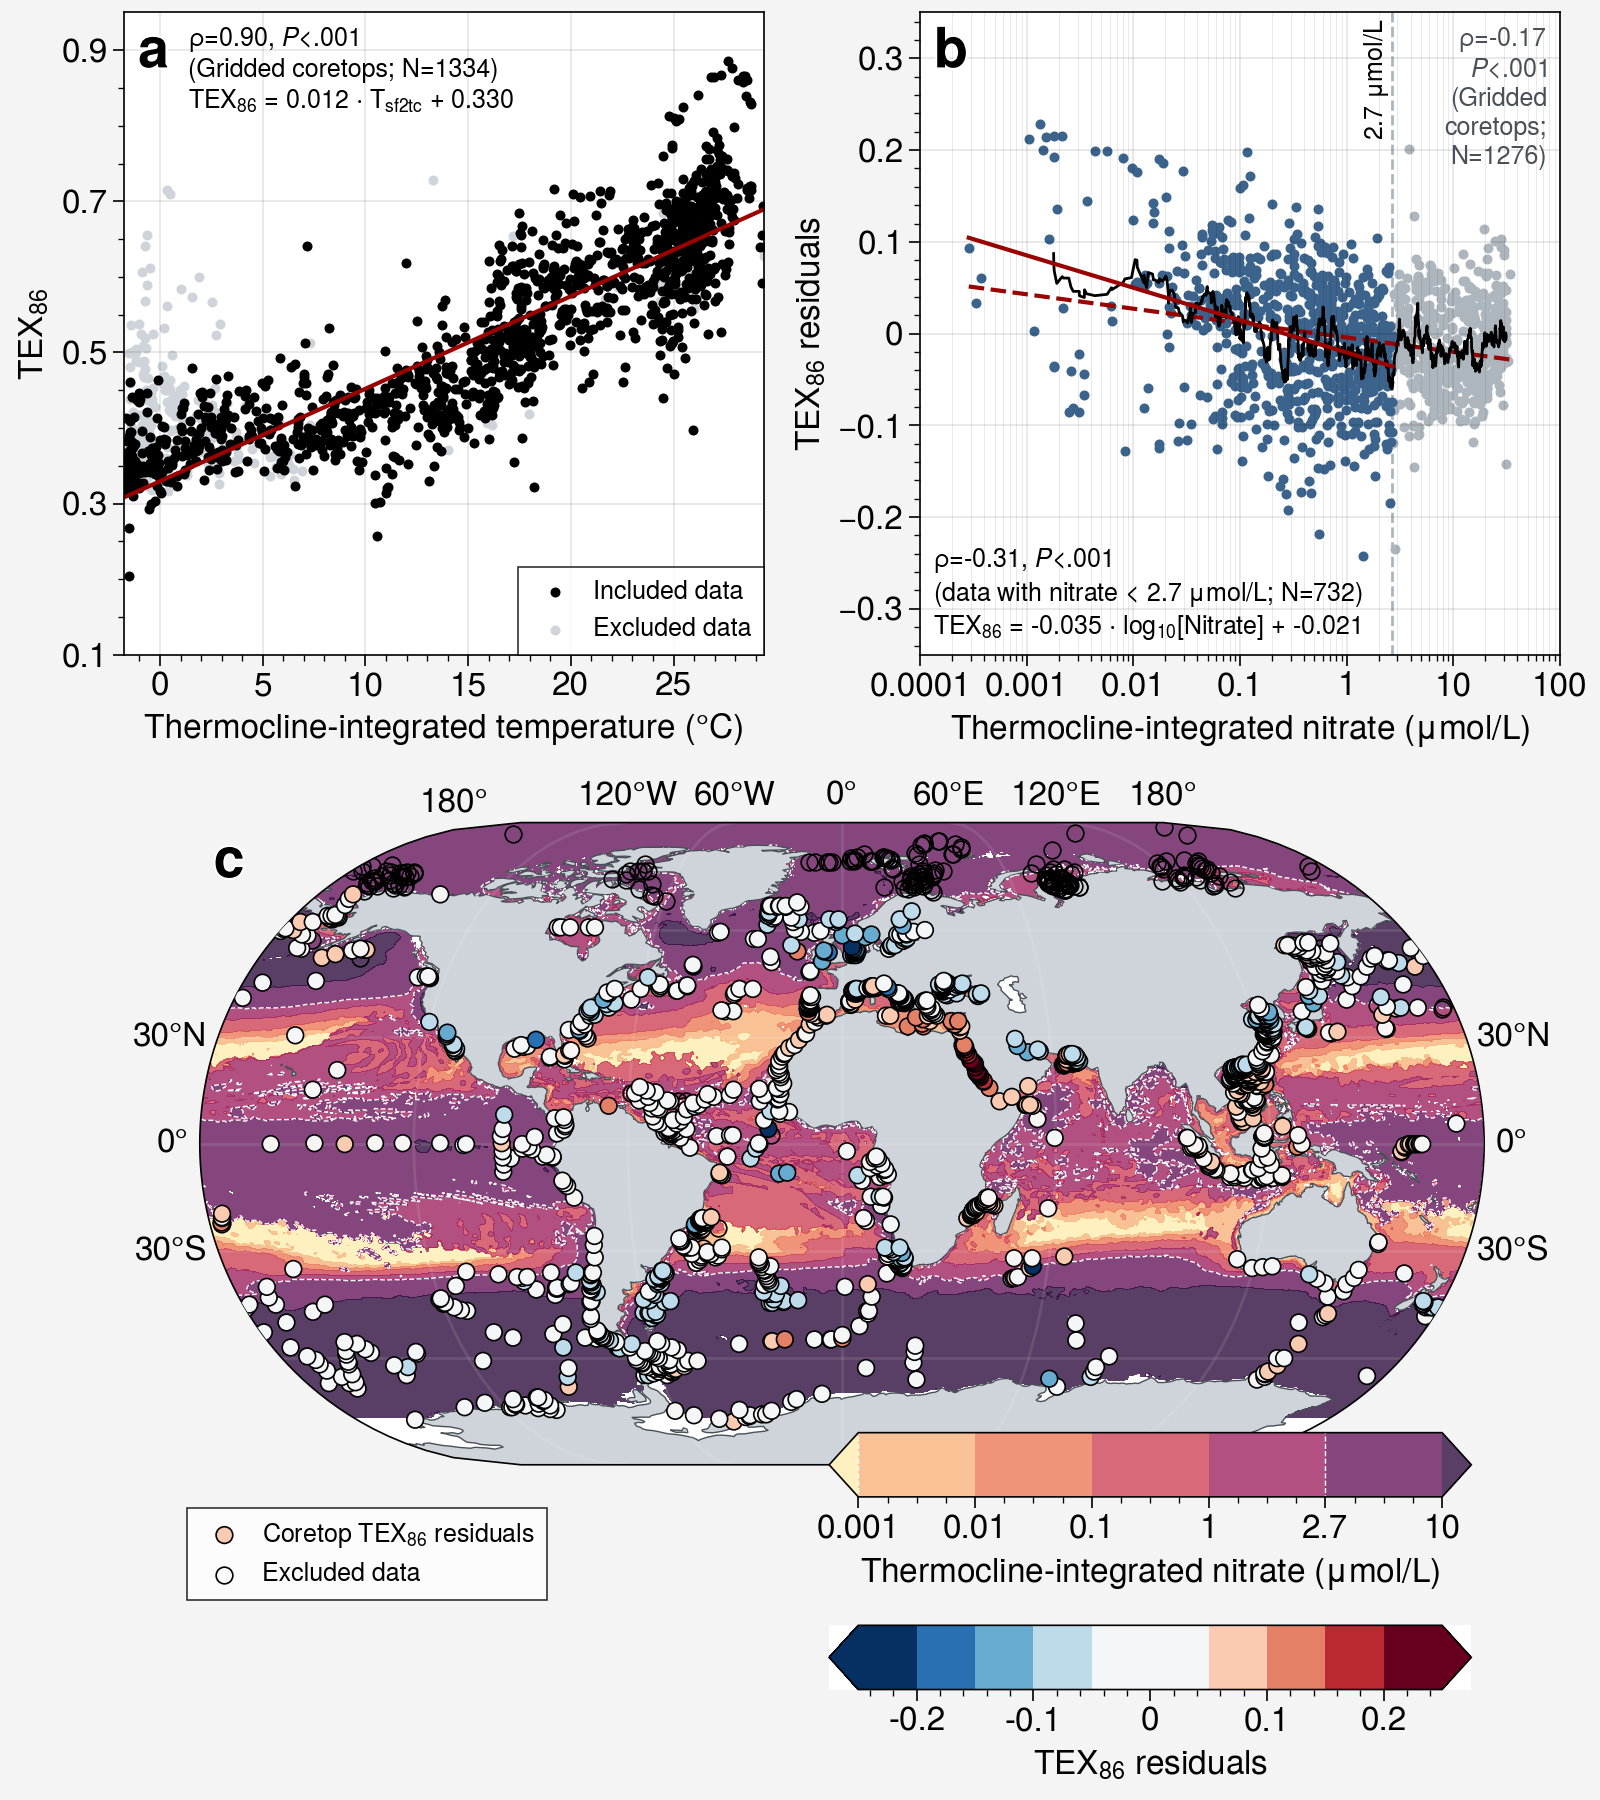

In [30]:
def running_mean_log10(x, y, window_size):
        # Convert x to log10 scale
        log_x = np.log10(x)
        
        # Create a DataFrame with log_x and y
        df = pd.DataFrame({'log_x': log_x, 'y': y})
        
        # Sort the DataFrame by log_x
        df = df.sort_values(by='log_x')
        
        # Calculate the running mean of y with the specified window size
        df['y_running_mean'] = df['y'].rolling(window=window_size, center=True).mean()
        
        return df['log_x'], df['y_running_mean']


plot_coretop = xr.merge([gridded_coretop_ds,t_sf2tc_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','t_sf2tc_avg']).reset_index(drop=True)
plot_coretop_no3 = xr.merge([gridded_coretop_ds,thermocline_nitrate_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','no3_sf2tc_avg']).reset_index(drop=True)

exclude_coretop = coretop_df[coretop_df['QC_flag']=='exclude']
array = [
    [1,2],
    [3,3]
]
projs = (None,None,'eck3')
fig, axs = plot.subplots(array,proj=projs,
                         figsize=(8,9),
                         share=False,
                         )

axs.format(fontsize=12)

ax = axs[0]
ax.format(
    xlabel='Thermocline-integrated temperature (\N{DEGREE SIGN}C)',
    ylabel='TEX$_{86}$'
)
plot_data = plot_coretop[plot_coretop['lat']<70].dropna(subset=['t_sf2tc_avg',
                                                  'tex_median']).reset_index()
plot_x = plot_data['t_sf2tc_avg']
plot_y = plot_data['tex_median']
ax.scatter(plot_x,plot_y,
           m='.',c='k',zorder=2,label='Included data')

plot_data = plot_coretop[plot_coretop['lat']>70].dropna(subset=['t_sf2tc_avg','tex_median'])
plot_x = plot_data['t_sf2tc_avg']
plot_y = plot_data['tex_median']
ax.scatter(plot_x,plot_y,
           m='.',c='gray4',zorder=1,
           label='Excluded data')

plot_x = exclude_coretop['thermocline_T_depthIntegral']
plot_y = exclude_coretop['TEX86']
ax.scatter(plot_x,plot_y,m='.',c='gray4',zorder=0,label='')

reg_data = plot_coretop[plot_coretop['lat']<70].dropna(subset=['t_sf2tc_avg','tex_median'])
reg_data2 = reg_data.dropna(subset=['t_sf2tc_avg','tex_median'])
ols_tex_thermoT_thisStudy = LinearRegression()
XX = reg_data2['t_sf2tc_avg']
yy = reg_data2['tex_median']
ols_tex_thermoT_thisStudy.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols_tex_thermoT_thisStudy.predict(XX_sample.reshape(-1,1))
ax.plot(XX_sample,yy_pred,c='deep red')
rho, pval = spearmanr(reg_data2['t_sf2tc_avg'],reg_data2['tex_median'])
### add linear regression equation as text in axs[0]
slope_text = f'{ols_tex_thermoT_thisStudy.coef_[0]:.3f}'
intercept_text = f'{ols_tex_thermoT_thisStudy.intercept_:.3f}'
equation_text = f'TEX$_{{86}}$ = {slope_text} $\cdot$ T$_{{sf2tc}}$ + {intercept_text}'

print(f'r2 score = {ols_tex_thermoT_thisStudy.score(XX.values.reshape(-1,1),yy)}')
pval_label = label_pvalues(pval)
ax.text(0.10,0.98,f'$\\rho$={rho:.2f}, {pval_label}\n(Gridded coretops; N={len(reg_data2)})\n{equation_text}',
        transform=ax.transAxes,
        ha='left',va='top')

h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='lr',ncols=1)
ax.format(
        ylim=(0.1,0.95),
        yticks=np.arange(0.1,1,0.2),
)
#########################################################################################
ax = axs[1]

plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70].dropna(subset=['no3_sf2tc_avg','tex_residuals'])
reg_data = plot_data
reg_data['log_thermocl_depthIntg_nitrate'] = np.log10(reg_data['no3_sf2tc_avg'])
reg_data['log_thermocl_depthIntg_nitrate'] = reg_data['log_thermocl_depthIntg_nitrate'].replace([-np.inf,np.inf],np.nan)
ols = LinearRegression()
XX = reg_data['log_thermocl_depthIntg_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
ax.plot(10**XX_sample,yy_pred,c='deep red',ls='--')
rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
ax.text(0.98,0.98,f'$\\rho$={rho:.2f}\n{pval_label}\n(Gridded\ncoretops;\nN={len(reg_data)})',
        transform=ax.transAxes,
        ha='right',va='top',
        c='gray7')

sel_x_param = 'no3_sf2tc_avg'
sel_y_param = 'tex_residuals'
### linear fit between log(nitrate) and TEX residuals
pre_reg_data = plot_data
pre_reg_data = pre_reg_data.sort_values(by=sel_x_param).reset_index(drop=True)

### determine best window size
window_size = np.arange(5,101,1)
score_list = []
pval_list = []
for sel_window_size in window_size:
        log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],sel_window_size)
        lowno3_threshold_tmp = 10**log_x[y_running_mean.idxmin()]
        reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold_tmp]
        rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
        score_list.append(rho)
        pval_list.append(pval)
best_window_size = window_size[np.argmin(score_list)]
# best_window_size = 100
print(f'best_window_size = {best_window_size}')
### find x value with minimum running mean of y
log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],best_window_size)
ax.axvline(10**log_x[y_running_mean.idxmin()],color='gray5',ls='--',lw=1,zorder=0)
lowno3_threshold = np.round(10**log_x[y_running_mean.idxmin()],decimals=1)
ax.text(lowno3_threshold-0.1,0.99,f'{lowno3_threshold:.1f} $\mu$mol/L',transform=ax.get_xaxis_transform(),
        ha='right',va='top',
        rotation=90)
ax.plot(10**log_x,y_running_mean,c='k',lw=1)

plot_x = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_x_param]
plot_y = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_y_param]
ax.scatter(plot_x,plot_y,marker='.',color='denim',label='Coretops')


plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70].dropna(subset=[sel_x_param,sel_y_param])
plot_x_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_x_param]
plot_y_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_y_param]
ax.scatter(plot_x_exclude,plot_y_exclude,
            marker='.',color='gray5',
            label='Excluded data',zorder=0)


reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold]

reg_data['log_'+sel_x_param] = np.log10(reg_data[sel_x_param])
reg_data['log_'+sel_x_param] = reg_data['log_'+sel_x_param].replace([-np.inf,np.inf],np.nan)
reg_data = reg_data.dropna(how='any',subset=[sel_x_param,sel_y_param,'log_'+sel_x_param])
ols = sm.OLS(reg_data[sel_y_param],sm.add_constant(reg_data['log_'+sel_x_param])).fit()
plot_x_fit = np.linspace(reg_data['log_'+sel_x_param].min(),reg_data['log_'+sel_x_param].max(),100)
plot_y_fit = ols.predict(sm.add_constant(plot_x_fit))
ax.plot(10**plot_x_fit,plot_y_fit,c='deep red',
        label='TEX residuals')

### print regression equation
slope_text = f'{ols.params[1]:.3f}'
intercept_text = f'{ols.params[0]:.3f}'
equation_text = f'TEX$_{{86}}$ = {slope_text} $\cdot$ log$_{{10}}$[Nitrate] + {intercept_text}'

rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
pval_label = label_pvalues(pval)
ax.text(0.02,0.02,
        f'$\\rho$={rho:.2f}, {pval_label}\n(data with nitrate < {lowno3_threshold:.1f} $\mu$mol/L; N={len(reg_data)})\n{equation_text}',
        transform=ax.transAxes,
        ha='left',va='bottom')



ax.format(
    xscale='log',
    xlim=(1e-4,1e2),
    xgridminor=True,
    ylim=(-0.35,0.35),
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals'
)
#########################################################################################
ax = axs[2]
ax.format(land=True, landcolor='gray4',landzorder=0,
        latlabels='lr', lonlabels='top',
        gridcolor='w',gridlinewidth=1,
        latlines=30,
        latlocator=[-60,-30,0,30,60],
        coast=True, coastcolor='gray7',
        coastlinewidth=0.5,
        coastzorder=1,
        labelsize=12)
##### plot a contour line of thermocline-integrated nitrate at lowno3_threshold μM
m = thermocline_nitrate_da.plot.contourf(ax=ax,levels=[1e-3,1e-2,1e-1,1,lowno3_threshold,10],
                                        cmap='matter',alpha=0.8,
                                        add_colorbar=False,robust=True,
                                        label=None,rasterized=True)

axins1 = inset_axes(
    ax,
    width="50%",
    height="10%",
    loc="lower right",
    bbox_to_anchor=(-0.01,-0.05,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)

axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",)
cbar.set_label('Thermocline-integrated nitrate ($\mu$mol/L)', size=12)
axins1.xaxis.set_ticklabels(['0.001','0.01','0.1','1',f'{lowno3_threshold}','10'])
cbar.ax.tick_params(labelsize=12)
m2 = thermocline_nitrate_da.plot.contour(ax=ax,levels=[0,lowno3_threshold],
                                                 linewidths=0.5,
                                                 linestyles='dashed',
                                                 colors='w',robust=True)
cbar.add_lines(m2)
cbar.lines[0].set_linestyle('dashed')

ax.set_title('')
###### plot tex residuals on map

plot_x = exclude_coretop['Longitude']
plot_y = exclude_coretop['Latitude']
ax.scatter(plot_x,plot_y,m='o',mec='k',facecolor='none',zorder=2,label='')

plot_data = plot_coretop[plot_coretop['lat']>70][['lon','lat','tex_median']].dropna(subset=['tex_median'])
plot_x = plot_data['lon']
plot_y = plot_data['lat']
ax.scatter(plot_x,plot_y,
           m='o',mec='k',facecolor='none',zorder=2,
           label='Excluded data')

plot_data = plot_coretop[plot_coretop['lat']<70][['lon','lat','tex_residuals']].dropna()
plot_x = plot_data['lon']
plot_y = plot_data['lat']
plot_c = plot_data['tex_residuals']

norm = FlatCenterNormalize(vmin=-0.2, vmax=0.2, center=0, plateau_width=0.025)
m=ax.scatter(plot_x,plot_y,
           c=plot_c, 
           norm=norm,
           mec='k',
           levels=10,
        #    levels=np.arange(-0.2,0.21,0.02),
           transform=ccrs.PlateCarree(),
           m='o',cmap='burd',
           label='Coretop TEX$_{86}$ residuals',
           zorder=3)

h,l = axs[2].get_legend_handles_labels()

ax.legend(h[::-1],l[::-1],loc='lower left',
          bbox_to_anchor=(-0.01,-0.21,1,1),
          ncols=1)

axins1 = inset_axes(
    ax,
    width="50%",
    height="10%",
    loc="lower right",
    bbox_to_anchor=(-0.01,-0.35,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             extend='both')
cbar.set_label('TEX$_{86}$ residuals', size=12)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks(np.arange(-0.2,0.21,0.1))
cbar.ax.xaxis.set_ticklabels(['-0.2','-0.1','0','0.1','0.2'])



#########################################################################################
axs.format(abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20},)


fpath = fr'{local_github_path}/figures/'
fname = 'gridded_coretops_regression_nitrate_effect_global.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=660)

### Fig. S4 Sliding Window for low-nutrient threshold

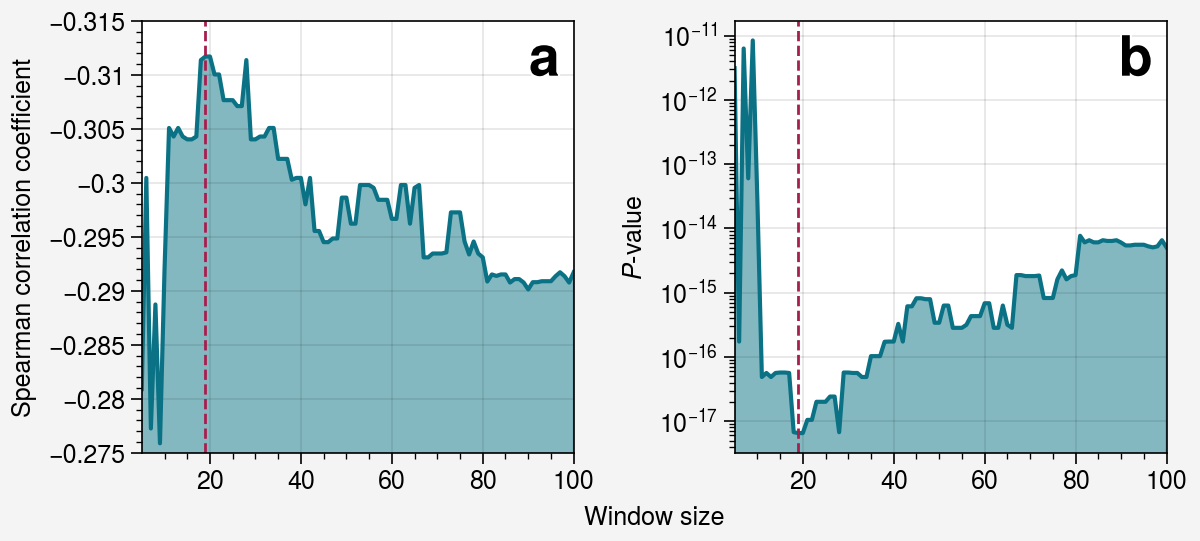

In [31]:
fig, axs = plot.subplots(width=6,ncols=2,sharey=0)
window_size_score_df = pd.DataFrame({'window_size':window_size,
                                     'score':score_list,
                                     'pval':pval_list})

ax = axs[0]
### fill_between y
ax.fill_between(window_size_score_df['window_size'],window_size_score_df['score'],
                color='cyan9',alpha=0.5)
ax.plot(window_size_score_df['window_size'],window_size_score_df['score'],c='cyan9')

ax.format(
    xlabel='Window size',
    ylabel='Spearman correlation coefficient',
    ylim=(-0.275,-0.315)
)

ax = axs[1]
### fill_between y
ax.fill_between(window_size_score_df['window_size'],window_size_score_df['pval'],
                color='cyan9',alpha=0.5)
ax.plot(window_size_score_df['window_size'],window_size_score_df['pval'],c='cyan9')

ax.format(
    xlabel='Window size',
    ylabel=r'$\it{P}$-value',
    yscale='log',
    yformatter='log',
)

#### ax.axvline at the highest score and lowest pval
best_window_size = window_size[np.argmin(score_list)]
axs.axvline(best_window_size,c='pink9',ls='--',lw=1)
# ax.text(best_window_size,0.98,f'{best_window_size}',transform=ax.get_yaxis_transform(),
#         ha='center',va='top',rotation=90)

#########################################################################################
axs.format(abc=True,abcloc='ur',abcstyle='a',rc_kw={'abc.size':20},)

fpath = fr'{local_github_path}/figures/'
fname = 'Fig_S4_sliding_window_scores.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=660)

## Fig. 2: Regional nutrient effects

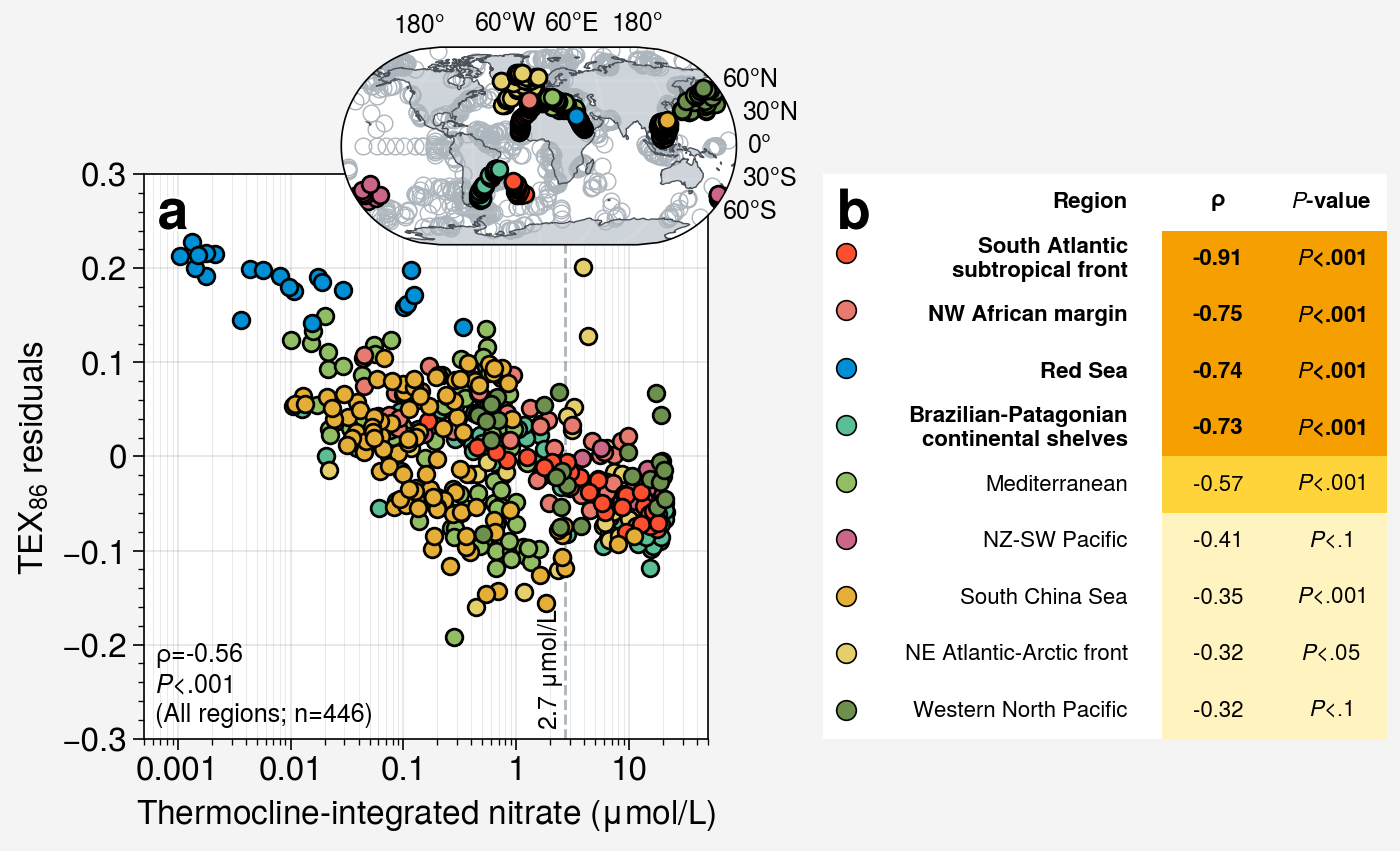

In [32]:
# array = [
#     [1,1,2,2],
#     [1,1,2,2]
# ]
cyc1 = plot.get_colors('qual1',N=5)
cyc2 = plot.get_colors('538',N=5)

sel_cyc = plot.Cycle(cyc1+cyc2)
### param for plotting
optimal_pval_cutoff = 0.1
nitrate_cutoff = 100

fig, axs = plot.subplots(ncols=2,
                         share=0,
                         width=7)
axs.format(fontsize=12)
plot_data = xr.merge([gridded_coretop_ds,t_sf2tc_da,thermocline_nitrate_da,coretop_gridded_d15N_ds])
plot_gridded_data = plot_data[['lat','lon','t_sf2tc_avg','no3_sf2tc_avg',
                                'tex_median','tex_residuals','tex_std',
                                'd15N_mean','region_ID']].to_dataframe().dropna(subset=['region_ID']).reset_index()
plot_gridded_data['regionName'] = plot_gridded_data['region_ID'].map(regionID_to_regionName_dict)
plot_gridded_data['regionName'] = plot_gridded_data['regionName'].replace({
    'Eastern Indian Ocean (Offshore Indonesia)' : 'Indonesian Offshore',
    'Northern Pacific':'Western North Pacific',
    'Eastern South America Offshore':'Brazilian-Patagonian\ncontinental shelves',
    'South Atlantic Gyre':'South Atlantic\nsubtropical front',
    'Tropical West African Offshore':'NW African margin',
    'North Atlantic':'NE Atlantic-Arctic front',
})

plot_gridded_data = plot_gridded_data[plot_gridded_data['no3_sf2tc_avg']<nitrate_cutoff]

# Create an inset axis overlapping on the top right corner of axs[0]
ax_inset = axs[0].inset_axes([0.35, 0.7, 0.7, 0.7],proj='eck3')

ax_inset.format(land=True, landcolor='gray4',landzorder=0,
        latlabels='r', lonlabels='top',
        gridcolor='w',gridlinewidth=1,
        latlocator=[-60,-30,0,30,60],
        coast=True, coastcolor='gray7',
        coastlinewidth=0.5,
        coastzorder=1,)
grouped = plot_gridded_data.groupby('regionName')

#### calculate rho and pval between tex_residuals and thermocl_depthIntg_nitrate by regions
rho_list = []
pval_list = []
region_name_list = []
for name, group in grouped:
    reg_data = group[['no3_sf2tc_avg', 'tex_residuals']].dropna()
    if len(reg_data) < 10:
        continue
    else:
        rho, pval = spearmanr(reg_data['no3_sf2tc_avg'], reg_data['tex_residuals'])
        rho_pearson, pval_pearson = pearsonr(reg_data['no3_sf2tc_avg'], reg_data['tex_residuals'])
        region_name_list.append(name)
        rho_list.append(rho)
        pval_list.append(pval)

### build a dataframe to sort by rho
rho_df = pd.DataFrame({'regionName': region_name_list,
                       'rho': rho_list,
                       'pval': pval_list})

sig_regions_ = rho_df[((rho_df['pval'] < optimal_pval_cutoff)
                       & (rho_df['rho'] < 0))]

sig_regions_ = rho_df[((rho_df['pval'] < optimal_pval_cutoff)
                       & (rho_df['rho'] < 0))][rho_df['regionName'].isin([
                           'Weddell Sea', 'Arctic Ocean', 'Drake Passage',
                           'Kara Sea', 'Greenland Sea',
                           'Laptev Sea',
                           'Sea of Okhotsk',
                        #    'Eastern South America Offshore_far'
                           ]) == False]
sig_regions_color_dict = dict(zip(sig_regions_['regionName'], plot.get_colors(sel_cyc, N=len(sig_regions_))))

for name, group in grouped:
    ### check rho and pval of each region
    if name not in sig_regions_['regionName'].unique():
        ax_inset.scatter(group['lon'], group['lat'],
                         c='none',
                         mec='gray5', mew=0.5,
                         label=name,
                         zorder=1)
    else:
        rho_ = rho_df[rho_df['regionName'] == name]['rho'].values[0]
        pval_ = rho_df[rho_df['regionName'] == name]['pval'].values[0]

        if (pval_ < optimal_pval_cutoff
            and (rho_ < 0)
            and name != 'Weddell Sea'
            and name != 'Arctic Ocean'
            and name != 'Drake Passage'
            and name != 'Kara Sea'
            and name != 'Greenland Sea'
            and name != 'Laptev Sea'
            and name != 'Sea of Okhotsk'
            # and name != 'Eastern South America Offshore_far'
            ):
            ax_inset.scatter(group['lon'], group['lat'],
                            #  cycle=sel_cyc,
                             c=sig_regions_color_dict.get(name, 'gray5'),
                             mec='k', mew=1,
                             label=name,
                             zorder=2)
            
ax = axs[0]
sig_plot_data = plot_gridded_data[plot_gridded_data['regionName'].isin(sig_regions_['regionName'])]
grouped = sig_plot_data.groupby('regionName')   
for name, group in grouped:
    ### plot data
    ax.scatter(group['no3_sf2tc_avg'],group['tex_residuals'],
                cycle=sel_cyc,
                mec='k',mew=1,
                label=name,
                zorder=2)
    
### add low-nitrate threshold
ax.axvline(lowno3_threshold,color='gray5',ls='--',lw=1,zorder=0)
### add vertical text 
x_pos = lowno3_threshold
y_pos = -0.29
ax.text(x_pos,y_pos,f'{lowno3_threshold:.1f} $\mu$mol/L',
        # transform=ax.get_xaxis_transform(),
        ha='right',va='bottom',
        rotation=90)
    
### ols regression of all significant regions
reg_data = sig_plot_data[['no3_sf2tc_avg','tex_residuals']].dropna()
reg_data['Log10_nitrate'] = np.log10(reg_data['no3_sf2tc_avg'])
ols = LinearRegression()
XX = reg_data['Log10_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
# ax.plot(10**XX_sample,yy_pred,c='deep red')
### spearman rho and pval
rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
ax.text(0.02,0.02,f'$\\rho$={rho:.2f}\n{pval_label}\n(All regions; n={len(reg_data)})',
        transform=ax.transAxes,
        ha='left',va='bottom')

### orthoganal distance regression 
X = reg_data['Log10_nitrate']
y = reg_data['tex_residuals']
covx = np.cov(X)
covy = np.cov(y)
odr_dat = scipy.odr.Data(X,y)
def linear_func(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]
odr_func = scipy.odr.Model(linear_func)
odr = scipy.odr.ODR(odr_dat,odr_func,beta0=[-2.,0.2])
out = odr.run()
slope = out.beta[0]
intercept = out.beta[1]
X_pred = np.linspace(X.min(),X.max(),100)
y_pred = linear_func(out.beta,X_pred)
# ax.plot(10**X_pred,y_pred,c='k',ls='--',lw=2,label='ODR fit')

ax.format(
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals',
    xlim=(5e-4,5e1),
    xscale='log',
    xgridminor=True,
    ylim=(-0.3,0.3),
)


axs.format(
    abc='a',rc_kw={'abc.size':20},abcloc='ul',
)

### plot a table reporting rho and pval of significant regions
table_ax = axs[1]
table_ax.axis('off')
table_data = sig_regions_[['regionName','rho','pval']]

### formatted values to be displayed in the table as 4 significant figures
table_data['rho'] = table_data['rho'].apply(lambda x: f'{x:.2f}')
table_data['pval'] = table_data['pval'].apply(lambda x: f'{x:.4f}')
table_data['pval_labels'] = table_data['pval'].apply(lambda x: label_pvalues(float(x)))
table_data = table_data.rename(columns={'regionName':'Region',
                                        'rho':'$\\rho$',
                                        'pval_labels':r'$\it{P}$-value'})


table_data2 = table_data[['Region','$\\rho$',r'$\it{P}$-value']].sort_values(by='$\\rho$',ascending=False).copy()
### color cell with rho < -0.7
### set header text bold
### set header background color
# Define the number of rows and columns in the table
num_rows, num_cols = table_data2.shape

# Create a list for cell colors, keeping the first column (Region) white
cell_colors = [['white'] * num_cols for _ in range(num_rows)]

# Apply colors only to the second and third columns based on rho values
for i, rho in enumerate(table_data2['$\\rho$']):
    rho_value = float(rho)
    color = (
        'yellow7' if rho_value < -0.7 else 
        'yellow4' if rho_value < -0.5 else 
        'yellow1'
    )
    cell_colors[i][1] = color  # Apply color to the rho column
    cell_colors[i][2] = color  # Apply the same color to the p-value column

table = table_ax.table(cellText=table_data2.values,
                colLabels=table_data2.columns,
                loc='top',
                bbox=[0,0,1,1],
                colWidths=[0.6,0.2,0.2],
                cellColours=cell_colors,
                fontsize=12
                )

# Style table text
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header row
        cell.get_text().set_fontweight('bold')
    if col == 0:
        cell.get_text().set_ha('right')  # Align first column to the right
        if row > 0:
            region_name = table_data2.iloc[row-1]['Region'][2:]  
    else:
        cell.get_text().set_ha('center')
        if col == 1 and row > 0:
            if float(cell.get_text().get_text()) < -0.7:
                table[(row, 0)].get_text().set_fontweight('bold')
                table[(row, 1)].get_text().set_fontweight('bold')                
                table[(row, 2)].get_text().set_fontweight('bold')
    
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.5, 1.5)
#change table line color to white
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)

# Add colored markers manually using scatter()
num_rows = len(table_data2)
x_offset = -0.15  # Adjust this to position the circles
y_offset = np.linspace(0.86, 0.05, num_rows)  # Evenly space markers in the column

for i, region in enumerate(table_data2['Region']):
    color = sig_regions_color_dict.get(region, 'black')  # Default to black if not found
    table_ax.scatter(x_offset, y_offset[i], color=color, s=50, edgecolor='k', zorder=3)
    


table_ax.set_xlim(-0.2, 1)  # Adjust limits to ensure markers are visible
table_ax.set_ylim(0, 1)

fpath = fr'{local_github_path}/figures/'
fname = 'gridded_regional_nitrate_effect_sig_regions.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=1440)

## Fig. 3: Paleo case study - Arabian Sea

In [33]:
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'Seierstad2014_NGRIP_d18O_dataset.xlsx'

### data sheet name is "4) d18O and Ca 50 yrs mean"
### data starts from line 6
### header is in line 4
ngrip_df = pd.read_excel(os.path.join(fpath,fname),sheet_name="3) d18O and Ca 20 yrs mean",skiprows=51)

### grab column names from line 4 in the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name="3) d18O and Ca 20 yrs mean",skiprows=49)
header = header.iloc[0,:].values

### add column names to dataframe
ngrip_df.columns = header
ngrip_df = ngrip_df[ngrip_df['Age']<20000]
ngrip_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1997 entries, 0 to 1996
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            1997 non-null   int64  
 1   NGRIP1 depth   980 non-null    float64
 2   d18O NGRIP1    980 non-null    float64
 3   NGRIP2 depth   1045 non-null   float64
 4   d18O NGRIP2    1045 non-null   float64
 5   [Ca2+] NGRIP2  965 non-null    float64
 6   GRIP depth     1997 non-null   float64
 7   d18O GRIP      1997 non-null   float64
 8   [Ca2+] GRIP    1201 non-null   float64
 9   GISP2 depth    1989 non-null   float64
 10  d18O GISP2     1951 non-null   float64
 11  [Ca2+] GISP2   1989 non-null   float64
 12  MCE            1997 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 218.4 KB


In [34]:
import bayspline as bsl

#### read data from tab file to pandas dataframe; data starts after the last line with */

fpath = fr'{local_github_path}/spreadsheets/published_data/Huguet2006_ArabianSea_paleorecords'
fname = 'SO42-74KL_SST.tab'

with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if line.startswith('*/'):
        break
# header = lines[i+1].split()
data = lines[i+2:]
data = [line.split() for line in data]
df = pd.DataFrame(data,columns=['Age_kaBP','SST_UK37','SST_TEX86'])
SO42_75KL_SST_df = df.apply(pd.to_numeric,errors='ignore')
SO42_75KL_SST_df['uk37'] = 0.033*SO42_75KL_SST_df['SST_UK37']+0.044
SO42_75KL_SST_df['sst'] = bsl.predict_sst(SO42_75KL_SST_df['uk37'], prior_std=10).percentile(50)
SO42_75KL_SST_df

100%|██████████| 500/500 [00:06<00:00, 73.96it/s]


Age_kaBP  SST_UK37  SST_TEX86   uk37     sst
0     0.2000   27.3000    26.3900 0.9449 28.4982
1     0.4000   27.3600    27.4700 0.9469 28.6292
2     0.6000   27.2700    27.1300 0.9439 28.4515
3     0.8200   27.3600    26.8200 0.9469 28.6463
4     1.0300   27.1200    27.8100 0.9390 28.1285
..       ...       ...        ...    ...     ...
71   20.2900   25.1200    25.2100 0.8730 24.7734
72   20.9000   24.8500    23.9300 0.8641 24.4000
73   21.5000   25.0900    23.7800 0.8720 24.7265
74   22.1100   25.1500    25.0200 0.8740 24.7926
75   22.7200   25.2400    24.5900 0.8769 24.9372

[76 rows x 5 columns]

In [35]:
#### read data from tab file to pandas dataframe; data starts after the last line with */

fpath = fr'{local_github_path}/spreadsheets/published_data/Huguet2006_ArabianSea_paleorecords'
fname = 'NIOP-C2_905_PC_SST.tab'

with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if line.startswith('*/'):
        break
# header = lines[i+1].split()
data = lines[i+2:]
data = [line.split() for line in data]
df = pd.DataFrame(data,columns=['Age_kaBP','SST_UK37','SST_TEX86'])
NIOP905_SST_df = df.apply(pd.to_numeric,errors='ignore')
NIOP905_SST_df ['uk37'] = 0.033*NIOP905_SST_df['SST_UK37']+0.044
NIOP905_SST_df ['sst'] = bsl.predict_sst(NIOP905_SST_df['uk37'], prior_std=10).percentile(50)
NIOP905_SST_df

100%|██████████| 500/500 [00:07<00:00, 68.99it/s]


Age_kaBP  SST_UK37  SST_TEX86   uk37     sst
0      0.0190   26.3000    25.7100 0.9119 26.5692
1      0.2080   26.3300    26.2400 0.9129 26.6511
2      0.3970   26.3300    25.7900 0.9129 26.6816
3      0.5860   26.4900    26.0900 0.9182 26.9585
4      0.7820   26.4200    26.4200 0.9159 26.8231
..        ...       ...        ...    ...     ...
106   21.9060   25.0900    22.5900 0.8720 24.7468
107   22.1640   25.4900    22.4700 0.8852 25.3034
108   22.4220   25.3900        NaN 0.8819 25.1477
109   22.6800   25.7700        NaN 0.8944 25.7223
110   22.9380   25.5200        NaN 0.8862 25.3441

[111 rows x 5 columns]

In [36]:
NIOP905_SST_df

Age_kaBP  SST_UK37  SST_TEX86   uk37     sst
0      0.0190   26.3000    25.7100 0.9119 26.5692
1      0.2080   26.3300    26.2400 0.9129 26.6511
2      0.3970   26.3300    25.7900 0.9129 26.6816
3      0.5860   26.4900    26.0900 0.9182 26.9585
4      0.7820   26.4200    26.4200 0.9159 26.8231
..        ...       ...        ...    ...     ...
106   21.9060   25.0900    22.5900 0.8720 24.7468
107   22.1640   25.4900    22.4700 0.8852 25.3034
108   22.4220   25.3900        NaN 0.8819 25.1477
109   22.6800   25.7700        NaN 0.8944 25.7223
110   22.9380   25.5200        NaN 0.8862 25.3441

[111 rows x 5 columns]

In [37]:
slope = ols_tex_thermoT_thisStudy.coef_[0]
intercept = ols_tex_thermoT_thisStudy.intercept_

fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'PhanSST_v001.csv'
PhanSST_df = pd.read_csv(os.path.join(fpath,fname))
PhanTEX_df = PhanSST_df[PhanSST_df['ProxyType']=='tex'].reset_index(drop=True)

NIOP905_tex_df = PhanSST_df[PhanSST_df['SiteName']=='NIOP-C2_905_PC'].reset_index(drop=True)
NIOP905_tex_df['SST'] = (NIOP905_tex_df['ProxyValue'] - intercept)/slope

SO42_75KL_tex_df = PhanSST_df[PhanSST_df['SiteName']=='SO42-74KL'].reset_index(drop=True)
SO42_75KL_tex_df['SST'] = (SO42_75KL_tex_df['ProxyValue'] - intercept)/slope

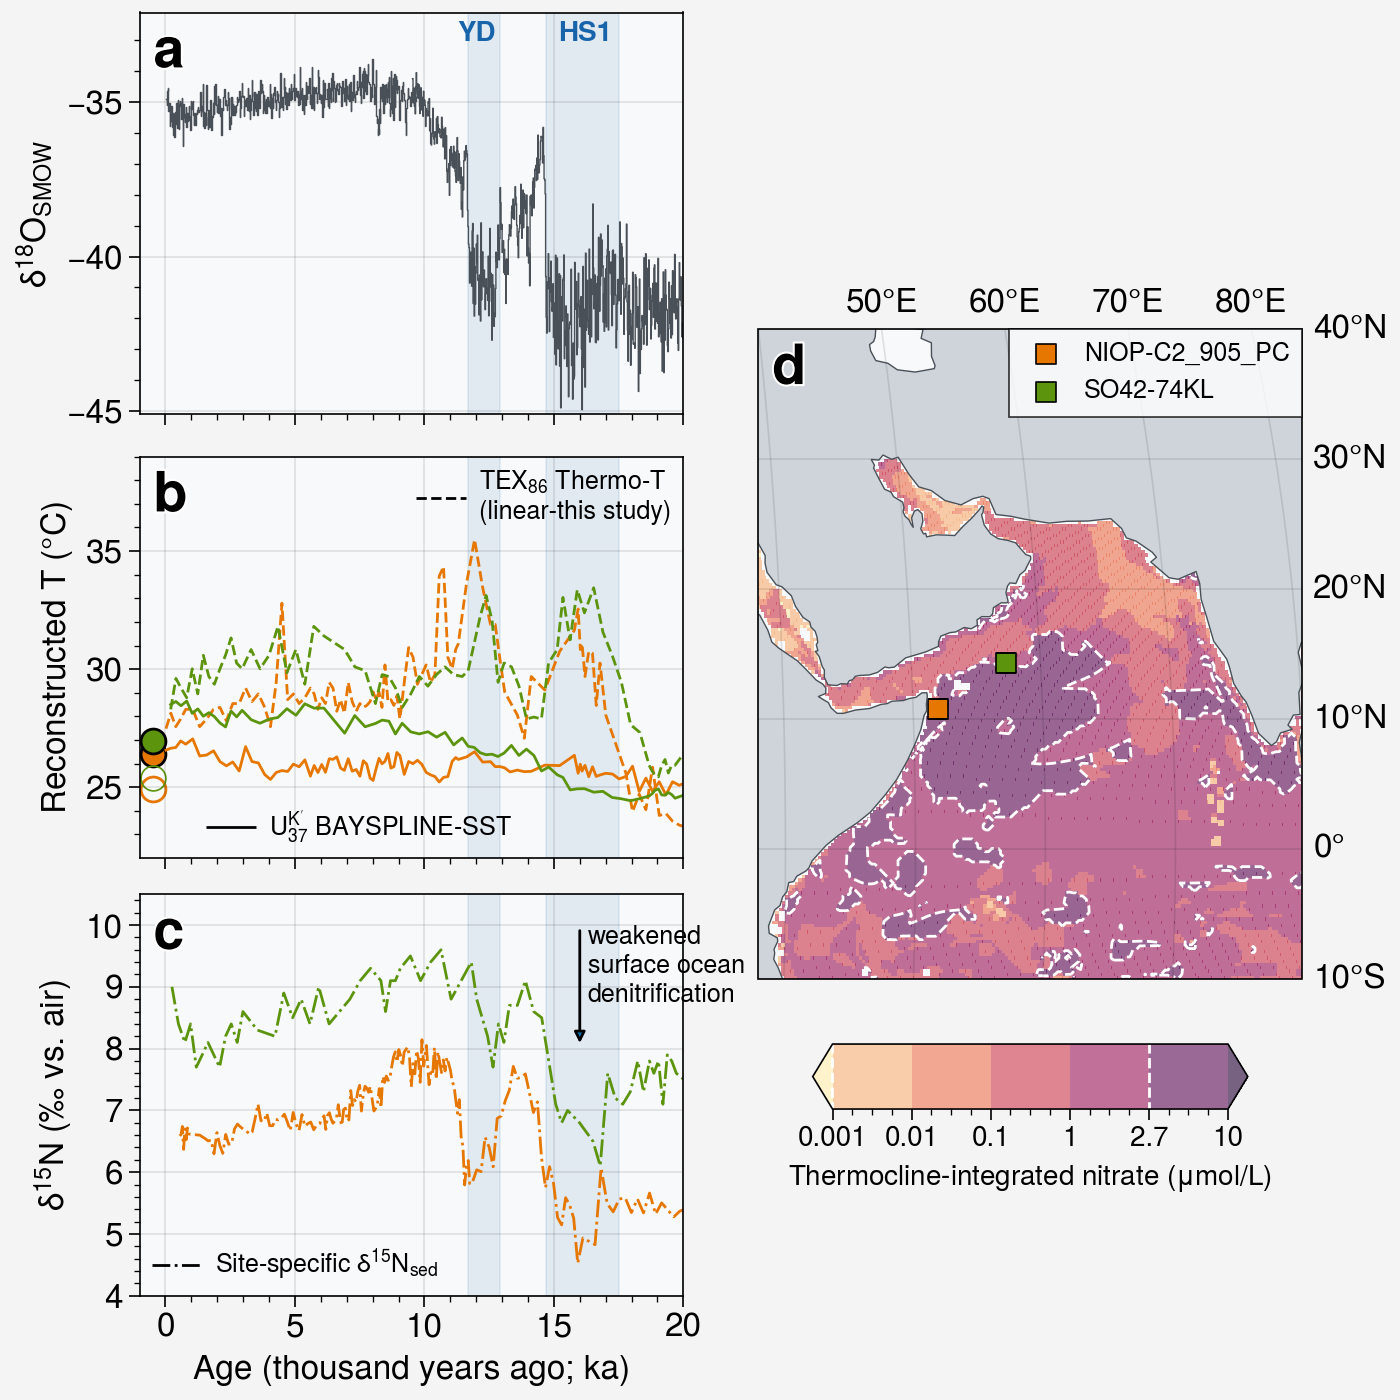

In [38]:
array = [
    [1,1,4,4],
    [2,2,4,4],
    [3,3,4,4],
]
fig, axs = plot.subplots(
    array,
    figsize=(7,7),
    share=0,
    wspace=3,
    proj=(None,None,None,'eck3')
    )

axs.format(facecolor='gray0',fontsize=12)
########## site locations
ax = axs[3]
ax.format(land=True,landcolor='gray4',landzorder=0,
          coast=True,coastcolor='gray7',coastlinewidth=0.5,
          latlim=(-10,40),lonlim=(40,80),
          latlabels='r',lonlabels='t',
          labelsize=12,latlines=10,lonlines=10,)


### lat lon for NIOP-C2_905_PC = 10.767N,51.95E
### lat lon for SO42-74KL = 14.321N, 57.347E
ax.scatter(51.95,10.767,c='yellow9',
           mec='k',marker='s',s=50,
           label='NIOP-C2_905_PC',
           zorder=2)

ax.scatter(57.347,14.321,c='lime9',
           mec='k',marker='s',s=50,
           label='SO42-74KL',
           zorder=2)
### plot sst and thermoT of modern sst for two core locations
NIOP905_today_sst = T_da.isel(depth=0).sel(lat=10.767,lon=51.95,method='nearest').values
axs[1].scatter(-0.5,NIOP905_today_sst, c='yellow9', mec='k', mew=1, marker='o',s=80, clip_on=False)
NIOP905_today_thermoT = t_sf2tc_da.sel(lat=10.767,lon=51.95,method='nearest').values
axs[1].scatter(-0.5,NIOP905_today_thermoT, facecolor='none', mec='yellow9', mew=1, marker='o',s=80, clip_on=False)

SO42_today_sst = T_da.isel(depth=0).sel(lat=14.321,lon=57.347,method='nearest').values
axs[1].scatter(-0.5,SO42_today_sst, c='lime9', mec='k', mew=1, marker='o',s=80, clip_on=False)
SO42_today_thermoT = t_sf2tc_da.sel(lat=14.321,lon=57.347,method='nearest').values
axs[1].scatter(-0.5,SO42_today_thermoT, facecolor='none', mec='lime9',marker='o',s=80, clip_on=False)

### plot modern d15N for arabian sea regions

plot_data = coretop_gridded_d15N_ds.sel(lat=slice(10,20),
                                        lon=slice(50,60)
                                        ).to_dataframe().dropna(subset=['d15N_mean']).reset_index()

m=thermocline_nitrate_da.sel(lat=slice(-10,30),lon=slice(25,90)).plot(ax=ax,
                                                                    zorder=0,
                                                                    levels=[1e-3,1e-2,1e-1,1,lowno3_threshold,10],
                                                                    cmap='matter',
                                                                    add_colorbar=False,
                                                                    alpha=0.65,
                                                                    rasterized=True)
ax.set_title('')
### plot the lowno3_threshold μM contour line
m2=thermocline_nitrate_da.sel(lat=slice(-10,30),lon=slice(25,90)
                                       ).plot.contour(ax=ax,levels=[0,lowno3_threshold],
                                                        zorder=1,
                                                        linewidths=1,
                                                        linestyles='dashed',
                                                        colors='w',robust=True)

axins1 = inset_axes(
    ax,
    width="80%",
    height="10%",
    loc="lower center",
    bbox_to_anchor=(0,-0.2,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)

axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             extend='both'
             )
cbar.set_label('Thermocline-integrated nitrate ($\mu$mol/L)', size=10)
cbar.ax.tick_params(labelsize=10)
cbar.add_lines(m2)
cbar.lines[0].set_linestyle('dashed')
axins1.xaxis.set_ticklabels(['0.001','0.01','0.1','1',f'{lowno3_threshold}','10'])

###### time series plot
ax = axs[0]
ax.format(
    ylabel='$\delta^{18}$O$_{SMOW}$',
)
plot_data = ngrip_df.dropna(how='all',subset=['d18O NGRIP1']).reset_index(drop=True)
plot_x = plot_data['Age']/1000
plot_y = plot_data['d18O NGRIP1']
ax.plot(plot_x,plot_y,c='gray7',lw=0.5,label='NGRIP')

plot_data = ngrip_df.dropna(how='all',subset=['d18O NGRIP2']).reset_index(drop=True)
plot_x = plot_data['Age']/1000
plot_y = plot_data['d18O NGRIP2']
ax.plot(plot_x,plot_y,c='gray7',lw=0.5,label='')


ax = axs[1]
ax.format(
    ylabel='Reconstructed T ($\degree$C)',
    yticks=[25,30,35],
)
plot_data = NIOP905_SST_df
plot_x = plot_data['Age_kaBP']
plot_y = plot_data['sst']
ax.plot(plot_x,plot_y,c='yellow9',lw=1)

plot_data = NIOP905_tex_df
plot_x = plot_data['Age']*1000
plot_y2 = plot_data['SST']
ax.plot(plot_x,plot_y2,c='yellow9',ls='--',lw=1)

plot_data = SO42_75KL_SST_df 
plot_x = plot_data['Age_kaBP']
plot_y = plot_data['sst']
ax.plot(plot_x,plot_y,c='lime9',lw=1)

plot_data = SO42_75KL_tex_df
plot_x = plot_data['Age']*1000
plot_y2 = plot_data['SST']
ax.plot(plot_x,plot_y2,c='lime9',ls='--',lw=1)

#### plotting d15N data


ax = axs[2]
ax.format(
    ylabel='$\delta^{15}$N (‰ vs. air)',
    ylim=(4,10.5)
)
    
#### add an arrow with annotation showing reduced denitrification during YD and HS1
ax.annotate('',
            xy=(16,10),xytext=(16,8),
            arrowprops=dict(arrowstyle='<|-',lw=1),
            ha='center',va='center',fontsize=8)
ax.text(16.3,10,'weakened\nsurface ocean\ndenitrification',
        ha='left',va='top',fontsize=9)

sel_sites = ['NIOP 905','SO42-74KL']
sel_colors = ['yellow9','lime9']
plot_data = downcore_d15N_df[downcore_d15N_df['core_name'].isin(sel_sites)].dropna(subset=['Age','d15N'])
grouped = plot_data.groupby('core_name')
for name, group in grouped:
    group = group.sort_values(by='Age').reset_index(drop=True)
    plot_x = group['Age']
    plot_y = group['d15N']
    ax.plot(plot_x,plot_y,
            c=sel_colors[sel_sites.index(name)],
            lw=1,ls='-.',label='site-specific $\delta^{15}$N$_{sed}$')

#### add shaded area highlighting Younger Dryas (YD; 12.9-11.7 ka) and Heinrich stadial 1 (HS1; 16.9-14.5 ka) for all plots
for ax in axs[:3]:
    ax.axvspan(11.7,12.9,color='blue9',alpha=0.1)
    ax.axvspan(14.7,17.5,color='blue9',alpha=0.1)
### add text labels for YD and HS1 at the top of subplot A
ax = axs[0]
ax.text(0.62,0.98,'YD',transform=ax.transAxes,
        ha='center',va='top',color='blue9',
        fontsize=10,fontweight='bold')
ax.text(0.82,0.98,'HS1',transform=ax.transAxes,
        ha='center',va='top',color='blue9',
        fontsize=10,fontweight='bold')



############################################################

h, l = axs[1].get_legend_handles_labels()
h2, l2 = axs[2].get_legend_handles_labels()
h3,l3 = axs[-1].get_legend_handles_labels()


axs[1].legend(h[1],loc='ur',c='k',
              frameon=False,
              ncols=1,
              bbox_to_anchor=(0,0,1,1),
              labels=['TEX$_{86}$ Thermo-T\n(linear-this study)'],
              fontsize=8,
              )
axs[1].legend(h[0],loc='ll',c='k',
              frameon=False,
              ncols=1,
              bbox_to_anchor=(0.1,0,1,1),
              labels=["U$^{K'}_{37}$ BAYSPLINE-SST"],
              fontsize=8,
              )


axs[2].legend([h2[i] for i in [1]],
              loc='ll',ncols=1,
              c='k',
              frameon=False,
              labels=['Site-specific $\delta^{15}$N$_{sed}$']
              )

axs[-1].legend(h3,loc='upper right',ncol=1,
               bbox_to_anchor=(0,0,1,1),
               labels=['NIOP-C2_905_PC','SO42-74KL'],)


## set the color for the first two marker elements as black

axs.format( abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20})

axs[:,0].format(
    xlim=(-1,20),
    xlabel='Age (thousand years ago; ka)',
)

axs[:2,0].format(
    xlabel='',
    xticklabels=[],
)
### set ylims for each plot
axs[0].format(ylim=(-45.1,-32.1),yticks=[-45,-40,-35])
axs[1].set_ylim(22,39)
plt.show()

fpath = fr'{local_github_path}/figures/'
fname = 'paleo_showcase_ArabianSea.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=660)

## Fig. 4: Paleo case study - Tasman Sea

In [39]:
fpath = fr'{local_github_path}/spreadsheets/'
fname = 'ds07_TasmanSea_paleorecords.xlsx'

slope = ols_tex_thermoT_thisStudy.coef_[0]
intercept = ols_tex_thermoT_thisStudy.intercept_

#################
DSDP591_uk37_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_Alkenones',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_Alkenones',skiprows=2).iloc[0,:].values
DSDP591_uk37_df.columns = header
DSDP591_uk37_df = DSDP591_uk37_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                  "UK37'":'uk37',
                                                  'BAYSPLINE-derived SST':'SST_bayspline',
                                                  "UK37 Total":'uk37_conc_ng_g'})
features = ['Depth_mbsf','Age','uk37','SST_bayspline','uk37_conc_ng_g']
DSDP591_uk37_df = DSDP591_uk37_df[features].dropna(subset=['uk37','SST_bayspline','uk37_conc_ng_g'])
display(DSDP591_uk37_df.head())

#################
DSDP591_tex86_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_GDGTs',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_GDGTs',skiprows=2).iloc[0,:].values
DSDP591_tex86_df.columns = header

DSDP591_tex86_df = DSDP591_tex86_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                    'GDGTs':'gdgt_conc_ng_g'})
features = ['Depth_mbsf','Age','TEX86','BIT','MI','%GDGT-0',
            'TEX86H-derived SST','BAYSPAR-derived SST','gdgt_conc_ng_g']
DSDP591_tex86_df = DSDP591_tex86_df[features].dropna(subset=['TEX86','gdgt_conc_ng_g'])
DSDP591_tex86_df['sst_new'] = (DSDP591_tex86_df['TEX86']-intercept)/slope
display(DSDP591_tex86_df.head())

#################
IODPU1510_uk37_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_Alkenones',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_Alkenones',skiprows=2).iloc[0,:].values
IODPU1510_uk37_df.columns = header
IODPU1510_uk37_df = IODPU1510_uk37_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                  "UK37'":'uk37',
                                                  'BAYSPLINE-derived SST':'SST_bayspline',
                                                  "UK37 Total":'uk37_conc_ng_g'})
features = ['Depth_mbsf','Age','uk37','SST_bayspline','uk37_conc_ng_g']
IODPU1510_uk37_df = IODPU1510_uk37_df[features].dropna(subset=['uk37','SST_bayspline','uk37_conc_ng_g'])
display(IODPU1510_uk37_df.head())

################
IODPU1510_tex86_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_GDGTs',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_GDGTs',skiprows=2).iloc[0,:].values
IODPU1510_tex86_df.columns = header
IODPU1510_tex86_df = IODPU1510_tex86_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                    'GDGTs':'gdgt_conc_ng_g'})
features = ['Depth_mbsf','Age','TEX86','BIT','MI','%GDGT-0',
            'TEX86H-derived SST','BAYSPAR-derived SST','gdgt_conc_ng_g']
IODPU1510_tex86_df = IODPU1510_tex86_df[features].rename(columns={'Mid Depth':'Depth_mbsf',})
IODPU1510_tex86_df['sst_new'] = (IODPU1510_tex86_df['TEX86']-intercept)/slope
display(IODPU1510_tex86_df.head())


Depth_mbsf     Age   uk37  SST_bayspline  uk37_conc_ng_g
1      0.0800  3.7333 0.7803        21.5670         60.1421
2      0.1300  6.0667 0.7821        21.6121         55.2160
3      0.1500  7.0000 0.7784        21.5189         42.3467
4      0.2100  9.8000 0.7586        20.9047         51.5504
5      0.2600 12.1333 0.7519        20.7060         51.6537

Depth_mbsf    Age  TEX86    BIT     MI  %GDGT-0  TEX86H-derived SST  \
0      0.0150 0.7000 0.6712 0.0690 0.2224  35.9651             26.7554   
1      0.0800 3.7333 0.6421 0.0376 0.2215  34.7351             25.4377   
2      0.1300 6.0667 0.6422 0.0531 0.2209  31.2206             25.4445   
3      0.1500 7.0000 0.6544 0.0497 0.2256  33.1066             26.0049   
4      0.2100 9.8000 0.6687 0.2402 0.2060  33.4894             26.6438   

   BAYSPAR-derived SST  gdgt_conc_ng_g  sst_new  
0              28.2017         32.7647  27.9033  
1              26.2825         15.9661  25.5246  
2              26.4147         10.1822  25.5364  
3              27.0389          5.3064  26.5356  
4              28.1010          4.7224  27.6978

Depth_mbsf     Age   uk37  SST_bayspline  uk37_conc_ng_g
0      0.0700  1.4651 0.6335        17.1269         83.5713
1      0.2600  5.4419 0.6981        19.0839         58.1933
2      0.3900  8.1628 0.6731        18.3331         85.3466
3      0.4800 10.0465 0.6598        17.9272        117.0404
4      0.6000 12.5581 0.6488        17.6053        174.6079

Depth_mbsf     Age  TEX86    BIT     MI  %GDGT-0  TEX86H-derived SST  \
0      0.0700  1.4651 0.5573 0.0289 0.2026  40.0189             21.2341   
1      0.2600  5.4419 0.6051 0.2859 0.2115  39.1803             23.6774   
2      0.3900  8.1628 0.5867 0.2219 0.2187  39.8798             22.7586   
3      0.4800 10.0465 0.5844 0.0681 0.2030  37.3392             22.6425   
4      0.6000 12.5581 0.5572 0.0931 0.2382  43.7782             21.2256   

   BAYSPAR-derived SST  gdgt_conc_ng_g  sst_new  
0              19.8962         41.7409  18.6039  
1              23.0845         13.5792  22.5069  
2              21.7442         29.9760  21.0014  
3              21.7445        111.2544  20.8145  
4              19.9518        116.0566  18.5910

In [40]:
### read LR04_benthic_stack data
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'lisiecki2005-d18o-stack-noaa.txt'
with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if not line.startswith('#'):
        break
    
data = lines[i+1:]
header = ['Age_kyrBP','d18O_benthic','d18O_benthic_error']
data = [line.split() for line in data]
LR04_benthic_df = pd.DataFrame(data,columns=header)
LR04_benthic_df = LR04_benthic_df.apply(pd.to_numeric,errors='ignore')
LR04_benthic_df

Age_kyrBP  d18O_benthic  d18O_benthic_error
0        0.0000        3.2300              0.0300
1        1.0000        3.2300              0.0400
2        2.0000        3.1800              0.0300
3        3.0000        3.2900              0.0300
4        4.0000        3.3000              0.0300
...         ...           ...                 ...
2110  5300.0000        2.9100              0.0600
2111  5305.0000        2.7900              0.0400
2112  5310.0000        2.7900              0.0900
2113  5315.0000        2.8400              0.0700
2114  5320.0000        2.9100              0.0900

[2115 rows x 3 columns]

In [41]:
#### read vostok atmospheric d18O data
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'deutnat-vostok-noaa.txt'

with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if i == 0:
        continue
    else:
        if not line.startswith('#'):
            break
    
data = lines[i+1:]
header = ['depth_m','ice_ageBP','deltaD','deltaTS']
data = [line.split() for line in data]
Vostok_deltaTS_df = pd.DataFrame(data,columns=header)
Vostok_deltaTS_df = Vostok_deltaTS_df.apply(pd.to_numeric,errors='ignore')
Vostok_deltaTS_df['Age_kaBP'] = Vostok_deltaTS_df['ice_ageBP']/1000
Vostok_deltaTS_df

depth_m  ice_ageBP    deltaD  deltaTS  Age_kaBP
0           0          0 -438.0000   0.0000    0.0000
1           1         17 -438.0000   0.0000    0.0170
2           2         35 -438.0000   0.0000    0.0350
3           3         53 -438.0000   0.0000    0.0530
4           4         72 -438.0000   0.0000    0.0720
...       ...        ...       ...      ...       ...
3306     3306     420281 -435.2000   0.5400  420.2810
3307     3307     420888 -436.4000   0.3200  420.8880
3308     3308     421507 -437.3000   0.1500  421.5070
3309     3309     422135 -437.6000   0.0800  422.1350
3310     3310     422766 -436.6000   0.2300  422.7660

[3311 rows x 5 columns]

20.96759
18.09761


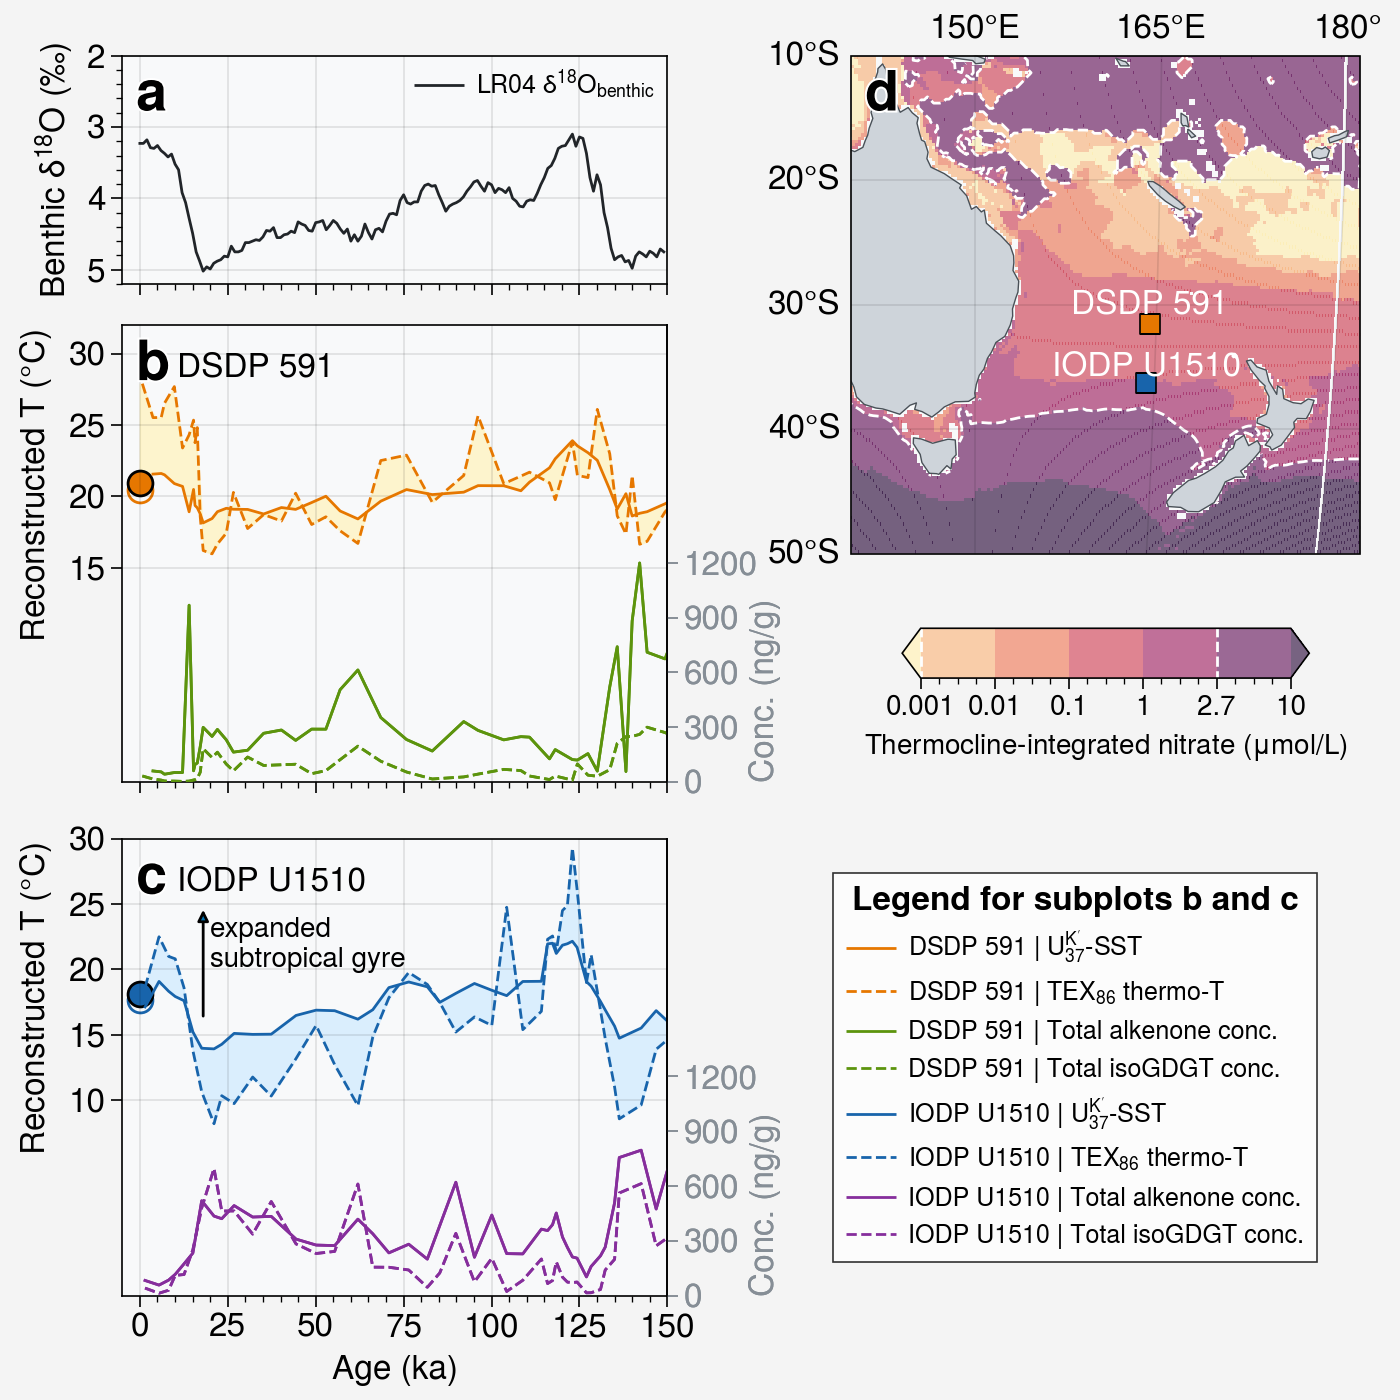

In [70]:

array = [
    [1,1,4,4],
    [2,2,4,4],
    [2,2,0,0],
    [3,3,0,0],
    [3,3,0,0],
]
fig, axs = plot.subplots(
    array,
    figsize=(7,7),
    share=0,
    proj=(None,None,None,'eck3'),
    proj_kw={'lon_0': 150}
    )
axs.format(facecolor='gray0',fontsize=12)
#### plot LR04 benthic d18O
ax = axs[0]

plot_data = LR04_benthic_df[LR04_benthic_df['Age_kyrBP']<150]
plot_x = plot_data['Age_kyrBP']
plot_y = plot_data['d18O_benthic']
ax.plot(plot_x,plot_y,lw=1,c='gray9',label = 'LR04 $\delta^{18}$O$_{benthic}$')
ax.format(
    ylim=(5.2,2.0),
    ylabel='Benthic $\delta^{18}$O (‰)',
)

h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='ur',ncol=2,frameon=False,fontsize=12)
#### plot uk37-SST and tex86-SST as line plots on the same subplot for comparison 

ax = axs[1]
ax2 = ax.twinx()
plot_data = DSDP591_uk37_df.dropna(subset=['uk37_conc_ng_g']).sort_values(by='Age').reset_index(drop=True)
plot_x = plot_data['Age']
plot_y = plot_data['uk37_conc_ng_g']
# ax2.fill_between(plot_x, plot_y, 0, color='gray4',lw=1,label='')
ax2.plot(plot_x, plot_y, color='lime9',lw=1, label='DSDP 591 | Total alkenone conc.')

plot_data = DSDP591_tex86_df.dropna(subset=['gdgt_conc_ng_g']).sort_values(by='Age').reset_index(drop=True)
plot_x = plot_data['Age']
plot_y = plot_data['gdgt_conc_ng_g']
ax2.plot(plot_x, plot_y, color='lime9',lw=1, ls='--', label='DSDP 591 | Total isoGDGT conc.')
ax2.format(
    ylim=(0,2500),
    yticks=np.arange(0,1201,300),  # Ensures major ticks span full range
    ytickminor=False,  # Consistent with ylim
    ytickcolor='gray6',
    ytickloc='right',
    yticklabelcolor='gray6',
    ylabelcolor='gray6',
    ylabel='Conc. (ng/g)',
    fontsize=12
)
ax2.yaxis.set_label_coords(1.15,0.2)

h2, l2 = ax2.get_legend_handles_labels()

plot_data = DSDP591_uk37_df.dropna(subset=['SST_bayspline']).sort_values(by='Age').reset_index(drop=True)
plot_x1 = plot_data['Age']
plot_y1 = plot_data['SST_bayspline']
ax.plot(plot_x1,plot_y1,label="DSDP 591 | U$^{K'}_{37}$-SST",c='yellow9',lw=1)

plot_data = DSDP591_tex86_df[
    ((DSDP591_tex86_df['BIT']<=0.5)
    &(DSDP591_tex86_df['MI']<=0.5)
    &(DSDP591_tex86_df['%GDGT-0']<=60))].dropna(subset=['sst_new']).sort_values(by='Age').reset_index(drop=True)
plot_x2 = plot_data['Age']
plot_y2 = plot_data['sst_new']
ax.plot(plot_x2,plot_y2,label='DSDP 591 | TEX$_{86}$ thermo-T', lw=1, ls='--', c='yellow9')


### shade color between y of two lines ---if tex is higher than uk37, shade red else shade blue
### need to interpolate the two lines to get the y values at the same x

x = np.linspace(0,150,100)
y1 = np.interp(x,plot_x1,plot_y1)
y2 = np.interp(x,plot_x2,plot_y2)
ax.fill_between(x,y1,y2,color='yellow1',alpha=0.75)


h, l = ax.get_legend_handles_labels()
ax.text(0.1,0.94,'DSDP 591',transform=ax.transAxes,
        ha='left',va='top',fontsize=12)
ax.format(
    ylim=(0,32),
    ytickrange=(15,30,5),
    ytickminor=False,
    yticks=[15,20,25,30],
    ylabel='Reconstructed T ($\degree$C)',
)
ax.yaxis.set_label_coords(-0.125,0.65)
#####################################################
ax = axs[2]
ax2 = ax.twinx()
plot_data = IODPU1510_uk37_df[IODPU1510_uk37_df['uk37_conc_ng_g']<8000
                              ].dropna(subset=['uk37_conc_ng_g']).sort_values(by='Age').reset_index(drop=True)
plot_x = plot_data['Age']
plot_y = plot_data['uk37_conc_ng_g']
# ax2.fill_between(plot_x, plot_y-10, color='gray3',lw=1,label='')
ax2.plot(plot_x, plot_y, color='grape9',lw=1, label='IODP U1510 | Total alkenone conc.')

plot_data = IODPU1510_tex86_df.dropna(subset=['gdgt_conc_ng_g']).sort_values(by='Age').reset_index(drop=True)
plot_x = plot_data['Age']
plot_y = plot_data['gdgt_conc_ng_g']
ax2.plot(plot_x, plot_y, color='grape9',lw=1, ls='--', label='IODP U1510 | Total isoGDGT conc.')
ax2.format(
    ylim=(0,2500),
    yticks=np.arange(0,1201,300),  # Ensures major ticks span full range
    ytickminor=False,  # Consistent with ylim
    ytickcolor='gray6',
    ytickloc='right',
    yticklabelcolor='gray6',
    ylabelcolor='gray6',
    ylabel='Conc. (ng/g)',
    fontsize=12
)
ax2.yaxis.set_label_coords(1.15,0.2)
h4, l4 = ax2.get_legend_handles_labels()
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)


plot_data = IODPU1510_uk37_df.dropna(subset=['SST_bayspline']).sort_values(by='Age').reset_index(drop=True)
plot_x1 = plot_data['Age']
plot_y1 = plot_data['SST_bayspline']
ax.plot(plot_x1,plot_y1,label="IODP U1510 | U$^{K'}_{37}$-SST", lw=1, c='blue9')

plot_data = IODPU1510_tex86_df[
    ((IODPU1510_tex86_df['BIT']<=0.5)
    &(IODPU1510_tex86_df['MI']<=0.5)
    &(IODPU1510_tex86_df['%GDGT-0']<=60))].dropna(subset=['sst_new']).sort_values(by='Age').reset_index(drop=True)
plot_x2 = plot_data['Age']
plot_y2 = plot_data['sst_new']
ax.plot(plot_x2,plot_y2,label='IODP U1510 | TEX$_{86}$ thermo-T', lw=1, ls='--', c='blue9')

### shade pale yellow between y of two lines
### need to interpolate the two lines to get the y values at the same x
x = np.linspace(0,150,100)
y1 = np.interp(x,plot_x1,plot_y1)
y2 = np.interp(x,plot_x2,plot_y2)
ax.fill_between(x,y1,y2,color='blue1',alpha=0.75)

h3, l3 = ax.get_legend_handles_labels()
legend = ax.legend(h+h2+h3+h4,l+l2+l3+l4,
          titlefontweight='bold',
          loc='r',
          bbox_to_anchor=(1,0,1,1),
          ncol=1)
legend.set_title('Legend for subplots b and c', prop={'size': 12,
                                                      'weight':'bold'})
ax.text(0.1,0.94,'IODP U1510',transform=ax.transAxes,
        ha='left',va='top',fontsize=12)

ax.format(
    ylim=(-5,30),
    ytickrange=(10,30,5),
    ytickminor=False,
    yticks=[10,15,20,25,30],
    ylabel='Reconstructed T ($\degree$C)',
)

#### add an arrow with annotation showing reduced denitrification during YD and HS1
ax.annotate('',
            xy=(18,16),xytext=(18,25),
            arrowprops=dict(arrowstyle='<|-',lw=1),
            ha='center',va='center',fontsize=8)
ax.text(20,24,'expanded\nsubtropical gyre',
        ha='left',va='top',fontsize=10)
ax.yaxis.set_label_coords(-0.125,0.65)

####################################################
ax = axs[3]
ax.format(
    land=True,landcolor='gray4',landzorder=0,
    coast=True,coastcolor='gray7',coastlinewidth=0.5,
    latlim=(-50,-10),lonlim=(-220,-179),
    latlines=10,lonlines=15,
    latlabels='l',lonlabels='t',
    labelsize=12,
)


### plot thermocline-integrated nitrate on the map
m = thermocline_nitrate_da.sel(lat=slice(-60,-10)).plot(ax=ax,
                                                    zorder=0,
                                                    levels=[1e-3,1e-2,1e-1,1,lowno3_threshold,10],
                                                    cmap='matter',
                                                    add_colorbar=False,
                                                    alpha=0.65,
                                                    rasterized=True)


### plot contour line for lowno3_threshold μM nitrate
m2 = thermocline_nitrate_da.sel(lat=slice(-60,-10)).plot.contour(ax=ax,levels=[0,lowno3_threshold],
                                                zorder=1,
                                                linewidths=1,
                                                linestyles='dashed',
                                                colors='w',robust=True)

ax.set_title('')

axins1 = inset_axes(
    ax,
    width="80%",
    height="10%",
    loc="lower center",
    bbox_to_anchor=(0,-0.25,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0
)
axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             extend='both'
             )
cbar.set_label('Thermocline-integrated nitrate ($\mu$mol/L)', size=10)
cbar.ax.tick_params(labelsize=10)
cbar.add_lines(m2)
cbar.lines[0].set_linestyle('dashed')

axins1.xaxis.set_ticklabels(['0.001','0.01','0.1','1',f'{lowno3_threshold}','10'])
### lat/lon for DSDP591 = -31.5843	 164.4487
### lat/lon for IODP U1510 = 36°19.7385′S, 164°33.5220′E, water depth 1238 m

axs[-1:].scatter(164.4487,-31.5843,c='yellow9',
           mec='k',marker='s',s=50,
           label='DSDP591',
           zorder=2)
axs[-1:].text(164.4487,-30,'DSDP 591',
              ha='center',va='center',
              fontsize=12,transform=ccrs.PlateCarree(),
              c='w',zorder=3)

axs[-1:].scatter(164.33,-36.33,c='blue9',
              mec='k',marker='s',s=50,
              label='IODP U1510',
              zorder=2)

axs[-1:].text(164.33,-35,'IODP U1510',
              ha='center',va='center',
              fontsize=12,transform=ccrs.PlateCarree(),
              c='w',zorder=3)


#### plot today's SST from T_da and thermocline-integrated T data
DSDP591_today_sst = T_da.isel(depth=0).sel(lat=-31.5843,lon=164.4487,method='nearest').values
DSDP591_thermoT = t_sf2tc_da.sel(lat=-31.5843,lon=164.4487,method='nearest').values
axs[1].scatter(0,DSDP591_thermoT,mec='yellow9',mew=1,marker='o',facecolor='none',s=80)
axs[1].scatter(0,DSDP591_today_sst,c='yellow9',mec='k',mew=1,marker='o',s=80)
print(DSDP591_today_sst)

IODPU1510_today_sst = T_da.isel(depth=0).sel(lat=-36.33,lon=164.33,method='nearest').values
IODPU1510_thermoT = t_sf2tc_da.sel(lat=-36.33,lon=164.33,method='nearest').values
axs[2].scatter(0,IODPU1510_thermoT,mec='blue9',mew=1,marker='o',facecolor='none',s=80)
axs[2].scatter(0,IODPU1510_today_sst,c='blue9',mec='k',mew=1,marker='o',s=80)
print(IODPU1510_today_sst)


axs[:3].format(
    xlim=(-5,150),
    xlabel='Age (ka)',
)
axs[:2].format(
    xlabel='',
    xticklabels=[],
)

axs.format(
    abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20},
)


    
fpath = fr'{local_github_path}/figures/'
fname = 'paleo_showcase_SPSTG.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=660)

# 4. Supplementary figures

## Fig S1. Ammonia oxidation rate vs nitrate

In [43]:
## Fig. S1: nitrate and ammonium conc. vs ammonia oxidation rate
plot_data_ammOx_nh4 = merged_ammOxR_gridded_ds.where(
    merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[
        ['ammOxRate_median','NH4_median',
        'ammOxRate_mean','NH4_mean']].to_dataframe().dropna().reset_index()
    
plot_data_ammOx_no3 = merged_ammOxR_gridded_ds.where(
    merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[[
        'ammOxRate_median','NO3_median',
        'ammOxRate_mean','NO3_mean']].to_dataframe().dropna().reset_index()
plot_data_only_ammOx = merged_ammOxR_gridded_ds.where(merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[[
    'ammOxRate_median','ammOxRate_mean']].to_dataframe().dropna().reset_index()

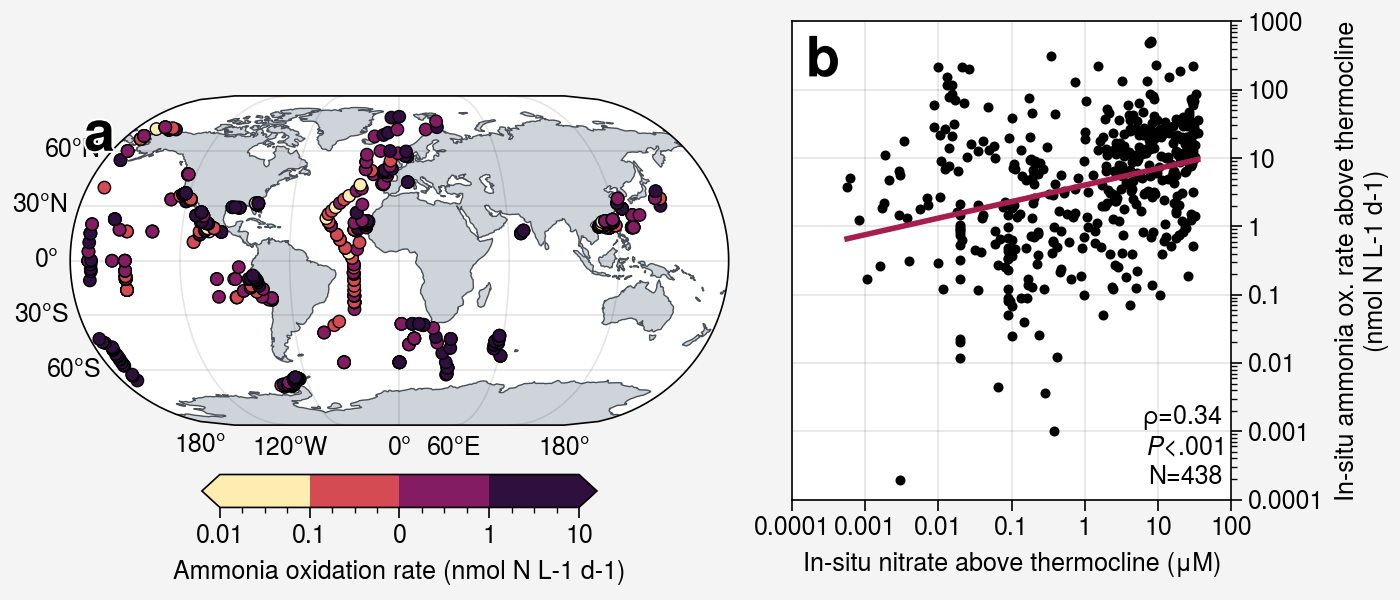

In [44]:
array = [
    [1,2],
]

fig, axs = plot.subplots(array,proj=('eck3',None),
                         wratios=[1.5,1],
                         figsize=(7,3),share=False)

ax = axs[0,0]
ax.format(land=True, landcolor='gray4',landzorder=0,
          coast=True, coastcolor='gray7',coastlinewidth=0.5,coastzorder=1,
          latlabels='l', lonlabels=True)

plot_data = plot_data_only_ammOx
plot_x = plot_data['lon']
plot_y = plot_data['lat']
plot_c = plot_data['ammOxRate_median']
m = ax.scatter(plot_x,plot_y,
              c=plot_c,cmap='matter',
              levels=[1e-2,1e-1,1e0,1e1,1e2],
              robust=True,
              s=20,mec='k',mew=0.5,
              zorder=2)
# ax.colorbar(m,loc='r',shrink=0.6,extend='both',)
axins1 = inset_axes(
    ax,
    width="60%",
    height="10%",
    loc="lower center",
    bbox_to_anchor=(0,-0.25,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             label='Ammonia oxidation rate (nmol N L-1 d-1)',
             extend='both',
             )
axins1.xaxis.set_ticks_position('bottom')
axins1.xaxis.set_label_position('bottom')
axins1.xaxis.set_ticklabels(['0.01','0.1','0','1','10'])

################################################3
ax = axs[0,1]
plot_data = plot_data_ammOx_no3
plot_x_param = 'NO3_median'
plot_y_param = 'ammOxRate_median'
ax.scatter(plot_data[plot_x_param],plot_data[plot_y_param],m='.',c='k')

### calculate log10 for plot_x and plot_y
plot_data['Log10_'+plot_x_param] = np.log10(plot_data[plot_x_param])
plot_data['Log10_'+plot_y_param] = np.log10(plot_data[plot_y_param])
plot_data[['Log10_'+plot_x_param,'Log10_'+plot_y_param]] = plot_data[['Log10_'+plot_x_param,'Log10_'+plot_y_param]
                                                            ].replace([np.inf,-np.inf],np.nan)
reg_data = plot_data.dropna(subset=['Log10_'+plot_x_param,'Log10_'+plot_y_param]).reset_index(drop=True)
  
### ols fit
ols = LinearRegression()
X = reg_data['Log10_'+plot_x_param].values.reshape(-1,1)
y = reg_data['Log10_'+plot_y_param]
ols.fit(X,y)
slope = ols.coef_[0]
intercept = ols.intercept_
X_pred = np.linspace(X.min(),X.max(),100)
y_pred = ols.predict(X_pred.reshape(-1,1))
ax.plot(10**X_pred,10**y_pred,c='pink9',lw=2,label='Linear fit')
### rho and p-value
rho,pval = scipy.stats.spearmanr(X,y)
pval_label = label_pvalues(pval)
ax.text(0.98,0.02,
        f'$\\rho$={rho:.2f}\n{pval_label}\nN={len(plot_data)}',
        transform=ax.transAxes,
        ha='right',va='bottom')

ax.format(
    ylabel='In-situ ammonia ox. rate above thermocline\n(nmol N L-1 d-1)',
    xlabel='In-situ nitrate above thermocline (μM)',
    xscale='log',
    yscale='log',
    xlim=(1e-4,1e2),
    xticks=[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2],
    ylim=(1e-4,1e3),
    ytickloc='right'
)


axs.format(
    abc=True,abcloc='ul',abcstyle='a',
    rc_kw={'abc.size':20},
)

fpath = fr'{local_github_path}/figures/'
fname = 'Fig_S1_gridded_nitrate_with_ammOxR.pdf'
fig.savefig(os.path.join(fpath,fname),dpi=300,bb_inches='tight')

In [45]:
plot_data_nh4_no3 = merged_ammOxR_gridded_ds.where(
    merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[
        ['NO3_median','NH4_median','ammOxRate_median',]].to_dataframe().dropna().reset_index()
plot_data_nh4_no3

lat       lon    depth  NO3_median  NH4_median  ammOxRate_median
0   -69.1250  -76.3750 100.0000     28.7352      1.9217            7.6900
1   -68.6250  -71.1250 100.0000     31.7117      1.0932           10.3322
2   -68.3750  -75.1250 100.0000     25.2623      1.9125           10.1000
3   -68.1250  -78.1250  70.0000     29.8600      1.3157            0.5230
4   -68.1250  -72.3750  80.0000     20.2947      2.7419           33.1985
..       ...       ...      ...         ...         ...               ...
369  72.8750 -161.3750  45.0000      7.2100      3.8500            3.2894
370  72.8750   25.8750   5.0000      9.3545      0.0660          227.6400
371  76.1250   26.1250   5.0000      0.1895      0.0142            5.1600
372  78.1250   -5.8750   5.0000      5.4445      0.0750           64.8000
373  78.6250   -0.1250   5.0000      0.1715      0.0845           75.2400

[374 rows x 6 columns]

## Fig S3. New core-top measurements

In [46]:
fpath = fr'{local_github_path}/spreadsheets/'
fname = 'ds01_updated_global_coretop_tex.csv'

coretop_raw_df = pd.read_csv(os.path.join(fpath,fname))
coretop_raw_df

index_column           core_name core_type  sample_depth_start  \
0     JET_RR_00001          GeoB7702-3        GC              5.0000   
1     JET_RR_00002     KNR195-5-5 MC11        MC              6.0000   
2     JET_RR_00003     KNR195-5-6 MC12        MC              0.0000   
3     JET_RR_00004     KNR195-5-7 MC16        MC              0.0000   
4     JET_RR_00005     KNR195-5-8 MC18        MC              4.0000   
...            ...                 ...       ...                 ...   
2079  JET_RR_02080        AMD17_176_BC       NaN                 NaN   
2080  JET_RR_02081        AMD17_8.1_BC       NaN                 NaN   
2081  JET_RR_02082  AMD17_Disko_Fan_BC       NaN                 NaN   
2082  JET_RR_02083    DSDP591_0-3cm_PC        PC              0.0000   
2083  JET_RR_02084  IODPU1510_6-8cm_PC        PC              6.0000   

      sample_depth_end  latitude  longitude     depth  tex86  fGDGT_0  ...  \
0               6.0000   31.6517    34.0733  562.0000 0.6620      NaN  ...   
1               8.0000   -1.5327   -86.7852 2288.0000 0.6029   0.3306  ...   
2               1.0000   -3.7105   -81.1153  378.0000 0.5700      NaN  ...   
3               1.0000   -3.7502   -81.1358  379.0000 0.5720      NaN  ...   
4               6.0000   -3.9690   -81.3100 1024.0000 0.5994   0.2824  ...   
...                ...       ...        ...       ...    ...      ...  ...   
2079               NaN   69.6000   -65.4000  267.0000 0.4000   0.6900  ...   
2080               NaN   69.4100   -64.4000 1054.0000 0.3226   0.7100  ...   
2081               NaN   67.9700   -59.4900 1012.0000 0.3750   0.6800  ...   
2082            3.0000  -31.5843    64.4487 2131.0000 0.6712   0.2832  ...   
2083            8.0000  -36.3290   164.5587 1238.0000 0.5573   0.3370  ...   

      fGDGT_2  fGDGT_3  fGDGT_cren  fGDGT_cren_prime    bit  publicationYear  \
0         NaN      NaN         NaN               NaN 0.2560             2010   
1      0.0642   0.0049      0.4992            0.0336 0.0268             2025   
2         NaN      NaN         NaN               NaN    NaN             2011   
3         NaN      NaN         NaN               NaN    NaN             2011   
4      0.0524   0.0107      0.5608            0.0309 0.0334             2025   
...       ...      ...         ...               ...    ...              ...   
2079   0.0030   0.0010      0.2920            0.0020    NaN             2023   
2080   0.0060   0.0010      0.2610            0.0030    NaN             2023   
2081   0.0070   0.0020      0.2920            0.0030    NaN             2023   
2082   0.0778   0.0117      0.5042            0.0532 0.0690             2025   
2083   0.0570   0.0075      0.5051            0.0236 0.0289             2025   

      reference_name                                          remark  \
0      Castaneda2010      Data published in Tierney & Tingley (2015)   
1         this study  Reanalysed samples of Chazen2011 by this study   
2         Chazen2011      Data published in Tierney & Tingley (2015)   
3         Chazen2011      Data published in Tierney & Tingley (2015)   
4         this study  Reanalysed samples of Chazen2011 by this study   
...              ...                                             ...   
2079     Harning2023                       Data from original source   
2080     Harning2023                       Data from original source   
2081     Harning2023                       Data from original source   
2082      this study   New GDGT measurements published in this study   
2083      this study   New GDGT measurements published in this study   

                                         reference_link  \
0                http://dx.doi.org/10.1029/2009PA001740   
1                                                   NaN   
2     https://repository.library.brown.edu/studio/it...   
3     https://repository.library.brown.edu/studio/it...   
4                                                   NaN   
...                     

This study: 170
TT2015: 865
post TT2015: 1049


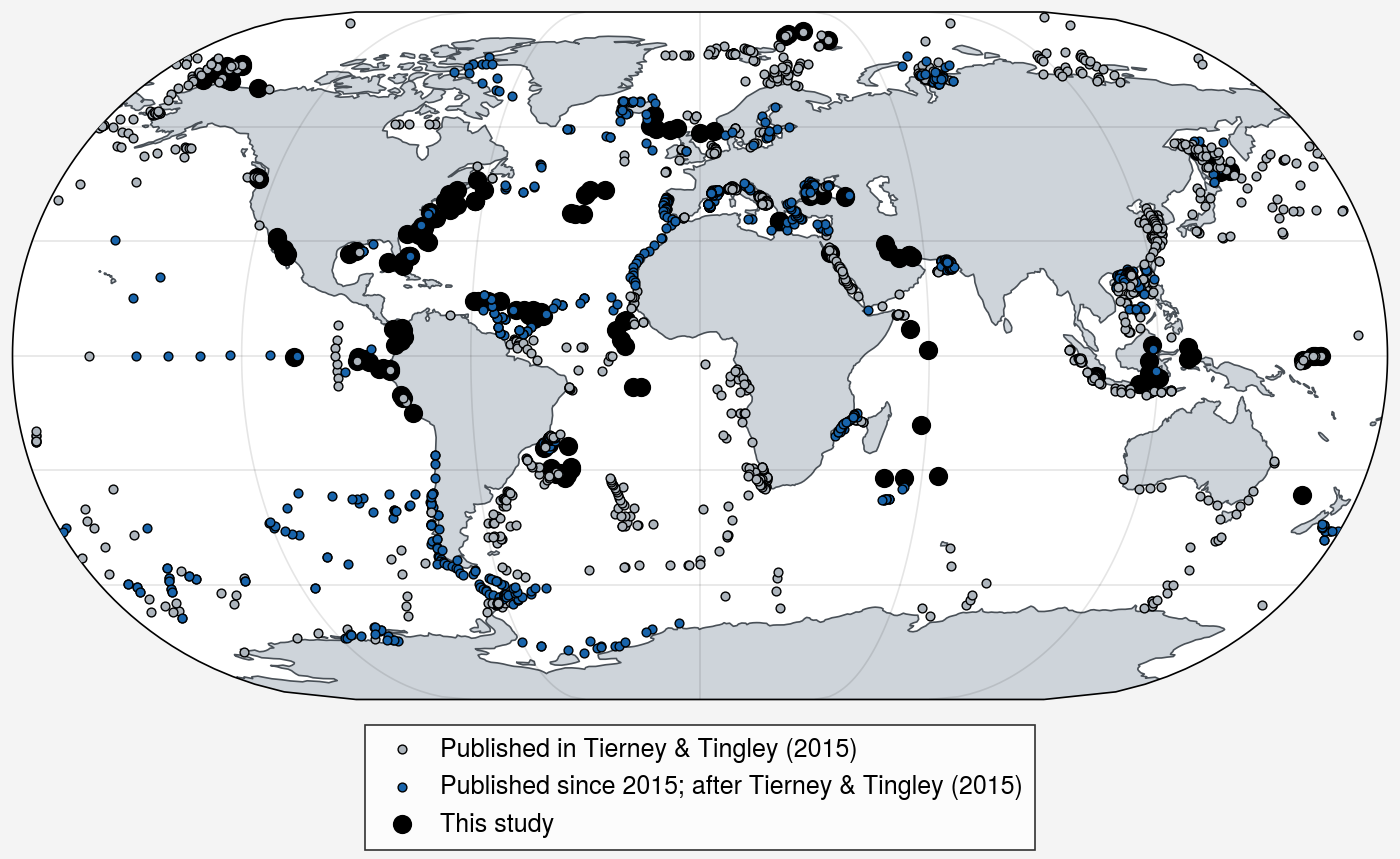

In [47]:
plot.rc.abc = False
fig, axs = plot.subplots(proj=('eck3'),share=0,width=7)

ax = axs[0]
ax.format(
    land=True,landcolor='gray4',landzorder=0,
    coast=True,coastcolor='gray7',coastzorder=1,
)
plot_data = coretop_raw_df
grouped = plot_data.groupby('reference_name')
post_TT2015_data = 0
TT2015_data = 0
thisStudy_data = 0
for name, group in grouped:
    plot_lat = group['latitude']
    plot_lon = group['longitude']
    
    if name == 'this study':
        ax.scatter(plot_lon,plot_lat,
                   c='k',marker='o',s=40,
                   zorder=2,
                   label=name)
        thisStudy_data += len(group)
    elif ((group['publicationYear'].unique()[0] < 2015)
          and name != 'Tierney2015'):
        ax.scatter(plot_lon,plot_lat,
                   c='gray5',marker='o',s=10,
                   mec='k',mew=0.5,
                   zorder=3,
                   label=name)
        post_TT2015_data += len(group)
    else:
        ax.scatter(plot_lon,plot_lat,
                   c='blue9',marker='o',s=10,
                   mec='k',mew=0.5,
                   zorder=3,
                   label=name)
        TT2015_data += len(group)
        
print(f'This study: {thisStudy_data}')
print(f'TT2015: {TT2015_data}')
print(f'post TT2015: {post_TT2015_data}')
h, l = ax.get_legend_handles_labels()
item_idx = [-2,-4,-1]
fig.legend([h[i] for i in item_idx],
           labels=['Published in Tierney & Tingley (2015)',
                   'Published since 2015; after Tierney & Tingley (2015)',
                   'This study'
                   ],
           loc='b',ncol=1,fontsize=10)
        
fpath = fr'{local_github_path}/figures/'
fname = 'Fig_S3_coretop_sites.pdf'
fig.save(fpath+fname,dpi=330,bbox_inches='tight',embed_fonts=True)


## Fig. S6. d15N vs SST anomalies - Arabian Sea

In [48]:
### create a dataframe that contains uk_sst, tex_sst, and d15N for both sites
age_step = np.arange(0,20.1,0.1)

### get interpolated uk_sst and tex_sst and d15N for 905 to this time step
uk_905 = np.interp(age_step,NIOP905_SST_df['Age_kaBP'],NIOP905_SST_df['uk37'])
uk_sst_905 = np.interp(age_step,NIOP905_SST_df['Age_kaBP'],NIOP905_SST_df['sst'])
tex_905 = np.interp(age_step,NIOP905_tex_df['Age']*1000,NIOP905_tex_df['ProxyValue'])
tex_sst_905 = np.interp(age_step,NIOP905_tex_df['Age']*1000,NIOP905_tex_df['SST'])
d15N_905 = np.interp(age_step,downcore_d15N_df[downcore_d15N_df['core_name']=='NIOP 905']['Age'],downcore_d15N_df[downcore_d15N_df['core_name']=='NIOP 905']['d15N'])
core_name_repeat = ['NIOP 905']*len(age_step)
core_name_repeat = pd.Series(core_name_repeat).astype('category')

### build a df for 905
NIOP905_df = pd.DataFrame({'Age':age_step,
                           'uk':uk_905,
                           'uk_sst':uk_sst_905,
                           'tex':tex_905,
                           'tex_sst':tex_sst_905,
                           'd15N':d15N_905,
                           'core_name':core_name_repeat})
modern_tex = tex_905[:10].mean()
NIOP905_df['tex_residual'] = NIOP905_df['tex'] - modern_tex

### get interpolated uk_sst and tex_sst and d15N for SO42 to this time step
uk_SO42 = np.interp(age_step,SO42_75KL_SST_df['Age_kaBP'],SO42_75KL_SST_df['uk37'])
uk_sst_SO42 = np.interp(age_step,SO42_75KL_SST_df['Age_kaBP'],SO42_75KL_SST_df['sst'])
tex_SO42 = np.interp(age_step,SO42_75KL_tex_df['Age']*1000,SO42_75KL_tex_df['ProxyValue'])
tex_sst_SO42 = np.interp(age_step,SO42_75KL_tex_df['Age']*1000,SO42_75KL_tex_df['SST'])
d15N_SO42 = np.interp(age_step,downcore_d15N_df[downcore_d15N_df['core_name']=='SO42-74KL']['Age'],downcore_d15N_df[downcore_d15N_df['core_name']=='SO42-74KL']['d15N'])
core_name_repeat = ['SO42-74KL']*len(age_step)
core_name_repeat = pd.Series(core_name_repeat).astype('category')

### build a df for SO42
SO42_df = pd.DataFrame({'Age':age_step,
                        'uk':uk_SO42,
                        'uk_sst':uk_sst_SO42,
                        'tex':tex_SO42,
                        'tex_sst':tex_sst_SO42,
                        'd15N':d15N_SO42,
                        'core_name':core_name_repeat})
modern_tex = tex_SO42[:10].mean()
SO42_df['tex_residual'] = SO42_df['tex'] - modern_tex

### join two dataframes
paleo_df = pd.concat([NIOP905_df,SO42_df],ignore_index=True)
paleo_df['core_name'] = paleo_df['core_name'].astype('category')
paleo_df['delta_SST'] = paleo_df['tex_sst'] - paleo_df['uk_sst']
paleo_df

Age     uk  uk_sst    tex  tex_sst   d15N  core_name  tex_residual  \
0    0.0000 0.9119 26.5692 0.6660  27.4809    NaN   NIOP 905       -0.0053   
1    0.1000 0.9123 26.6043 0.6694  27.7610    NaN   NIOP 905       -0.0019   
2    0.2000 0.9128 26.6476 0.6737  28.1067    NaN   NIOP 905        0.0023   
3    0.3000 0.9129 26.6659 0.6706  27.8561    NaN   NIOP 905       -0.0007   
4    0.4000 0.9130 26.6860 0.6671  27.5678    NaN   NIOP 905       -0.0043   
..      ...    ...     ...    ...      ...    ...        ...           ...   
397 19.6000 0.8695 24.6285 0.6470  25.9289 7.7444  SO42-74KL       -0.0365   
398 19.7000 0.8672 24.5422 0.6474  25.9621 7.6333  SO42-74KL       -0.0361   
399 19.8000 0.8682 24.5814 0.6492  26.1097 7.5759  SO42-74KL       -0.0343   
400 19.9000 0.8692 24.6206 0.6510  26.2573 7.5414  SO42-74KL       -0.0325   
401 20.0000 0.8701 24.6598 0.6528  26.4049 7.5069  SO42-74KL       -0.0307   

     delta_SST  
0       0.9117  
1       1.1567  
2       1.4591  
3       1.1901  
4       0.8818  
..         ...  
397     1.3004  
398     1.4199  
399     1.5283  
400     1.6367  
401     1.7451  

[402 rows x 9 columns]

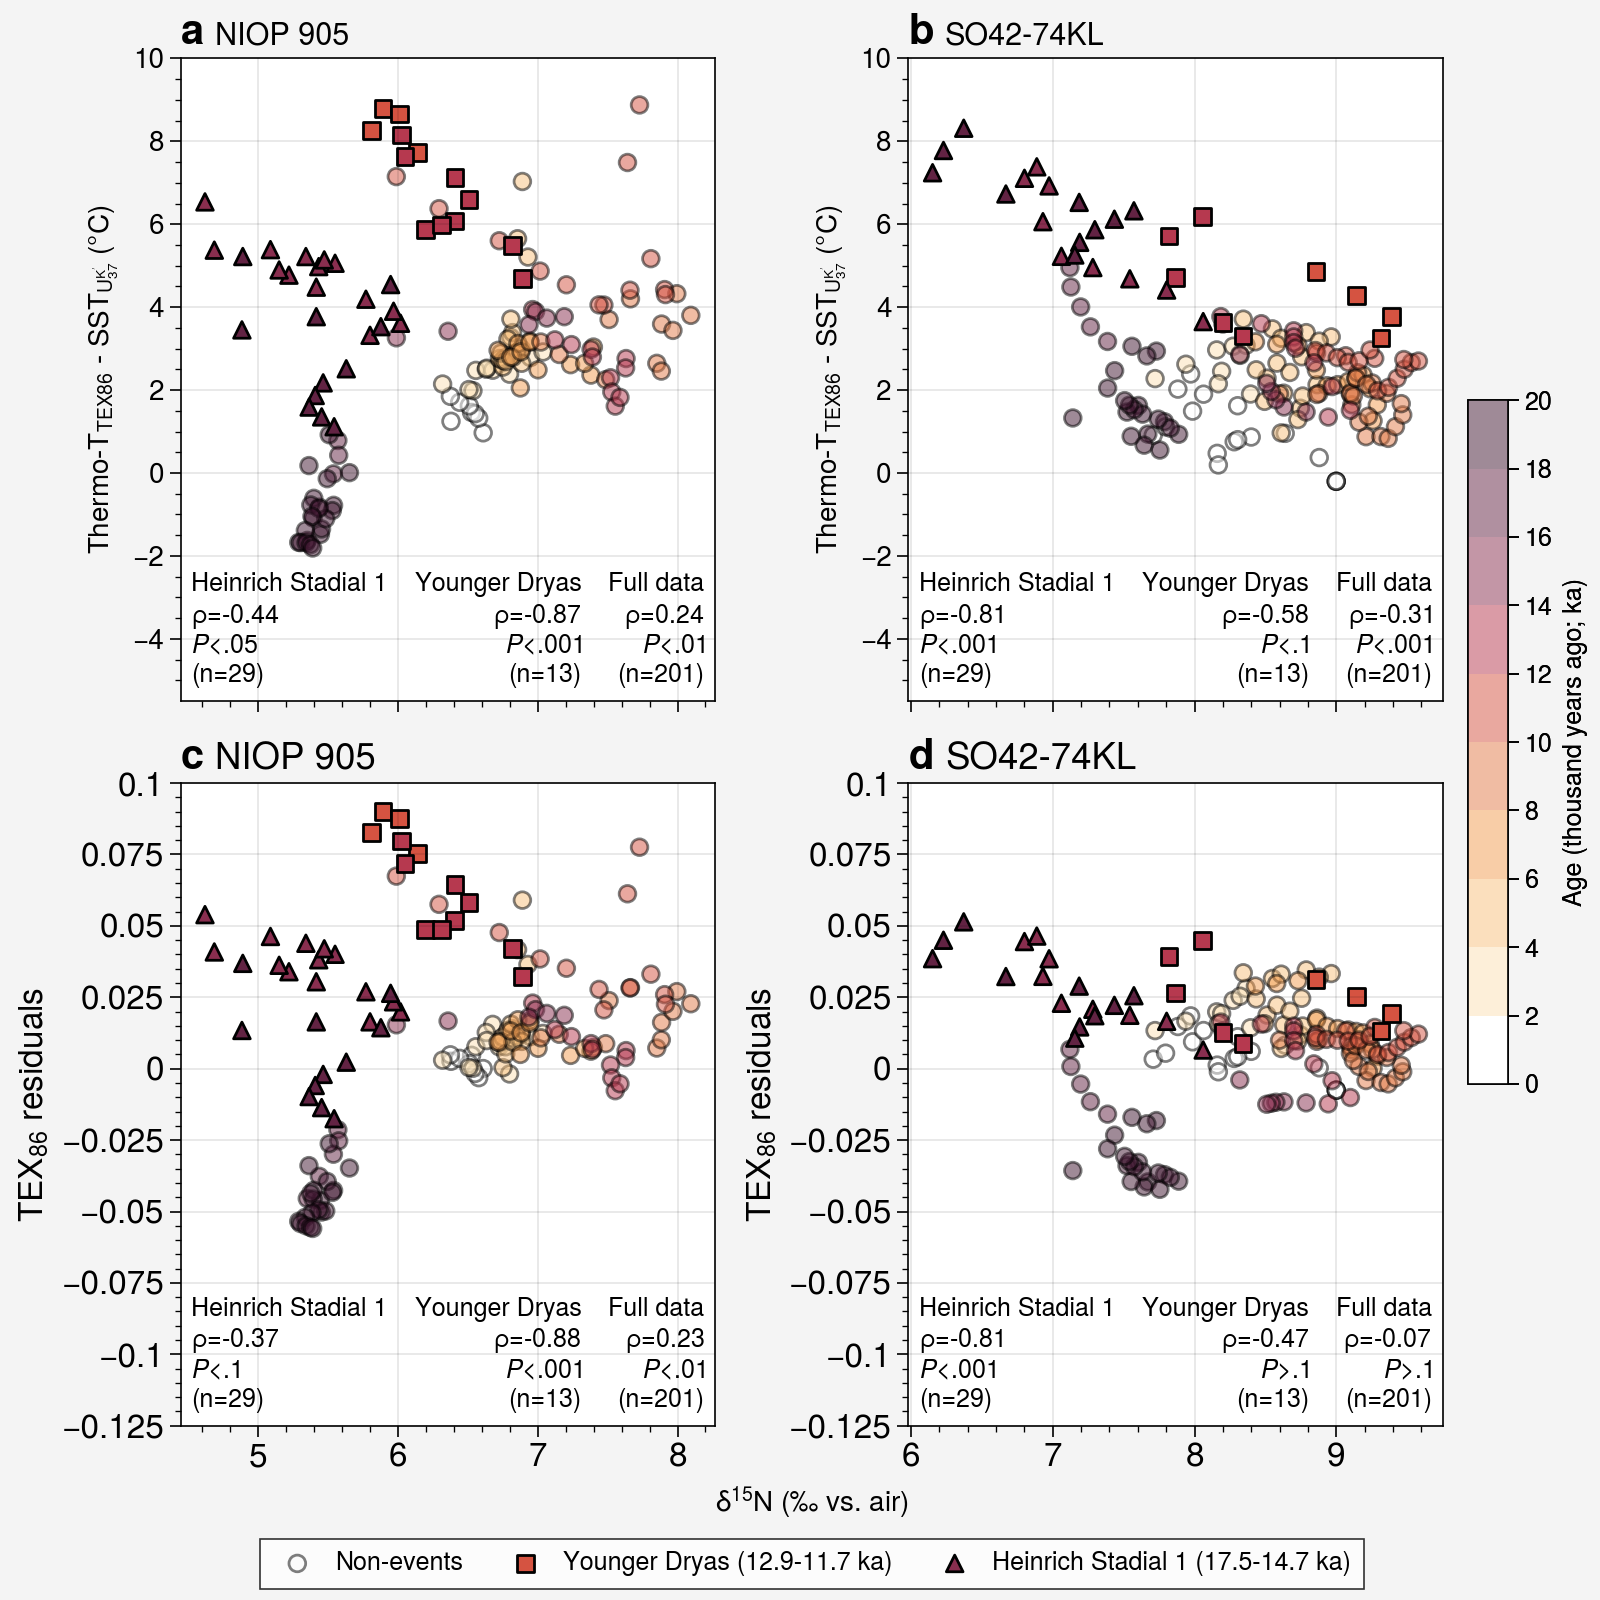

In [49]:


fig, axs = plot.subplots(ncols=2,nrows=2,
                         figsize=(8,8),
                         sharey=0)

grouped = paleo_df.groupby('core_name')
for i, (name, group) in enumerate(grouped):
        ax = axs[0,i]
        ax.format(
                ltitle=name,
                fontsize=10
        )
        group = group.sort_values(by='Age').reset_index(drop=True)
        ### calculate spearman rho and pval between d15N and delta_SST
        reg_data = group[['d15N','delta_SST']].dropna()
        rho, pval = spearmanr(reg_data['d15N'],reg_data['delta_SST'])
        pval_label = label_pvalues(pval)
        ax.text(0.98,0.02,f'Full data\n$\\rho$={rho:.2f}\n{pval_label}\n(n={len(group)})',
                transform=ax.transAxes,
                ha='right',va='bottom')
        
        
        group_YD = group[(group['Age']>=11.7) & (group['Age']<=12.9)]
        ### calculate spearman rho and pval between d15N and delta_SST during YD
        reg_data_YD = group_YD[['d15N','delta_SST']].dropna()
        rho_YD, pval_YD = spearmanr(reg_data_YD['d15N'],reg_data_YD['delta_SST'])
        pval_label_YD = label_pvalues(pval_YD)
        ax.text(0.75,0.02,f'Younger Dryas\n$\\rho$={rho_YD:.2f}\n{pval_label_YD}\n(n={len(group_YD)})',
                transform=ax.transAxes,
                ha='right',va='bottom')
        
        group_HS1 = group[(group['Age']>=14.7) & (group['Age']<=17.5)]
        ### calculate spearman rho and pval between d15N and delta_SST during HS1
        reg_data_HS1 = group_HS1[['d15N','delta_SST']].dropna()
        rho_HS1, pval_HS1 = spearmanr(reg_data_HS1['d15N'],reg_data_HS1['delta_SST'])
        pval_label_HS1 = label_pvalues(pval_HS1)
        ax.text(0.02,0.02,f'Heinrich Stadial 1\n$\\rho$={rho_HS1:.2f}\n{pval_label_HS1}\n(n={len(group_HS1)})',
                transform=ax.transAxes,
                ha='left',va='bottom')
        group_nonYDHS1 = group[(group['Age']<11.7) | (group['Age']>12.9) & ((group['Age']<14.7) | (group['Age']>17.5))]
        
        ### plot non-events data
        plot_x = group_nonYDHS1['d15N']
        plot_y = group_nonYDHS1['delta_SST']
        plot_c = group_nonYDHS1['Age']
        m = ax.scatter(plot_x,plot_y,
                        c=plot_c,levels=np.arange(0,20.1,2),
                        mec='k',lw=1,label='Non-events',
                        alpha=0.5)
        
        ### plot YD and HS1 data
        plot_x = group_YD['d15N']
        plot_y = group_YD['delta_SST']
        plot_c = group_YD['Age']
        ax.scatter(plot_x,plot_y,m='s',
                c=plot_c,levels=np.arange(0,20.1,2),
                mec='k',lw=1,label='Younger Dryas (12.9-11.7 ka)',)
        
        plot_x = group_HS1['d15N']
        plot_y = group_HS1['delta_SST']
        plot_c = group_HS1['Age']
        ax.scatter(plot_x,plot_y,m='^',
                c=plot_c,levels=np.arange(0,20.1,2),
                mec='k',lw=1,label='Heinrich Stadial 1 (17.5-14.7 ka)',)
        
        ### plot d15N vs tex_residuals
        ax = axs[1,i]
        ax.format(
                ltitle=name,
                fontsize=12
        )
        
        group = group.sort_values(by='Age').reset_index(drop=True)
        ### calculate spearman rho and pval between d15N and delta_SST
        reg_data = group[['d15N','tex_residual']].dropna()
        rho, pval = spearmanr(reg_data['d15N'],reg_data['tex_residual'])
        pval_label = label_pvalues(pval)
        ax.text(0.98,0.02,f'Full data\n$\\rho$={rho:.2f}\n{pval_label}\n(n={len(group)})',
                transform=ax.transAxes,
                ha='right',va='bottom')
        group_YD = group[(group['Age']>=11.7) & (group['Age']<=12.9)]
        ### calculate spearman rho and pval between d15N and delta_SST during YD
        reg_data_YD = group_YD[['d15N','tex_residual']].dropna()
        rho_YD, pval_YD = spearmanr(reg_data_YD['d15N'],reg_data_YD['tex_residual'])
        pval_label_YD = label_pvalues(pval_YD)
        ax.text(0.75,0.02,f'Younger Dryas\n$\\rho$={rho_YD:.2f}\n{pval_label_YD}\n(n={len(group_YD)})',
                transform=ax.transAxes,
                ha='right',va='bottom')
        group_HS1 = group[(group['Age']>=14.7) & (group['Age']<=17.5)]
        ### calculate spearman rho and pval between d15N and delta_SST during YD
        reg_data_HS1 = group_HS1[['d15N','tex_residual']].dropna()
        rho_HS1, pval_HS1 = spearmanr(reg_data_HS1['d15N'],reg_data_HS1['tex_residual'])
        pval_label_HS1 = label_pvalues(pval_HS1)
        ax.text(0.02,0.02,f'Heinrich Stadial 1\n$\\rho$={rho_HS1:.2f}\n{pval_label_HS1}\n(n={len(group_HS1)})',
                transform=ax.transAxes,
                ha='left',va='bottom')
        group_nonYDHS1 = group[(group['Age']<11.7) | (group['Age']>12.9) & ((group['Age']<14.7) | (group['Age']>17.5))]
        ### plot non-events data
        plot_x = group_nonYDHS1['d15N']
        plot_y = group_nonYDHS1['tex_residual']
        plot_c = group_nonYDHS1['Age']
        m = ax.scatter(plot_x,plot_y,
                        c=plot_c,levels=np.arange(0,20.1,2),
                        mec='k',lw=1,label='Non-events',
                        alpha=0.5)
        
        ### plot YD and HS1 data
        plot_x = group_YD['d15N']
        plot_y = group_YD['tex_residual']
        plot_c = group_YD['Age']
        ax.scatter(plot_x,plot_y,m='s',
                c=plot_c,levels=np.arange(0,20.1,2),
                mec='k',lw=1,label='Younger Dryas (12.9-11.7 ka)',)
        
        plot_x = group_HS1['d15N']
        plot_y = group_HS1['tex_residual']
        plot_c = group_HS1['Age']
        ax.scatter(plot_x,plot_y,m='^',
                c=plot_c,levels=np.arange(0,20.1,2),
                mec='k',lw=1,label='Heinrich Stadial 1 (17.5-14.7 ka)',)
        
        
        

    
h, l = axs[0].get_legend_handles_labels()
fig.legend(h,l,loc='bottom',c='k')

axs[0,:].format(
        xlabel='$\delta^{15}$N (‰ vs. air)',
        ylabel=r"Thermo-T$_{TEX86}$ - SST$_{U^{K'}_{37}}$ ($\degree$C)",
        ylim=(-5.5,10)
)

axs[1,:].format(
        xlabel='$\delta^{15}$N (‰ vs. air)',
        ylabel=r"TEX$_{86}$ residuals",
        ylim=(-0.125,0.1)
        )

# axs[2,:].format(
#         xlabel=r"Thermo-T$_{TEX86}$ - SST$_{U^{K'}_{37}}$ ($\degree$C)",
#         ylabel=r"TEX$_{86}$ residuals",
#         ylim=(-0.125,0.1)
#         )

axs.format(abc='a',abcloc='l',
           rc_kw={'abc.size':15})
    
### add colorbar
fig.colorbar(m,loc='r',label='Age (thousand years ago; ka)',shrink=0.5)

fpath = fr'{local_github_path}/figures/'
fname = 'Fig_S6_paleo_showcase_d15N_deltaSST_ArabianSea.pdf'
fig.savefig(os.path.join(fpath,fname),dpi=300,bbox_inches='tight',embed_fonts=True)

In [50]:
DSDP591_merged_df = pd.merge(DSDP591_uk37_df,DSDP591_tex86_df,
                            how='inner',on=['Depth_mbsf','Depth_mbsf'])
DSDP591_merged_df['sst_diff'] = DSDP591_merged_df['sst_new'] - DSDP591_merged_df['SST_bayspline']
display(DSDP591_merged_df)

IODPU1510_merged_df = pd.merge(IODPU1510_uk37_df,IODPU1510_tex86_df,
                            how='inner',on=['Depth_mbsf','Depth_mbsf'])
IODPU1510_merged_df['sst_diff'] = IODPU1510_merged_df['sst_new'] - IODPU1510_merged_df['SST_bayspline']
IODPU1510_merged_df = IODPU1510_merged_df[IODPU1510_merged_df['uk37_conc_ng_g']<8000].reset_index(drop=True)
display(IODPU1510_merged_df)

Depth_mbsf    Age_x   uk37  SST_bayspline  uk37_conc_ng_g    Age_y  TEX86  \
0       0.0800   3.7333 0.7803        21.5670         60.1421   3.7333 0.6421   
1       0.1300   6.0667 0.7821        21.6121         55.2160   6.0667 0.6422   
2       0.1500   7.0000 0.7784        21.5189         42.3467   7.0000 0.6544   
3       0.2100   9.8000 0.7586        20.9047         51.5504   9.8000 0.6687   
4       0.2600  12.1333 0.7519        20.7060         51.6537  12.1333 0.6160   
5       0.3000  14.0000 0.6929        18.9267        967.4542  14.0000 0.6273   
6       0.3600  15.2632 0.7450        20.4948         61.1464  15.2632 0.6399   
7       0.3800  15.6842 0.7080        19.3682         95.8060  15.6842 0.6205   
8       0.4100  16.3158 0.7030        19.2093        103.4530  16.3158 0.6335   
9       0.4500  17.1579 0.6884        18.7824        192.9993  17.1579 0.5572   
10      0.4900  18.0000 0.6677        18.1506        298.9644  18.0000 0.5281   
11      0.5400  20.5287 0.6774        18.4557        249.2698  20.5287 0.5252   
12      0.5700  22.0460 0.6931        18.9329        287.5510  22.0460 0.5337   
13      0.6200  24.5747 0.7019        19.1733        230.5949  24.5747 0.5430   
14      0.6600  26.5977 0.6993        19.1067        163.3045  26.5977 0.5779   
15      0.7400  30.6437 0.6987        19.0927        173.7468  30.6437 0.5469   
16      0.8300  35.1954 0.6882        18.7736        266.4345  35.1954 0.5589   
17      0.9300  40.2529 0.7028        19.2252        284.3380  40.2529 0.5534   
18      1.0100  44.2989 0.6986        19.0976        227.6421  44.2989 0.5772   
19      1.1000  48.8506 0.7150        19.5757        289.2339  48.8506 0.5504   
20      1.1800  52.8966 0.7299        20.0194        288.9331  52.8966 0.5570   
21      1.2600  56.9425 0.6950        18.9841        504.8465  56.9425 0.5450   
22      1.3600  62.0000 0.6769        18.4276        612.9564  62.0000 0.5341   
23      1.4400  68.5067 0.7184        19.6722        352.7811  68.5067 0.6052   
24      1.5300  75.8267 0.7449        20.4855        232.3326  75.8267 0.6099   
25      1.6200  83.1467 0.7332        20.1335        169.3703  83.1467 0.5694   
26      1.7300  92.0933 0.7384        20.3019        330.5445  92.0933 0.5924   
27      1.7800  96.1600 0.7541        20.7601        282.2951  96.1600 0.6437   
28      1.8700 103.4800 0.7532        20.7520        230.4633 103.4800 0.5854   
29      1.9300 108.3600 0.7416        20.4002        248.0181 108.3600 0.5919   
30      1.9600 110.8000 0.7614        21.0046        245.2641 110.8000 0.5953   
31      2.0300 116.4933 0.7945        22.0104        126.5821 116.4933 0.5861   
32      2.0500 118.1200 0.8145        22.6417        177.1771 118.1200 0.5717   
33      2.1100 123.0000 0.8514        23.9112        122.5044 123.0000 0.6212   
34      2.1300 124.4167 0.8414        23.5480        119.7737 124.4167 0.5925   
35      2.1725 127.4271 0.8279        23.0685        155.2068 127.4271 0.5906   
36      2.2100 130.0833 0.8118        22.5343         59.5159 130.0833 0.6491   
37      2.2600 133.6250 0.7452        20.4798        520.1683 133.6250 0.6110   
38      2.2900 135.7500 0.6999        19.1194        740.1532 135.7500 0.5579   
39      2.3250 138.2292 0.7351        20.1976         57.1500 138.2292 0.5423   
40      2.3500 140.0000 0.6840        18.6320        881.3064 140.0000 0.5924   
41      2.3750 142.1250 0.6898        18.8219       1198.5698 142.1250 0.5334   
42      2.4000 144.2500 0.6934        18.9336        710.0240 144.2500 0.5359   
43      2.4600 149.3500 0.7120        19.4890        673.5984 149.3500 0.5612   
44      2.5100 153.6000 0.7318        20.0791        895.7534 153.6000 0.5739   

      BIT     MI  %GDGT-0  TEX86H-derived SST  BAYSPAR-derived SST  \
0  0.0376 0.2215  34.7351             25.4377              26.2825   
1  0.0531 0.2209  31.2206             25.4445              26.4147   
2  0.0497 0.2256  33.1066             26.0049              27.0389 

Depth_mbsf    Age_x   uk37  SST_bayspline  uk37_conc_ng_g    Age_y  TEX86  \
0       0.0700   1.4651 0.6335        17.1269         83.5713   1.4651 0.5573   
1       0.2600   5.4419 0.6981        19.0839         58.1933   5.4419 0.6051   
2       0.3900   8.1628 0.6731        18.3331         85.3466   8.1628 0.5867   
3       0.4800  10.0465 0.6598        17.9272        117.0404  10.0465 0.5844   
4       0.6000  12.5581 0.6488        17.6053        174.6079  12.5581 0.5572   
5       0.7200  15.0698 0.5688        15.2184        233.4698  15.0698 0.4984   
6       0.8400  17.5814 0.5270        13.9621        519.8478  17.5814 0.4597   
7       0.9300  21.0800 0.5254        13.9143        435.8783  21.0800 0.4297   
8       0.9800  23.2800 0.5373        14.2667        421.6222  23.2800 0.4560   
9       1.0600  26.8000 0.5656        15.1016        493.3082  26.8000 0.4486   
10      1.1800  32.0800 0.5625        15.0266        430.6333  32.0800 0.4735   
11      1.3000  37.3600 0.5633        15.0415        434.3105  37.3600 0.4557   
12      1.4600  44.4000 0.6116        16.4761        309.9940  44.4000 0.4908   
13      1.5900  50.1200 0.6249        16.8826        277.2319  50.1200 0.5219   
14      1.7100  55.4000 0.6232        16.8397        274.3384  55.4000 0.4851   
15      1.8600  62.0000 0.6024        16.1916        419.0430  62.0000 0.4467   
16      1.9800  66.2312 0.6262        16.9136        339.2140  66.2312 0.5111   
17      2.1100  70.8150 0.6830        18.6106        234.5840  70.8150 0.5479   
18      2.2700  76.4566 0.6974        19.0426        281.8335  76.4566 0.5716   
19      2.4200  81.7457 0.6847        18.6701        200.3088  81.7457 0.5604   
20      2.6500  89.8555 0.6677        18.1695        621.1612  89.8555 0.5157   
21      2.8000  95.1445 0.6929        18.9259        210.6497  95.1445 0.5299   
22      2.9400 100.0809 0.6757        18.4054        441.4779 100.0809 0.5219   
23      3.0600 104.3121 0.6625        17.9923        230.5022 104.3121 0.6328   
24      3.1900 108.8960 0.6979        19.0797        228.9614 108.8960 0.5179   
25      3.3400 114.1850 0.6989        19.0926        364.4118 114.1850 0.5352   
26      3.3900 115.9480 0.7931        21.9611        356.5380 115.9480 0.6027   
27      3.4300 117.3584 0.7942        22.0085        389.1412 117.3584 0.6058   
28      3.4600 118.4162 0.7693        21.2266        452.5740 118.4162 0.5913   
29      3.5100 120.1792 0.7901        21.8613        321.4716 120.1792 0.6297   
30      3.5500 121.5896 0.7935        21.9730        264.0238 121.5896 0.6344   
31      3.5900 123.0000 0.7991        22.1621        212.3430 123.0000 0.6883   
32      3.6300 124.3333 0.7845        21.6896        205.6542 124.3333 0.6494   
33      3.7100 127.0000 0.6980        19.0663        103.0538 127.0000 0.5621   
34      3.7500 128.3333 0.6864        18.7210        160.2725 128.3333 0.5883   
35      3.8300 131.0000 0.6474        17.5449        218.6210 131.0000 0.5359   
36      3.8700 132.3333 0.6255        16.9006        265.8660 132.3333 0.5096   
37      3.9500 135.0000 0.5843        15.6565        508.7969 135.0000 0.4642   
38      3.9900 136.3333 0.5526        14.7324        756.2989 136.3333 0.4343   
39      4.1900 142.5582 0.5787        15.5110        796.5818 142.5582 0.4473   
40      4.3400 146.8219 0.6239        16.8453        474.6999 146.8219 0.4995   
41      4.5400 152.5068 0.5764        15.4185        851.5612 152.5068 0.5155   

      BIT     MI  %GDGT-0  TEX86H-derived SST  BAYSPAR-derived SST  \
0  0.0289 0.2026  40.0189             21.2341              19.8962   
1  0.2859 0.2115  39.1803             23.6774              23.0845   
2  0.2219 0.2187  39.8798             22.7586              21.7442   
3  0.0681 0.2030  37.3392             22.6425              21.7445   
4  0.0931 0.2382  43.7782             21.2256              19.9518   
5  0.0571 0.2122  45.2189             17.9156              16.1339   
6  0.0589 0.2360  52.3594     

## Fig. S7. alkenone concentrations vs SST anomalies

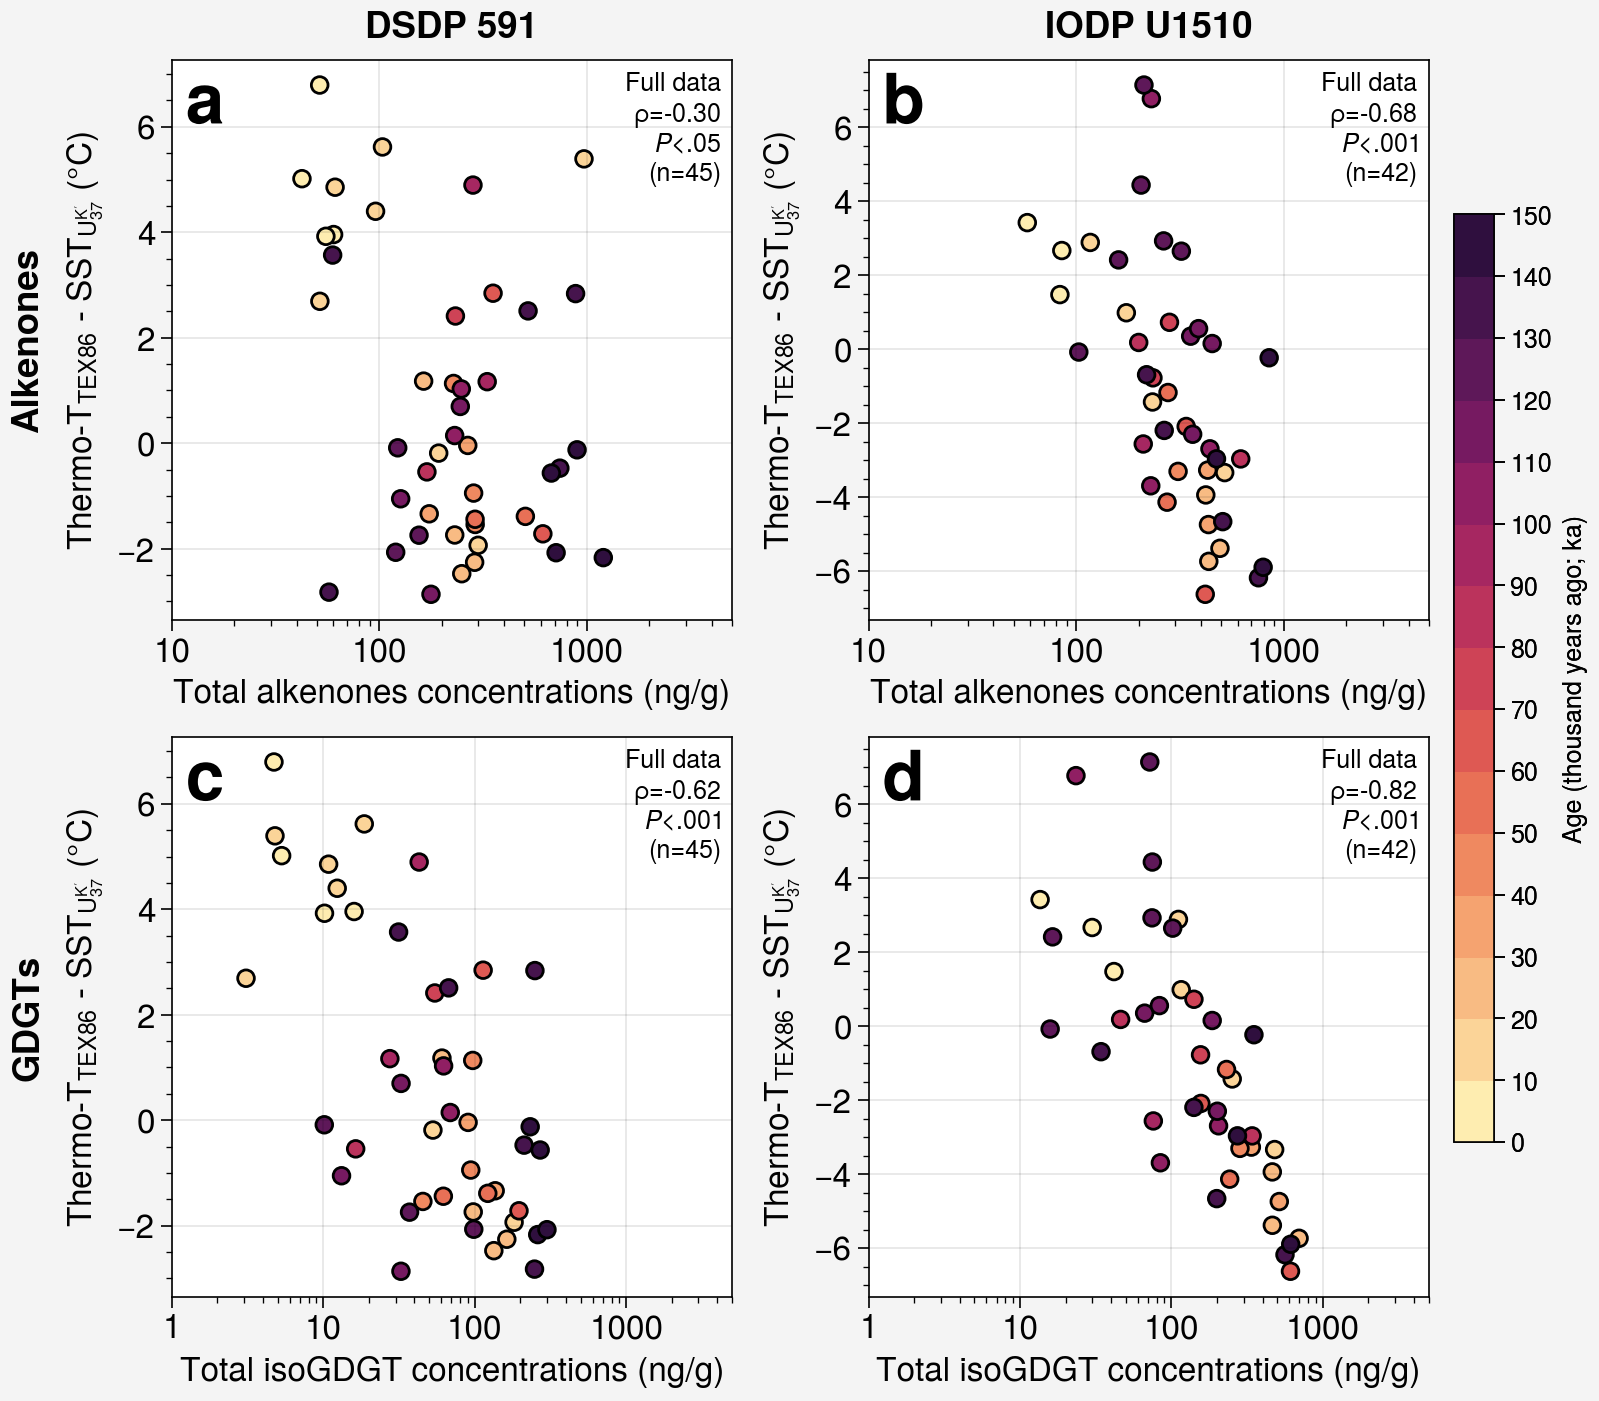

In [51]:
fig, axs = plot.subplots(ncols=2,
                         nrows=2,
                         width=8,
                         share=0)

axs.format(
    collabels=['DSDP 591','IODP U1510'],
    rowlabels=['Alkenones','GDGTs'],
    fontsize=12,
    abc='a',abcloc='ul',rc_kw={'abc.size':25}
)

plot_data = DSDP591_merged_df
plot_x = plot_data['uk37_conc_ng_g']
plot_y = plot_data['sst_diff']
plot_c = plot_data['Age_x']
ax = axs[0,0]
ax.scatter(plot_x,plot_y,
           c=plot_c,cmap='matter',
           levels=np.arange(0,151,10),
           mec='k',lw=1)

### spearman rho and pval
reg_data = plot_data[['uk37_conc_ng_g','sst_diff']].dropna()
rho, pval = spearmanr(reg_data['uk37_conc_ng_g'],reg_data['sst_diff'])
pval_label = label_pvalues(pval)
ax.text(0.98,0.98,f'Full data\n$\\rho$={rho:.2f}\n{pval_label}\n(n={len(plot_data)})',
        transform=ax.transAxes,va='top',ha='right')

ax = axs[1,0]
plot_x2 = plot_data['gdgt_conc_ng_g']
ax.scatter(plot_x2,plot_y,
           c=plot_c,cmap='matter',
           levels=np.arange(0,151,10),
           mec='k',lw=1)

### spearman rho and pval
reg_data = plot_data[['gdgt_conc_ng_g','sst_diff']].dropna()
rho, pval = spearmanr(reg_data['gdgt_conc_ng_g'],reg_data['sst_diff'])
pval_label = label_pvalues(pval)
ax.text(0.98,0.98,f'Full data\n$\\rho$={rho:.2f}\n{pval_label}\n(n={len(plot_data)})',
        transform=ax.transAxes,va='top',ha='right')

##################################################################################
plot_data = IODPU1510_merged_df
plot_x = plot_data['uk37_conc_ng_g']
plot_y = plot_data['sst_diff']
plot_c = plot_data['Age_x']
ax = axs[0,1]
m=ax.scatter(plot_x,plot_y,
           c=plot_c,cmap='matter',
           levels=np.arange(0,151,10),
           mec='k',lw=1)
### spearman rho and pval
reg_data = plot_data[['uk37_conc_ng_g','sst_diff']].dropna()
rho, pval = spearmanr(reg_data['uk37_conc_ng_g'],reg_data['sst_diff'])
pval_label = label_pvalues(pval)
ax.text(0.98,0.98,f'Full data\n$\\rho$={rho:.2f}\n{pval_label}\n(n={len(plot_data)})',
        transform=ax.transAxes,va='top',ha='right')

ax = axs[1,1]
plot_x2 = plot_data['gdgt_conc_ng_g']
ax.scatter(plot_x2,plot_y,
           c=plot_c,cmap='matter',
           levels=np.arange(0,151,10),
           mec='k',lw=1)
### spearman rho and pval
reg_data = plot_data[['gdgt_conc_ng_g','sst_diff']].dropna()
rho, pval = spearmanr(reg_data['gdgt_conc_ng_g'],reg_data['sst_diff'])
pval_label = label_pvalues(pval)
ax.text(0.98,0.98,f'Full data\n$\\rho$={rho:.2f}\n{pval_label}\n(n={len(plot_data)})',
        transform=ax.transAxes,va='top',ha='right')

#################################################################
axs[0,:].format(
        xlabel='Total alkenones concentrations (ng/g)',
        ylabel=r"Thermo-T$_{TEX86}$ - SST$_{U^{K'}_{37}}$ ($\degree$C)",
        xlim=(1e1,5000),
        xscale='log',
)
axs[1,:].format(
        xlabel='Total isoGDGT concentrations (ng/g)',
        ylabel=r"Thermo-T$_{TEX86}$ - SST$_{U^{K'}_{37}}$ ($\degree$C)",
        xlim=(1e0,5000),
        xscale='log',
)
    
### add colorbar
fig.colorbar(m,loc='r',label='Age (thousand years ago; ka)',shrink=0.75)

fpath = fr'{local_github_path}/figures/'
fname = 'Fig_S7_paleo_showcase_alkenoneConc_deltaSST_ArabianSea.pdf'
fig.savefig(os.path.join(fpath,fname),dpi=300,bbox_inches='tight',embed_fonts=True)

In [52]:
### create a dataframe that contains uk_sst, tex_sst, and d15N for both sites
age_step = np.arange(0,150.1,5)

### get interpolated alkenone and GDGT concentrations to the same time step with LR04 stack for DSDP 591
LR04_benthic_interp = np.interp(age_step,LR04_benthic_df['Age_kyrBP'],LR04_benthic_df['d18O_benthic'])
alkenone_conc_591 = np.interp(age_step,DSDP591_merged_df['Age_x'],DSDP591_merged_df['uk37_conc_ng_g'])
gdgt_conc_591 = np.interp(age_step,DSDP591_merged_df['Age_x'],DSDP591_merged_df['gdgt_conc_ng_g'])
core_name_repeat = ['DSDP 591']*len(age_step)
core_name_repeat = pd.Series(core_name_repeat).astype('category')

### build a df for DSDP 591
DSDP591_df = pd.DataFrame({'Age':age_step,
                            'LR04_benthic':LR04_benthic_interp,
                            'alkenone_conc':alkenone_conc_591,
                            'gdgt_conc':gdgt_conc_591,
                            'core_name':core_name_repeat})


### get interpolated alkenone and GDGT concentrations to the same time step with LR04 stack for IODP U1510
alkenone_conc_U1510 = np.interp(age_step,IODPU1510_merged_df['Age_x'],IODPU1510_merged_df['uk37_conc_ng_g'])
gdgt_conc_U1510 = np.interp(age_step,IODPU1510_merged_df['Age_x'],IODPU1510_merged_df['gdgt_conc_ng_g'])
core_name_repeat = ['IODP U1510']*len(age_step)
core_name_repeat = pd.Series(core_name_repeat).astype('category')

### build a df for IODP U1510
IODPU1510_df = pd.DataFrame({'Age':age_step,
                            'LR04_benthic':LR04_benthic_interp,
                            'alkenone_conc':alkenone_conc_U1510,
                            'gdgt_conc':gdgt_conc_U1510,
                            'core_name':core_name_repeat})

### join two dataframes
paleo_df = pd.concat([DSDP591_df,IODPU1510_df],ignore_index=True)
paleo_df['core_name'] = paleo_df['core_name'].astype('category')
paleo_df




Age  LR04_benthic  alkenone_conc  gdgt_conc   core_name
0    0.0000        3.2300        60.1421    15.9661    DSDP 591
1    5.0000        3.2600        57.4679    12.8263    DSDP 591
2   10.0000        3.5200        51.5592     4.5823    DSDP 591
3   15.0000        4.4900       249.9605     9.5806    DSDP 591
4   20.0000        4.9900       259.6604   143.7470    DSDP 591
..      ...           ...            ...        ...         ...
57 130.0000        3.6700       196.7403    27.5920  IODP U1510
58 135.0000        4.8600       508.7969   199.1407  IODP U1510
59 140.0000        4.9800       780.0268   592.3855  IODP U1510
60 145.0000        4.7400       612.2430   418.4452  IODP U1510
61 150.0000        4.7500       685.3790   316.3975  IODP U1510

[62 rows x 5 columns]

## Fig. S8. Alkenone concentrations vs d18O

In [53]:
### interpolate LR04 to the same time step of paleo records
### site DSDP 591
age_steps = DSDP591_merged_df['Age_x'].values
LR04_benthic_interp_dsdp519 = np.interp(age_steps,LR04_benthic_df['Age_kyrBP'],LR04_benthic_df['d18O_benthic'])

DSDP591_merged_df['LR04_benthic'] = LR04_benthic_interp_dsdp519
display(DSDP591_merged_df)

age_steps = IODPU1510_merged_df['Age_x'].values
LR04_benthic_interp_IODPU1510 = np.interp(age_steps,LR04_benthic_df['Age_kyrBP'],LR04_benthic_df['d18O_benthic'])
IODPU1510_merged_df['LR04_benthic'] = LR04_benthic_interp_IODPU1510
IODPU1510_merged_df

Depth_mbsf    Age_x   uk37  SST_bayspline  uk37_conc_ng_g    Age_y  TEX86  \
0       0.0800   3.7333 0.7803        21.5670         60.1421   3.7333 0.6421   
1       0.1300   6.0667 0.7821        21.6121         55.2160   6.0667 0.6422   
2       0.1500   7.0000 0.7784        21.5189         42.3467   7.0000 0.6544   
3       0.2100   9.8000 0.7586        20.9047         51.5504   9.8000 0.6687   
4       0.2600  12.1333 0.7519        20.7060         51.6537  12.1333 0.6160   
5       0.3000  14.0000 0.6929        18.9267        967.4542  14.0000 0.6273   
6       0.3600  15.2632 0.7450        20.4948         61.1464  15.2632 0.6399   
7       0.3800  15.6842 0.7080        19.3682         95.8060  15.6842 0.6205   
8       0.4100  16.3158 0.7030        19.2093        103.4530  16.3158 0.6335   
9       0.4500  17.1579 0.6884        18.7824        192.9993  17.1579 0.5572   
10      0.4900  18.0000 0.6677        18.1506        298.9644  18.0000 0.5281   
11      0.5400  20.5287 0.6774        18.4557        249.2698  20.5287 0.5252   
12      0.5700  22.0460 0.6931        18.9329        287.5510  22.0460 0.5337   
13      0.6200  24.5747 0.7019        19.1733        230.5949  24.5747 0.5430   
14      0.6600  26.5977 0.6993        19.1067        163.3045  26.5977 0.5779   
15      0.7400  30.6437 0.6987        19.0927        173.7468  30.6437 0.5469   
16      0.8300  35.1954 0.6882        18.7736        266.4345  35.1954 0.5589   
17      0.9300  40.2529 0.7028        19.2252        284.3380  40.2529 0.5534   
18      1.0100  44.2989 0.6986        19.0976        227.6421  44.2989 0.5772   
19      1.1000  48.8506 0.7150        19.5757        289.2339  48.8506 0.5504   
20      1.1800  52.8966 0.7299        20.0194        288.9331  52.8966 0.5570   
21      1.2600  56.9425 0.6950        18.9841        504.8465  56.9425 0.5450   
22      1.3600  62.0000 0.6769        18.4276        612.9564  62.0000 0.5341   
23      1.4400  68.5067 0.7184        19.6722        352.7811  68.5067 0.6052   
24      1.5300  75.8267 0.7449        20.4855        232.3326  75.8267 0.6099   
25      1.6200  83.1467 0.7332        20.1335        169.3703  83.1467 0.5694   
26      1.7300  92.0933 0.7384        20.3019        330.5445  92.0933 0.5924   
27      1.7800  96.1600 0.7541        20.7601        282.2951  96.1600 0.6437   
28      1.8700 103.4800 0.7532        20.7520        230.4633 103.4800 0.5854   
29      1.9300 108.3600 0.7416        20.4002        248.0181 108.3600 0.5919   
30      1.9600 110.8000 0.7614        21.0046        245.2641 110.8000 0.5953   
31      2.0300 116.4933 0.7945        22.0104        126.5821 116.4933 0.5861   
32      2.0500 118.1200 0.8145        22.6417        177.1771 118.1200 0.5717   
33      2.1100 123.0000 0.8514        23.9112        122.5044 123.0000 0.6212   
34      2.1300 124.4167 0.8414        23.5480        119.7737 124.4167 0.5925   
35      2.1725 127.4271 0.8279        23.0685        155.2068 127.4271 0.5906   
36      2.2100 130.0833 0.8118        22.5343         59.5159 130.0833 0.6491   
37      2.2600 133.6250 0.7452        20.4798        520.1683 133.6250 0.6110   
38      2.2900 135.7500 0.6999        19.1194        740.1532 135.7500 0.5579   
39      2.3250 138.2292 0.7351        20.1976         57.1500 138.2292 0.5423   
40      2.3500 140.0000 0.6840        18.6320        881.3064 140.0000 0.5924   
41      2.3750 142.1250 0.6898        18.8219       1198.5698 142.1250 0.5334   
42      2.4000 144.2500 0.6934        18.9336        710.0240 144.2500 0.5359   
43      2.4600 149.3500 0.7120        19.4890        673.5984 149.3500 0.5612   
44      2.5100 153.6000 0.7318        20.0791        895.7534 153.6000 0.5739   

      BIT     MI  %GDGT-0  TEX86H-derived SST  BAYSPAR-derived SST  \
0  0.0376 0.2215  34.7351             25.4377              26.2825   
1  0.0531 0.2209  31.2206             25.4445              26.4147   
2  0.0497 0.2256  33.1066             26.0049              27.0389 

Depth_mbsf    Age_x   uk37  SST_bayspline  uk37_conc_ng_g    Age_y  TEX86  \
0       0.0700   1.4651 0.6335        17.1269         83.5713   1.4651 0.5573   
1       0.2600   5.4419 0.6981        19.0839         58.1933   5.4419 0.6051   
2       0.3900   8.1628 0.6731        18.3331         85.3466   8.1628 0.5867   
3       0.4800  10.0465 0.6598        17.9272        117.0404  10.0465 0.5844   
4       0.6000  12.5581 0.6488        17.6053        174.6079  12.5581 0.5572   
5       0.7200  15.0698 0.5688        15.2184        233.4698  15.0698 0.4984   
6       0.8400  17.5814 0.5270        13.9621        519.8478  17.5814 0.4597   
7       0.9300  21.0800 0.5254        13.9143        435.8783  21.0800 0.4297   
8       0.9800  23.2800 0.5373        14.2667        421.6222  23.2800 0.4560   
9       1.0600  26.8000 0.5656        15.1016        493.3082  26.8000 0.4486   
10      1.1800  32.0800 0.5625        15.0266        430.6333  32.0800 0.4735   
11      1.3000  37.3600 0.5633        15.0415        434.3105  37.3600 0.4557   
12      1.4600  44.4000 0.6116        16.4761        309.9940  44.4000 0.4908   
13      1.5900  50.1200 0.6249        16.8826        277.2319  50.1200 0.5219   
14      1.7100  55.4000 0.6232        16.8397        274.3384  55.4000 0.4851   
15      1.8600  62.0000 0.6024        16.1916        419.0430  62.0000 0.4467   
16      1.9800  66.2312 0.6262        16.9136        339.2140  66.2312 0.5111   
17      2.1100  70.8150 0.6830        18.6106        234.5840  70.8150 0.5479   
18      2.2700  76.4566 0.6974        19.0426        281.8335  76.4566 0.5716   
19      2.4200  81.7457 0.6847        18.6701        200.3088  81.7457 0.5604   
20      2.6500  89.8555 0.6677        18.1695        621.1612  89.8555 0.5157   
21      2.8000  95.1445 0.6929        18.9259        210.6497  95.1445 0.5299   
22      2.9400 100.0809 0.6757        18.4054        441.4779 100.0809 0.5219   
23      3.0600 104.3121 0.6625        17.9923        230.5022 104.3121 0.6328   
24      3.1900 108.8960 0.6979        19.0797        228.9614 108.8960 0.5179   
25      3.3400 114.1850 0.6989        19.0926        364.4118 114.1850 0.5352   
26      3.3900 115.9480 0.7931        21.9611        356.5380 115.9480 0.6027   
27      3.4300 117.3584 0.7942        22.0085        389.1412 117.3584 0.6058   
28      3.4600 118.4162 0.7693        21.2266        452.5740 118.4162 0.5913   
29      3.5100 120.1792 0.7901        21.8613        321.4716 120.1792 0.6297   
30      3.5500 121.5896 0.7935        21.9730        264.0238 121.5896 0.6344   
31      3.5900 123.0000 0.7991        22.1621        212.3430 123.0000 0.6883   
32      3.6300 124.3333 0.7845        21.6896        205.6542 124.3333 0.6494   
33      3.7100 127.0000 0.6980        19.0663        103.0538 127.0000 0.5621   
34      3.7500 128.3333 0.6864        18.7210        160.2725 128.3333 0.5883   
35      3.8300 131.0000 0.6474        17.5449        218.6210 131.0000 0.5359   
36      3.8700 132.3333 0.6255        16.9006        265.8660 132.3333 0.5096   
37      3.9500 135.0000 0.5843        15.6565        508.7969 135.0000 0.4642   
38      3.9900 136.3333 0.5526        14.7324        756.2989 136.3333 0.4343   
39      4.1900 142.5582 0.5787        15.5110        796.5818 142.5582 0.4473   
40      4.3400 146.8219 0.6239        16.8453        474.6999 146.8219 0.4995   
41      4.5400 152.5068 0.5764        15.4185        851.5612 152.5068 0.5155   

      BIT     MI  %GDGT-0  TEX86H-derived SST  BAYSPAR-derived SST  \
0  0.0289 0.2026  40.0189             21.2341              19.8962   
1  0.2859 0.2115  39.1803             23.6774              23.0845   
2  0.2219 0.2187  39.8798             22.7586              21.7442   
3  0.0681 0.2030  37.3392             22.6425              21.7445   
4  0.0931 0.2382  43.7782             21.2256              19.9518   
5  0.0571 0.2122  45.2189             17.9156              16.1339   
6  0.0589 0.2360  52.3594     

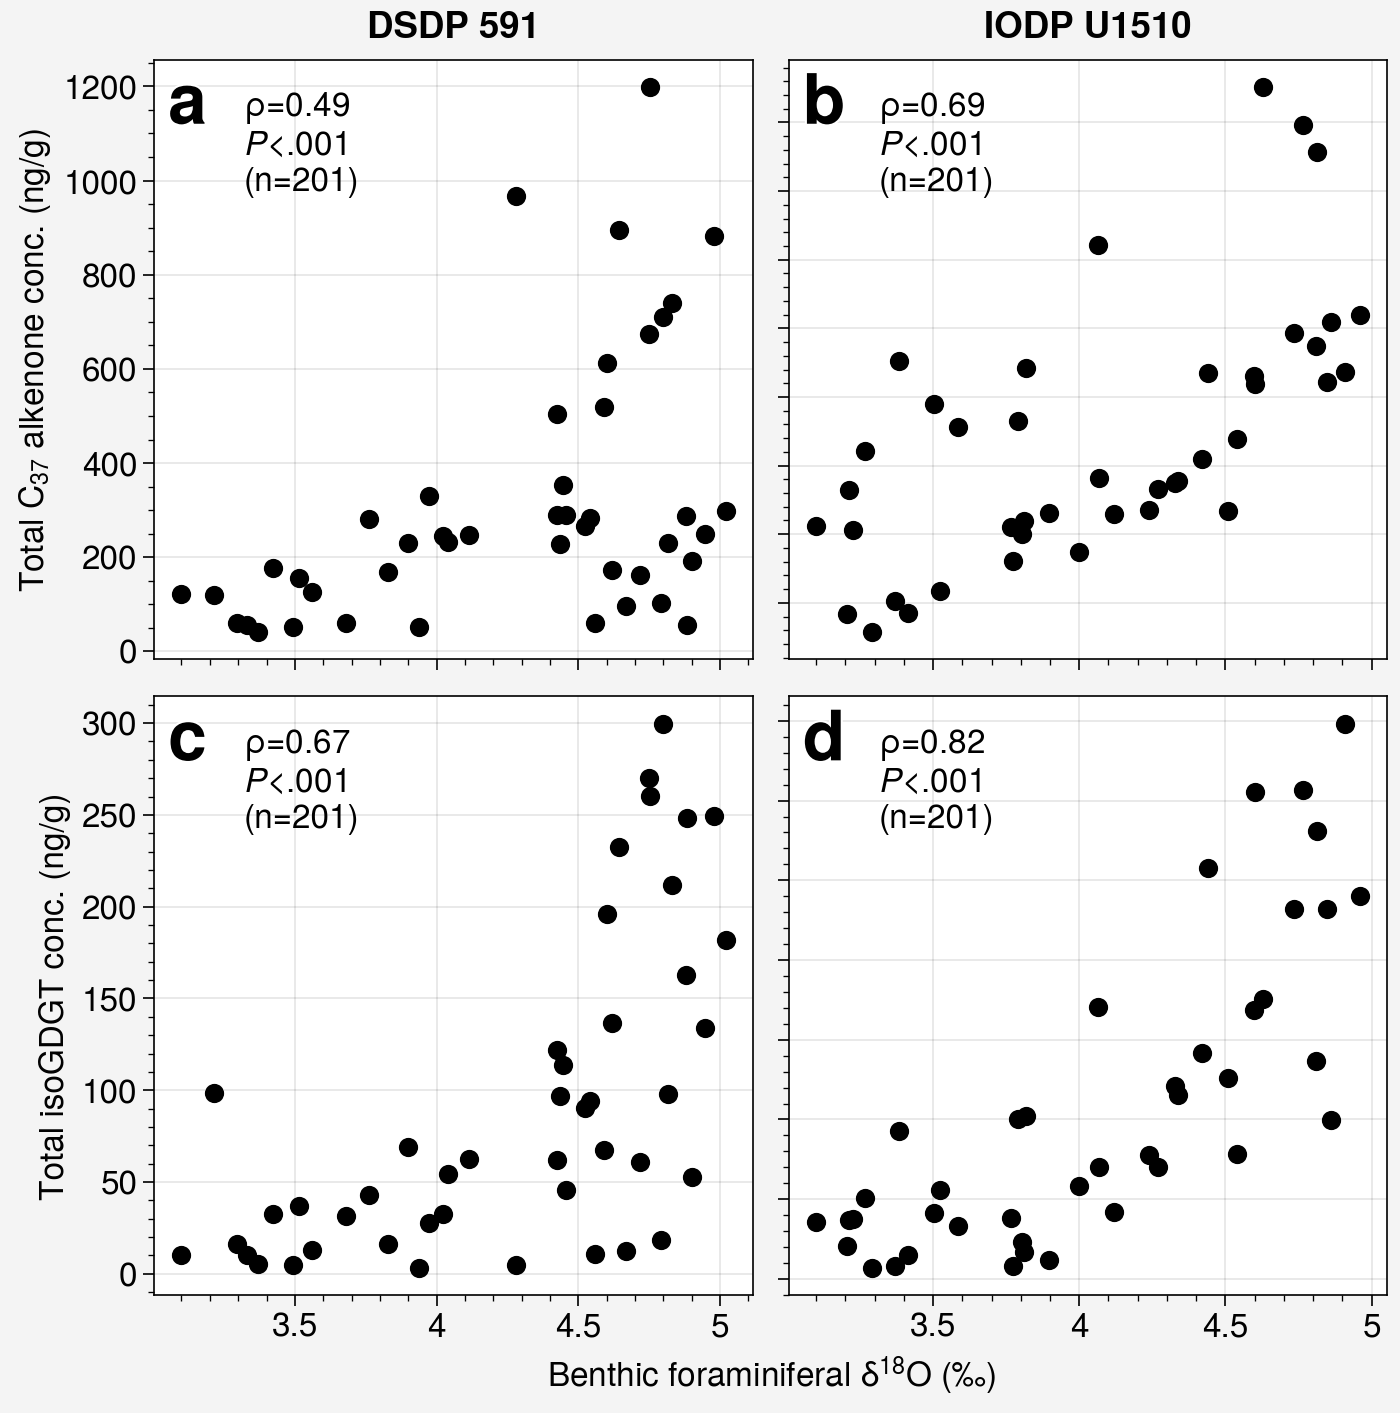

In [54]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

d18o_change_threshold = 0.1
fig, axs = plot.subplots(ncols=2,nrows=2,width=7,sharey=0)
axs.format(
    collabels=['DSDP 591','IODP U1510'],
    fontsize=12,
    abc='a',abcloc='ul',rc_kw={'abc.size':25}
)
y_params = ['uk37_conc_ng_g','gdgt_conc_ng_g']
for i, y_param in enumerate(y_params):
    ax = axs[i,0]

    plot_data = DSDP591_merged_df.sort_values(by='Age_x',ascending=False).reset_index(drop=True)
    plot_x = plot_data['LR04_benthic']
    plot_y = plot_data[y_param]
    ax.scatter(plot_x,plot_y,
            c='k',m='o',s=40,
            zorder=2)
    ### spreadman rho and pval
    reg_data = plot_data[['LR04_benthic',y_param]].dropna()
    rho, pval = spearmanr(reg_data['LR04_benthic'],reg_data[y_param])
    pval_label = label_pvalues(pval)
    ax.text(0.15,0.95,f'$\\rho$={rho:.2f}\n{pval_label}\n(n={len(group)})',
            transform=ax.transAxes,ha='left',va='top',fontsize=12)

    # plot_c = plot_data['LR04_benthic']

    # # Add arrows to indicate the flow of data points

    # for j in range(len(plot_c) - 1):
    #     if (plot_c.iloc[j] - plot_c.iloc[j+1]) > d18o_change_threshold:
    #         color = 'red9' 
    #     elif (plot_c.iloc[j] - plot_c.iloc[j+1]) < -d18o_change_threshold:
    #         color = 'blue9'    
    #     else:
    #         color = 'grey5'
        
    #     if ((plot_c.iloc[j] - plot_c.iloc[j+1]) > d18o_change_threshold):

    #         if ((plot_y.iloc[j] - plot_y.iloc[j+1]) > 0):
    #             ax.annotate('', xy=(plot_x.iloc[j], plot_y.iloc[j]), xytext=(plot_x.iloc[j+1], plot_y.iloc[j+1]),
    #                         arrowprops=dict(arrowstyle='<-', color=color, lw=2), zorder=0)
                
    #         else:
    #             ax.annotate('', xy=(plot_x.iloc[j], plot_y.iloc[j]), xytext=(plot_x.iloc[j+1], plot_y.iloc[j+1]),
    #                         arrowprops=dict(arrowstyle='<-', color=color, lw=1, ls=':'), zorder=0)
                
    #     elif ((plot_c.iloc[j] - plot_c.iloc[j+1]) < -d18o_change_threshold):
    #         if ((plot_y.iloc[j] - plot_y.iloc[j+1]) > 0):
    #             ax.annotate('', xy=(plot_x.iloc[j], plot_y.iloc[j]), xytext=(plot_x.iloc[j+1], plot_y.iloc[j+1]),
    #                         arrowprops=dict(arrowstyle='<-', color=color, lw=1, ls=':'), zorder=0)
    #         else:
    #             ax.annotate('', xy=(plot_x.iloc[j], plot_y.iloc[j]), xytext=(plot_x.iloc[j+1], plot_y.iloc[j+1]),
    #                         arrowprops=dict(arrowstyle='<-', color=color, lw=2), zorder=0)
    #     else:
    #         ax.annotate('', xy=(plot_x.iloc[j], plot_y.iloc[j]), xytext=(plot_x.iloc[j+1], plot_y.iloc[j+1]),
    #                     arrowprops=dict(arrowstyle='<-', color=color, lw=2), zorder=0)


    #     ### add text annotation for first and last age step
    #     if j == 0:
    #         ax.text(plot_x.iloc[j], plot_y.iloc[j]+200, f'150 ka', fontsize=10, ha='center', va='bottom')
    #     elif j == len(plot_c) - 2:
    #         ax.text(plot_x.iloc[j+1], plot_y.iloc[j+1], f'0 ka', fontsize=10, ha='center', va='top')



    ax = axs[i,1]

    plot_data = IODPU1510_merged_df.sort_values(by='Age_x',ascending=False).reset_index(drop=True)
    plot_x = plot_data['LR04_benthic']
    plot_y = plot_data[y_param]
    ax.scatter(plot_x,plot_y,
            c='k',m='o',s=40,
            zorder=2)
    ### spreadman rho and pval
    reg_data = plot_data[['LR04_benthic',y_param]].dropna()
    rho, pval = spearmanr(reg_data['LR04_benthic'],reg_data[y_param])
    pval_label = label_pvalues(pval)
    ax.text(0.15,0.95,f'$\\rho$={rho:.2f}\n{pval_label}\n(n={len(group)})',
            transform=ax.transAxes,ha='left',va='top',fontsize=12)

    # plot_c = plot_data['LR04_benthic']
    # # Add arrows to indicate the flow of data points
    # for j in range(len(plot_c) - 1):
    #     if (plot_c.iloc[j] - plot_c.iloc[j+1]) > d18o_change_threshold:
    #         color = 'red9' 
    #     elif (plot_c.iloc[j] - plot_c.iloc[j+1]) < -d18o_change_threshold:
    #         color = 'blue9'    
    #     else:
    #         color = 'grey5'
        
    #     if ((plot_c.iloc[j] - plot_c.iloc[j+1]) > d18o_change_threshold):

    #         if ((plot_y.iloc[j] - plot_y.iloc[j+1]) > 0):
    #             ax.annotate('', xy=(plot_x.iloc[j], plot_y.iloc[j]), xytext=(plot_x.iloc[j+1], plot_y.iloc[j+1]),
    #                         arrowprops=dict(arrowstyle='<-', color=color, lw=2), zorder=0,)
                
    #         else:
    #             ax.annotate('', xy=(plot_x.iloc[j], plot_y.iloc[j]), xytext=(plot_x.iloc[j+1], plot_y.iloc[j+1]),
    #                         arrowprops=dict(arrowstyle='<-', color=color, lw=1, ls=':'), zorder=0)
                
    #     elif ((plot_c.iloc[j] - plot_c.iloc[j+1]) < -d18o_change_threshold):
    #         if ((plot_y.iloc[j] - plot_y.iloc[j+1]) > 0):
    #             ax.annotate('', xy=(plot_x.iloc[j], plot_y.iloc[j]), xytext=(plot_x.iloc[j+1], plot_y.iloc[j+1]),
    #                         arrowprops=dict(arrowstyle='<-', color=color, lw=1, ls=':'), zorder=0)
    #         else:
    #             ax.annotate('', xy=(plot_x.iloc[j], plot_y.iloc[j]), xytext=(plot_x.iloc[j+1], plot_y.iloc[j+1]),
    #                         arrowprops=dict(arrowstyle='<-', color=color, lw=2), zorder=0)
    #     else:
    #         ax.annotate('', xy=(plot_x.iloc[j], plot_y.iloc[j]), xytext=(plot_x.iloc[j+1], plot_y.iloc[j+1]),
    #                     arrowprops=dict(arrowstyle='<-', color=color, lw=2), zorder=0)


    #     ### add text annotation for first and last age step
    #     if j == 0:
    #         ax.text(plot_x.iloc[j], plot_y.iloc[j]+200, f'150 ka', fontsize=10, ha='center', va='bottom')
    #     elif j == len(plot_c) - 2:
    #         ax.text(plot_x.iloc[j+1], plot_y.iloc[j+1], f'0 ka', fontsize=10, ha='center', va='top')


axs[0,:].format(
    xlabel='Benthic foraminiferal $\delta^{18}$O (‰)',
    ylabel='Total C$_{37}$ alkenone conc. (ng/g)',
)
    
    
axs[1,:].format(
    xlabel='Benthic foraminiferal $\delta^{18}$O (‰)',
    ylabel='Total isoGDGT conc. (ng/g)',
)

axs[:,1].format(ylabel='',yticklabels=[])



# legend_elements = [
#     mlines.Line2D([0], [0], color='red9', lw=2, marker=r'$\rightarrow$', markersize=10, label='$\delta^{18}$O decrease, Alk. conc. decrease'),
#     mlines.Line2D([0], [0], color='red9', lw=1, linestyle=':', marker=r'$\rightarrow$', markersize=10, label='$\delta^{18}$O decrease, Alk. conc. increase'),
#     mlines.Line2D([0], [0], color='blue9', lw=1, linestyle=':', marker=r'$\rightarrow$', markersize=10, label='$\delta^{18}$O increase, Alk. conc. decrease'),
#     mlines.Line2D([0], [0], color='blue9', lw=2, marker=r'$\rightarrow$', markersize=10, label='$\delta^{18}$O increase, Alk. conc. increase'),
#     mlines.Line2D([0], [0], color='grey5', lw=2, marker=r'$\rightarrow$', markersize=10, label=r'$\delta^{18}$O change less than '+f'{d18o_change_threshold}‰')
# ]

# fig.legend(handles=legend_elements, loc='bottom', fontsize=10, frameon=False, ncol=2)
# axs[0,:].format(yscale='symlog',ylim=(10,3000))
# axs[1,:].format(yscale='symlog',ylim=(1,3000))
axs[:,1].format(yticklabels=[])

fpath = fr'{local_github_path}/figures/'
fname = 'Fig_S8_paleo_showcase_alkenoneConc_LR04_TasmanSea.pdf'
fig.savefig(os.path.join(fpath,fname),dpi=300,bbox_inches='tight',embed_fonts=True)